<a id="top"></a> 
## Internal Links ##

- Working [working](#working).

- [Load/Rebuild County Level Combined Data Set: Vaccination, Cases, Deaths: rebuild county_daily_df](#rebuild_county_daily_df)

-  [Build_hosp_df](#build_hosp_df).

-  [Build state_cd_df](#build-state_cd_df).

-  [Build week_cdh_df](#build-week_cdh_df).

-  [Build week_cdvh_df](#build-week_cdvh_df).

-  [Build state_cdh_df](#build-state_cdh_df).

-  [Build state_cvdh_df](#build-state_cvdh_df).

-  [Build us_cd_df](#build-us_cd_df).

-  [Build us_cdh_df](#build-us_cdh_df).

-  [Build us_cdvh_df](#build-us_cdvh_df).

-  [Build cumsum-week_cdvh_df](#build_cumsum-week_cdvh_df).



# here #

- Here [Working Here](#working).

MUsic...
Deaths Embracce
The MIrror
TItan's awakening
Dread 

Obscura or broken Keys...Intro?

Last Hope...POsitive Vibe
Blood BRothers
Born of a hero
Faction
Skyline +1 FOr TEnsion includes a drop
Fight for after

In Your Face for County timelapse (or tiers)

**John's Hopkins COVID Cases:** https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv

**John's Hopkins COVID Deaths:** https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv 

**CDC U.S. Vaccine Data:** https://data.cdc.gov/api/views/unsk-b7fc/rows.csv?accessType=DOWNLOAD

**CDC County Vaccine Data:** https://data.cdc.gov/api/views/8xkx-amqh/rows.csv?accessType=DOWNLOAD

**State Hospitalization Data:** https://healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD

**total_beds_7_day_avg**: Total Bed Capacity to treat people (Is Any Care Available?) Includes pediatrc

**all_adult_hospital_beds_7_day_avg** : All Adult Beds Capacity to treat Adults

**all_adult_hospital_inpatient_beds_7_day_avg**: Available Beds

-999999.0 = Numbers between 1-4 for the week

In [26]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors

import time

from importlib import reload #//*** Reload library reloads an external python File.

#//*** Use the whole window in the IPYNB editor
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import clear_output

from datetime import datetime
from pathlib import Path
import os
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

import process_covid


plt.style.use('fivethirtyeight')
data_folder_name = "raw_data"

ignore_folder = "anims"
current_dir = Path(os.getcwd()).absolute()
fontsize=20

#//***  Raw and Processed Filenames
confirmed_data_filename = "z_us_confirmed.csv"
death_data_filename =  "z_us_death_cases.csv"
county_daily_df_filename = "z_county_daily_df.csv.zip"
aggregate_hospital_filename = "z_county_hospital_aggregate.csv.zip"
combined_daily_casevax_filename = "z_county_daily_casevax.csv.zip"
weekly_combined_filename = "z_county_weekly_df.csv.zip"
weekly_combined_historical_filename = "z_county_weekly_case_hosp_df.csv.zip"

#//*** Weekly Combined Cases,Deaths, Vaccines, Hospital
weekly_combined_cdvh_df_filename = "z_county_weekly_combined_cdvh_df.csv.zip"

#//*** Load Raw Hospital Data
#cd.add(process_covid.load_data(filename="z_county_hospital.csv.zip"),'raw_hosp_df',"Raw Unprocessed Hospital Data")

In [2]:
color_dict = {
    'c' : "#00aedb",
    'v' : "#a200ff",
    'd' : "#f47835",
    'h' : "#d41243",
    'i' : "#8ec127",
    'high' : "#4682B4",
    'med' : "#AEA1EA",
    'low' : "#8C54A1"
}

color_dict['low'] = "#3988ff"
color_dict['low'] = "#b468f2"

color_dict['med'] = "#eeb400"
color_dict['high'] = "#a6d298"

#//*** high old blue: B2EBF9

# Load Dataframe Collection Class #
**Simple Class to keep all Dataframes in a single structure. Each Dataframe has a description to help keep track** 

In [3]:
reload(process_covid)

cd = process_covid.collect_dataframes()

# Load Geopandas Dataframe Shape Files #

In [4]:
reload(process_covid)


#//*** get county shape file
geo_df = gpd.read_file('maps\cb_2018_us_county_20m.shp')
geo_df['GEOID'] = geo_df['GEOID'].astype(int)
cd.add(geo_df,"county_geo_df","Geopandas DataFrame: Counties")

#//*** Get Shape File
#geo_df = gpd.read_file('maps\cb_2018_us_county_20m.shp')
geo_df = gpd.read_file('maps\cb_2018_us_state_20m.shp')

geo_df['GEOID'] = geo_df['GEOID'].astype(int)

cd.add(geo_df,"state_geo_df","Geopandas DataFrame: States")


# Load Weekly County Confirmed Death Vax Hospitalizations #
<a id="build-week_cdvh_df"></a> [Top](#top)


In [5]:
reload(process_covid)

#//*****************************************************************************************
#//*** List of Tuples to rename columns.
#//*** This is just a convenience renaming
#//*** In the current version only the sum cols which represent total hospital bed days.
#//*** the avg values are for average daily hospital beds
#//*****************************************************************************************
rename_cols_sum = [('total_beds_7_day_sum',"all_bed_types"),
                   ('inpatient_beds_7_day_sum','beds'),
                   ('inpatient_beds_used_7_day_sum','beds_used'),
                   ('inpatient_beds_used_covid_7_day_sum','beds_covid'),
                   ('total_icu_beds_7_day_sum','all_icu'),
                   ('icu_beds_used_7_day_sum','icu_used'),
                   ('staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum','icu_covid'),
                   ('total_vaccinated_percent','vax_pct'),
                   ('total_vaccinated_count','vax_ct'),
                   ('first_dose_pct','first_pct'),
                   ('first_dose_count','first_ct'),
                   ('Admin2','cty'),
                   ('Population','pop'),
                   ('New_Confirm_100k','tc_100k'),
                   ('New_Confirm_avg_daily_100k','nc_avg_daily_100k'),
                   ('New_Deaths_100k','td_100k'),
                   ('New_Deaths_avg_daily_100k','nd_avg_daily_100k'),
                  ]

rename_cols_avg = [('total_beds_7_day_avg',"all_bed_types"),
                   ('inpatient_beds_7_day_avg','beds'),
                   ('inpatient_beds_used_7_day_avg','beds_used'),
                   ('inpatient_beds_used_covid_7_day_avg','beds_covid'),
                   ('total_icu_beds_7_day_avg','all_icu'),
                   ('icu_beds_used_7_day_avg','icu_used'),
                   ('staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg','icu_covid'),
                   ('total_vaccinated_percent','vax_pct'),
                   ('total_vaccinated_count','vax_ct'),
                   ('first_dose_pct','first_pct'),
                   ('first_dose_count','first_ct'),
                   ('Admin2','cty'),
                   ('Population','pop'),
                   ('New_Confirm_100k','tc_100k'),
                   ('New_Confirm_avg_daily_100k','nc_avg_daily_100k'),
                   ('New_Deaths_100k','td_100k'),
                   ('New_Deaths_avg_daily_100k','nd_avg_daily_100k'),
                  ]

#//*** We're bolting on a More efficient Calculate Section. Need to cleanup Download and Process to make it faster and more efficient
remove_cols = ['first_pct','first_ct','case_7_day_avg', 'death_7_day_avg',
       'case_100k_avg', 'death_100k_avg', 'case_scaled_100k',
       'death_scaled_100k', 'pv_tot_confirm', 'pv_tot_death','all_bed_types','Province_State']

#//*****************************************************************************************
#//*** Load the Combined Weekly data of vaccinations, Confirmed, hospitalizations, & Deaths
#//*****************************************************************************************
df = process_covid.load_data(
    filename=weekly_combined_cdvh_df_filename,
     #//*** Rename Columns for readability using a list of tuples in (find,replace) format
    rename_cols = rename_cols_sum,
    remove_cols=remove_cols,
    auto_convert_to_float = True
    )                                      

dfs = []
disp_cols = ['Date', 'FIPS', 'Recip_State', 'cty', 'Combined_Key', 'pop', 'vax_pct', 'vax_ct', 'tot_confirm', 'tot_deaths', 'New_Confirm', 'New_Deaths', 'all_bed_types', 'beds', 'beds_used', 'beds_covid', 'all_icu', 'icu_used', 'icu_covid']
disp_cols = ['Date', 'FIPS', 'Recip_State', 'cty', 'Combined_Key', 'pop', 'vax_pct', 'vax_ct', 'tot_confirm', 'tot_deaths', 'New_Confirm', 'New_Deaths', 'beds_covid', 'icu_covid','beds', 'beds_used','all_icu', 'icu_used']
display(df.columns)
#//*** Group by FIPS and perform a standard recalc
#//*** This keeps the ccalculations identical across all Aggregation levels
for group in df.groupby("FIPS"):
    #tdf = group[1].copy()[disp_cols]
    tdf = process_covid.standard_recalc_cols(group[1])

    dfs.append(tdf)


cd.add(pd.concat(dfs),'week_cdvh_df','County/Weekly Confirmed, Death,Vaccine, Hospitalization')
df=cd.get('week_cdvh_df')
display(df[df['FIPS'] == 30063])


Index(['Date', 'FIPS', 'Recip_State', 'vax_pct', 'vax_ct', 'cty',
       'Combined_Key', 'pop', 'tot_confirm', 'tot_deaths', 'New_Confirm',
       'New_Deaths', 'state', 'beds', 'beds_used', 'beds_covid', 'all_icu',
       'icu_used', 'icu_covid'],
      dtype='object')

Date     FIPS Recip_State  vax_pct   vax_ct       cty  \
1182 2020-12-18  30063.0          MT      0.0      0.0  Missoula   
2421 2020-12-25  30063.0          MT      0.0      0.0  Missoula   
1051 2021-01-01  30063.0          MT      0.0      0.0  Missoula   
690  2021-01-08  30063.0          MT      0.0      0.0  Missoula   
2142 2021-01-15  30063.0          MT      1.4   1725.0  Missoula   
367  2021-01-22  30063.0          MT      2.0   2395.0  Missoula   
669  2021-01-29  30063.0          MT      3.0   3571.0  Missoula   
1065 2021-02-05  30063.0          MT      3.6   4287.0  Missoula   
1492 2021-02-12  30063.0          MT      4.7   5672.0  Missoula   
1136 2021-02-19  30063.0          MT      6.8   8102.0  Missoula   
2136 2021-02-26  30063.0          MT      9.1  10847.0  Missoula   
2089 2021-03-05  30063.0          MT     10.7  12825.0  Missoula   
138  2021-03-12  30063.0          MT     13.6  16312.0  Missoula   
1483 2021-03-19  30063.0          MT     15.4  18426.0  Missoula   
268  2021-03-26  30063.0          MT     17.2  20622.0  Missoula   
1453 2021-04-02  30063.0          MT     20.4  24370.0  Missoula   
1672 2021-04-09  30063.0          MT     25.6  30636.0  Missoula   
1255 2021-04-16  30063.0          MT     31.2  37302.0  Missoula   
1137 2021-04-23  30063.0          MT     36.7  43914.0  Missoula   
454  2021-04-30  30063.0          MT     41.2  49251.0  Missoula   
1380 2021-05-07  30063.0          MT     43.7  52323.0  Missoula   
1578 2021-05-14  30063.0          MT     45.5  54402.0  Missoula   
912  2021-05-21  30063.0          MT     47.2  56445.0  Missoula   
25   2021-05-28  30063.0          MT     48.8  58345.0  Missoula   
800  2021-06-04  30063.0          MT     49.1  58724.0  Missoula   
1943 2021-06-11  30063.0          MT     50.8  60777.0  Missoula   
1587 2021-06-18  30063.0          MT     52.1  62299.0  Missoula   
1561 2021-06-25  30063.0          MT     52.5  62750.0  Missoula   
772  2021-07-02  30063.0          MT     53.1  63458.0  Missoula   
20   2021-07-09  30063.0          MT     53.3  63767.0  Missoula   
1126 2021-07-16  30063.0          MT     53.6  64047.0  Missoula   
206  2021-07-23  30063.0          MT     53.8  64324.0  Missoula   
1772 2021-07-30  30063.0          MT     54.0  64603.0  Missoula   
1678 2021-08-06  30063.0          MT     54.3  64896.0  Missoula   
869  2021-08-13  30063.0          MT     54.6  65290.0  Missoula   
1011 2021-08-20  30063.0          MT     55.0  65747.0  Missoula   
353  2021-08-27  30063.0          MT     55.4  66273.0  Missoula   
1893 2021-09-03  30063.0          MT     55.8  66784.0  Missoula   
499  2021-09-10  30063.0          MT     56.2  67268.0  Missoula   
2364 2021-09-17  30063.0          MT     56.6  67747.0  Missoula   
1208 2021-09-24  30063.0          MT     57.0  68144.0  Missoula   
1676 2021-10-01  30063.0          MT     57.2  68451.0  Missoula   
773  2021-10-08  30063.0          MT     57.6  68891.0  Missoula   
1656 2021-10-15  30063.0          MT     57.9  69200.0  Missoula   
1305 2021-10-22  30063.0          MT     58.3  69673.0  Missoula   
4    2021-10-29  30063.0          MT     58.6  70104.0  Missoula   
2165 2021-11-05  30063.0          MT     58.8  70362.0  Missoula   
813  2021-11-12  30063.0          MT     59.0  70592.0  Missoula   
1063 2021-11-19  30063.0          MT     59.3  70970.0  Missoula   
1013 2021-11-26  30063.0          MT     59.5  71132.0  Missoula   
1036 2021-12-03  30063.0          MT     59.9  71581.0  Missoula   
498  2021-12-10  30063.0          MT     61.1  73060.0  Missoula   
299  2021-12-17  30063.0          MT     62.0  74120.0  Missoula   
2199 2021-12-24  30063.0          MT     62.2  74432.0  Missoula   
1675 2021-12-31  30063.0          MT     62.3  74570.0  Missoula   
1567 2022-01-07  30063.0          MT     62.5  74787.0  Missoula   
2204 2022-01-14  30063.0          MT     62.8  75106.0  Missoula   
1964 2022-01-21  30063.0          MT     63.1  75500.0  Missoula   

# Load Daily County Cases and Deaths #

In [6]:
cd.add(process_covid.load_data(filename=county_daily_df_filename,remove_cols=['case_7_day_avg','death_7_day_avg','case_100k_avg','death_100k_avg','case_scaled_100k','death_scaled_100k']),'county_daily_df',"County/Daily Cases and Deaths")





# Load Weekly County Hospitalizations # 

<a id="build_hosp_df"></a> [Top](#top)


In [7]:
#//****************************************************************************************
#//*** Load aggregated (summed by county) Hospital Data, provides cleanest cumsum values
#//****************************************************************************************
df = process_covid.load_data(
    filename=aggregate_hospital_filename,
    #//*** Rename Columns for readability using a list of tuples in (find,replace) format
    rename_cols = [('total_beds_7_day_sum',"all_bed_types"),
                   ('inpatient_beds_7_day_sum','beds'),
                   ('inpatient_beds_used_7_day_sum','beds_used'),
                   ('inpatient_beds_used_covid_7_day_sum','beds_covid'),
                   ('total_icu_beds_7_day_sum','all_icu'),
                   ('icu_beds_used_7_day_sum','icu_used'),
                   ('staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum','icu_covid'),
                   ('collection_week',"Date"),
                  ])
df['Date'] = pd.to_datetime(df['Date'])
df = process_covid.cumsum_cols(df,cols=['beds_covid','icu_covid'], by='fips_code', date_col="Date", suffix="_tot")
cd.add(df,'hosp_df',"County/Weekly Hospitalization Data")
display(df.head())

Date fips_code state all_bed_types    beds beds_used beds_covid  \
0 2020-07-31    1001.0    AL         574.0   455.0     363.0      119.0   
1 2020-07-31   13057.0    GA           0.0     0.0       0.0      272.0   
2 2020-07-31   46107.0    SD          18.0    18.0      12.0        0.0   
3 2020-07-31   13055.0    GA        1197.0  1071.0     838.0      143.0   
4 2020-07-31   46109.0    SD         100.0    48.0      23.0        0.0   

  all_icu icu_used icu_covid beds_covid_tot icu_covid_tot  
0    42.0     40.0      28.0          119.0          28.0  
1   162.0      0.0       0.0          272.0           0.0  
2     0.0      0.0       0.0            0.0           0.0  
3    98.0     89.0       0.0          143.0           0.0  
4     0.0      0.0       0.0            0.0           0.0

# Build: Weekly Confirm Death Hospitalization #
<a id="build-week_cdh_df"></a> [Top](#top)

Hospitalizations without Vaccines provides 5 months of additional hospitalization data

In [8]:
reload(process_covid)
#//*** Build Weekly Case Death & Hospital

    
dates =  cd.get('hosp_df')['Date'].unique()

#print(dates)

#//*** Get Weekly Values
df = cd.get('county_daily_df')
df['Date'] = df['Date'].apply(lambda x: pd.Timestamp(x))
dates = cd.get('hosp_df')['Date'].apply(lambda x: pd.Timestamp(x))

#//*** Soo Slick. Select dates from a unique list of dates in hospital
df = df [ df['Date'].isin(dates)]

#//*** Recompute New Confirm New Deaths
df = process_covid.diff_cols(df,cols=[('tot_confirm','New_Confirm'), ('tot_deaths','New_Deaths')],by="FIPS",suffix="")
#//*** Build confirm and death running totals
df = process_covid.cumsum_cols(df,cols=['New_Confirm', 'New_Deaths'],by="FIPS",suffix="_tot")

#//*** Combine Weekly Valuess with Hospital
df = process_covid.merge_df(df,cd.get('hosp_df'),left_col="FIPS",right_col="fips_code")

#//*** Rename Population Column to pop
df.columns = ['pop' if item == 'Population' else item for item in list(df.columns)]

display(df)
display(df [df["FIPS"] == 1003].iloc[:10])

#//*** Load Weekly Case Death Hospital
cd.add(df,'week_cdh_df','County/Weekly Cases Deaths Hospitalizations: 2020-07-31 - 2022-04-08')


Elapsed Time: 0s


Date   FIPS          Admin2 Province_State  \
0    2020-07-31   1001         Autauga        Alabama   
1    2020-07-31  40079        Le Flore       Oklahoma   
2    2020-07-31  40081         Lincoln       Oklahoma   
3    2020-07-31  40083           Logan       Oklahoma   
4    2020-07-31   6029            Kern     California   
...         ...    ...             ...            ...   
2427 2022-04-29  29145          Newton       Missouri   
2428 2022-04-29  55119          Taylor      Wisconsin   
2429 2022-04-29  12015       Charlotte        Florida   
2430 2022-04-29  29147         Nodaway       Missouri   
2431 2022-04-29  29186  Ste. Genevieve       Missouri   

                      Combined_Key     pop  tot_confirm  tot_deaths  \
0             Autauga, Alabama, US   55869         1042          20   
1           Le Flore, Oklahoma, US   49853          218           1   
2            Lincoln, Oklahoma, US   34877          118           2   
3              Logan, Oklahoma, US   48011          170           1   
4             Kern, California, US  900202        19335         140   
...                            ...     ...          ...         ...   
2427          Newton, Missouri, US   58236        11730         203   
2428         Taylor, Wisconsin, US   20343         4845          72   
2429        Charlotte, Florida, US  188910        36329         807   
2430         Nodaway, Missouri, US   22092         6048          44   
2431  Ste. Genevieve, Missouri, US   17894         3655          39   

      New_Confirm  New_Deaths  New_Confirm_tot  New_Deaths_tot fips_code  \
0             0.0         0.0              0.0             0.0    1001.0   
1             0.0         0.0              0.0             0.0   40079.0   
2             0.0         0.0              0.0             0.0   40081.0   
3             0.0         0.0              0.0             0.0   40083.0   
4             0.0         0.0              0.0             0.0    6029.0   
...           ...         ...              ...             ...       ...   
2427          0.0         0.0          10936.0           198.0   29145.0   
2428          9.0         0.0           4798.0            72.0   55119.0   
2429          0.0         1.0          34383.0           721.0   12015.0   
2430          7.0         0.0           5901.0            44.0   29147.0   
2431          0.0         0.0           3609.0            38.0   29186.0   

     state all_bed_types    beds beds_used beds_covid all_icu icu_used  \
0       AL         574.0   455.0     363.0      119.0    42.0     40.0   
1       OK          81.0     0.0       0.0       90.0     0.0      0.0   
2       OK         144.0     0.0      36.0       17.0     0.0      0.0   
3       OK         595.0   595.0      92.0        0.0     0.0      0.0   
4       CA       10928.0  6347.0    5351.0     1601.0  1102.0    838.0   
...    ...           ...     ...       ...        ...     ...      ...   
2427    MO          78.0    60.0      60.0        5.0     0.0      0.0   
2428    WI           0.0   245.0      83.0        7.0    21.0      9.0   
2429    FL        3003.0  5005.0    2701.0      112.0   413.0    231.0   
2430    MO         189.0   189.0     146.0       12.0    14.0      0.0   
2431    MO         175.0   175.0      72.0        0.0     0.0      0.0   

     icu_covid beds_covid_tot icu_covid_tot  
0         28.0          119.0          28.0  
1          0.0           90.0           0.0  
2          0.0           17.0           0.0  
3          0.0            0.0           0.0  
4        513.0         1601.0         513.0  
...        ...            ...           ...  
2427       0.0         1295.0          96.0  
2428       0.0         2291.0         513.0  
2429      16.0        30703.0        7231.0  
2430       0.0         1370.0           0.0  
2431       0.0          661.0           0.0  

[223808 rows x 23 columns]

Date  FIPS   Admin2 Province_State          Combined_Key     pop  \
2369 2020-07-31  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
1598 2020-08-07  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
2221 2020-08-14  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
960  2020-08-21  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
332  2020-08-28  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
2089 2020-09-04  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
1120 2020-09-11  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
1252 2020-09-18  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
539  2020-09-25  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
1232 2020-10-02  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   

      tot_confirm  tot_deaths  New_Confirm  New_Deaths  New_Confirm_tot  \
2369         3116          21          0.0         0.0              0.0   
1598         3533          23        417.0         2.0            417.0   
2221         3881          29        348.0         6.0            765.0   
960          4100          32        219.0         3.0            984.0   
332          4408          35        308.0         3.0           1292.0   
2089         4654          42        246.0         7.0           1538.0   
1120         4881          43        227.0         1.0           1765.0   
1252         5016          48        135.0         5.0           1900.0   
539          5419          50        403.0         2.0           2303.0   
1232         6009          53        590.0         3.0           2893.0   

      New_Deaths_tot fips_code state all_bed_types    beds beds_used  \
2369             0.0    1003.0    AL        2961.0  2541.0    2140.0   
1598             2.0    1003.0    AL        2961.0  2541.0    2136.0   
2221             8.0    1003.0    AL        2961.0  2541.0    2078.0   
960             11.0    1003.0    AL        2961.0  2541.0    2041.0   
332             14.0    1003.0    AL        2961.0  2541.0    1949.0   
2089            21.0    1003.0    AL        2961.0  2541.0    1903.0   
1120            22.0    1003.0    AL        2753.0  2359.0    1677.0   
1252            27.0    1003.0    AL        2961.0  2541.0    2061.0   
539             29.0    1003.0    AL        2961.0  2541.0    1884.0   
1232            32.0    1003.0    AL        2961.0  2541.0    1961.0   

     beds_covid all_icu icu_used icu_covid beds_covid_tot icu_covid_tot  
2369      487.0   224.0    263.0     153.0          487.0         153.0  
1598      488.0   224.0    276.0     142.0          975.0         295.0  
2221      422.0   224.0    250.0     106.0         1397.0         401.0  
960       313.0   224.0    252.0      91.0         1710.0         492.0  
332       263.0   224.0    215.0      65.0         1973.0         557.0  
2089      185.0   224.0    210.0      50.0         2158.0         607.0  
1120      148.0   207.0    174.0      39.0         2306.0         646.0  
1252      194.0   224.0    198.0      49.0         2500.0         695.0  
539       198.0   224.0    182.0      47.0         2698.0         742.0  
1232      162.0   224.0    175.0      41.0         2860.0         783.0

In [9]:
cd.l()

Collected Dataframe Count:  6
[county_geo_df] Desc: Geopandas DataFrame: Counties
[state_geo_df] Desc: Geopandas DataFrame: States
[week_cdvh_df] Desc: County/Weekly Confirmed, Death,Vaccine, Hospitalization
[county_daily_df] Desc: County/Daily Cases and Deaths
[hosp_df] Desc: County/Weekly Hospitalization Data
[week_cdh_df] Desc: County/Weekly Cases Deaths Hospitalizations: 2020-07-31 - 2022-04-08


# Daily Confirmed Deaths: States #
<a id="build-state_cd_df"></a> [Top](#top)


In [10]:
reload(process_covid)

df = cd.get('county_daily_df')
display(df)
df.columns = ['pop' if item == 'Population' else item for item in list(df.columns)]

sum_cols = ['pop','tot_confirm','tot_deaths']

state_list = []
for state_group in df.groupby("Province_State"):
    #//*** Build a DF for each State Aggregating the State Totals
    #//*** Sum all Counties by Date
    #//*** Sum columns listed in sum_cols
    loop_df =  process_covid.build_stats_for_analysis(  
        state_group[1], #//*** DF of CA results
        action='agg_cols',     #//*** Agggregate Columns
        cols=sum_cols,         #//*** List of Columns to Aggregate
        agg='sum',             #//*** Aggregation Action: Sum
        label=('state',state_group[0]),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
        #cumsum=sum_cols[2:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
        build_100k = False,
        verbose = False,
        #//*** List of Tuples Defining Outcome ratios format[( col1,col2,new_col)]

        #outcome_ratios = [
        #    ('vax_ct','tot_confirm','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
        #    ('vax_ct','tot_deaths','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
        #    ('vax_ct','beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
        #    ('vax_ct','icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
        #    ('uvx','tot_confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
        #    ('uvx','tot_deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
        #    ('uvx','beds_covid_tot','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
        #    ('uvx','icu_covid_tot','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
        #    ('beds_tot','beds_covid_tot','bcbtr'), #//*** Beds Covid to Total Beds Ratio - bcbtr

        #],
    )
    state_list.append(loop_df)

df = pd.concat(state_list)

#//*** Recompute New Confirm New Deaths
df = process_covid.diff_cols(df,cols=[('tot_confirm','New_Confirm'), ('tot_deaths','New_Deaths')],by="state",suffix="")
#//*** Build confirm and death running totals
#df = process_covid.cumsum_cols(df,cols=['New_Confirm', 'New_Deaths'],by="state",suffix="_tot")

#//*** BUild 100k Columns
df = process_covid.build_100k(df,cols=list(df.columns)[3:])

cd.add(df,'state_cd_df',"State/Daily Cases Deaths - Entire Pandemic - [ 2020-01-29 - 2022-04-24]")

df = cd.get('state_cd_df')
df[df['state'] == "California"].iloc[50:100]


Date   FIPS     Admin2 Province_State              Combined_Key  \
7   2020-01-29   1001    Autauga        Alabama      Autauga, Alabama, US   
8   2020-01-30   1001    Autauga        Alabama      Autauga, Alabama, US   
9   2020-01-31   1001    Autauga        Alabama      Autauga, Alabama, US   
10  2020-02-01   1001    Autauga        Alabama      Autauga, Alabama, US   
11  2020-02-02   1001    Autauga        Alabama      Autauga, Alabama, US   
..         ...    ...        ...            ...                       ...   
833 2022-05-04  80047  Out of TN      Tennessee  Out of TN, Tennessee, US   
834 2022-05-05  80047  Out of TN      Tennessee  Out of TN, Tennessee, US   
835 2022-05-06  80047  Out of TN      Tennessee  Out of TN, Tennessee, US   
836 2022-05-07  80047  Out of TN      Tennessee  Out of TN, Tennessee, US   
837 2022-05-08  80047  Out of TN      Tennessee  Out of TN, Tennessee, US   

     Population  tot_confirm  tot_deaths  New_Confirm  New_Deaths  
7         55869            0           0          0.0         0.0  
8         55869            0           0          0.0         0.0  
9         55869            0           0          0.0         0.0  
10        55869            0           0          0.0         0.0  
11        55869            0           0          0.0         0.0  
..          ...          ...         ...          ...         ...  
833           0        48746         272        128.0         1.0  
834           0        48746         272          0.0         0.0  
835           0        48746         272          0.0         0.0  
836           0        48746         272          0.0         0.0  
837           0        48746         272          0.0         0.0  

[2614423 rows x 10 columns]

Date       state       pop  tot_confirm  tot_deaths  New_Confirm  \
2579 2020-03-19  California  39512223          983          20        190.0   
2625 2020-03-20  California  39512223         1244          23        261.0   
2670 2020-03-21  California  39512223         1396          26        152.0   
2735 2020-03-22  California  39512223         1697          36        301.0   
2768 2020-03-23  California  39512223         2073          40        376.0   
2813 2020-03-24  California  39512223         2501          51        428.0   
2893 2020-03-25  California  39512223         3013          66        512.0   
2908 2020-03-26  California  39512223         3879          80        866.0   
3007 2020-03-27  California  39512223         4537         100        658.0   
3018 2020-03-28  California  39512223         7514         188       2977.0   
3076 2020-03-29  California  39512223         5495         132      -2019.0   
3115 2020-03-30  California  39512223         6864         149       1369.0   
3187 2020-03-31  California  39512223         8011         170       1147.0   
3248 2020-04-01  California  39512223         9266         198       1255.0   
3298 2020-04-02  California  39512223        10765         236       1499.0   
3325 2020-04-03  California  39512223        12089         273       1324.0   
3393 2020-04-04  California  39512223        12835         292        746.0   
3447 2020-04-05  California  39512223        14490         342       1655.0   
3506 2020-04-06  California  39512223        15957         371       1467.0   
3539 2020-04-07  California  39512223        17055         424       1098.0   
3596 2020-04-08  California  39512223        18410         485       1355.0   
3650 2020-04-09  California  39512223        19533         537       1123.0   
3711 2020-04-10  California  39512223        20749         577       1216.0   
3752 2020-04-11  California  39512223        21458         599        709.0   
3823 2020-04-12  California  39512223        22197         632        739.0   
3845 2020-04-13  California  39512223        23407         696       1210.0   
3881 2020-04-14  California  39512223        24545         781       1138.0   
3966 2020-04-15  California  39512223        26357         873       1812.0   
4016 2020-04-16  California  39512223        27579         955       1222.0   
4034 2020-04-17  California  39512223        29297        1023       1718.0   
4120 2020-04-18  California  39512223        30643        1127       1346.0   
4169 2020-04-19  California  39512223        31308        1159        665.0   
4208 2020-04-20  California  39512223        33563        1199       2255.0   
4265 2020-04-21  California  39512223        35754        1287       2191.0   
4330 2020-04-22  California  39512223        37749        1412       1995.0   
4364 2020-04-23  California  39512223        39597        1502       1848.0   
4389 2020-04-24  California  39512223        41467        1585       1870.0   
4480 2020-04-25  California  39512223        42433        1660        966.0   
4509 2020-04-26  California  39512223        43736        1692       1303.0   
4584 2020-04-27  California  39512223        45314        1732       1578.0   
4630 2020-04-28  California  39512223        46829        1827       1515.0   
4641 2020-04-29  California  39512223        49226        1910       2397.0   
4696 2020-04-30  California  39512223        50715        1999       1489.0   
4769 2020-05-01  California  39512223        52549        2095       1834.0   
4824 2020-05-02  California  39512223        53887        2157       1338.0   
4848 2020-05-03  California  39512223        55254        2199       1367.0   
4944 2020-05-04  California  39512223        56614        2244       1360.0   
4996 2020-05-05  California  39512223        59202        2357       2588.0   
5009 2020-05-06  California  39512223        61081        2441       1879.0   
5088 2020-05-07  California  39512223        63006        251

In [11]:
# Add GeoPandas State and County Levels

In [12]:
cd.l()


Collected Dataframe Count:  7
[county_geo_df] Desc: Geopandas DataFrame: Counties
[state_geo_df] Desc: Geopandas DataFrame: States
[week_cdvh_df] Desc: County/Weekly Confirmed, Death,Vaccine, Hospitalization
[county_daily_df] Desc: County/Daily Cases and Deaths
[hosp_df] Desc: County/Weekly Hospitalization Data
[week_cdh_df] Desc: County/Weekly Cases Deaths Hospitalizations: 2020-07-31 - 2022-04-08
[state_cd_df] Desc: State/Daily Cases Deaths - Entire Pandemic - [ 2020-01-29 - 2022-04-24]


# Weekly Confirmed Deaths Hospitalization: States #

<a id="build-state_cdh_df"></a> [Top](#top)


In [13]:

reload(process_covid)

sum_cols = ['pop','tot_confirm','tot_deaths','beds_covid','icu_covid','beds','icu_used']

state_list = []
for state_group in cd.get('week_cdh_df').groupby("Province_State"):
    #display(state_group[1])
    #//*** Build a DF for each State Aggregating the State Totals
    #//*** Sum all Counties by Date
    #//*** Sum columns listed in sum_cols
    loop_df =  process_covid.build_stats_for_analysis(  
        state_group[1], #//*** DF of CA results
        action='agg_cols',     #//*** Agggregate Columns
        cols=sum_cols,         #//*** List of Columns to Aggregate
        agg='sum',             #//*** Aggregation Action: Sum
        label=('state',state_group[0]),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
        #cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
        #build_100k = True,
        verbose = False,

    )
    state_list.append(loop_df)


          
df = pd.concat(state_list)

df = process_covid.diff_cols(df,cols=[('tot_confirm','New_Confirm'), ('tot_deaths','New_Deaths')],by="state",suffix="")

#//*** Build confirm and death running totals
df = process_covid.cumsum_cols(df,cols=['beds_covid', 'icu_covid'],by="state",suffix="_tot")

#//*** BUild 100k Columns
df = process_covid.build_100k(df,cols=list(df.columns)[3:])

#df['rbcbtr'] = df['beds_covid'] / df['beds'] 
cd.add(df,'state_cdh_df','State Weekly Cases Deaths Hospitals')
df = cd.get('state_cdh_df')
df[df['state'] == "California"]


Date       state       pop  tot_confirm  tot_deaths beds_covid  \
16   2020-07-31  California  39508089       506935        9122    51626.0   
58   2020-08-07  California  39508089       553699       10019    46828.0   
139  2020-08-14  California  39508089       619800       11012    43542.0   
161  2020-08-21  California  39508089       662856       11802    38523.0   
232  2020-08-28  California  39508089       699731       12638    33135.0   
258  2020-09-04  California  39508089       733226       13501    28397.0   
324  2020-09-11  California  39479696       756007       14115    24890.0   
399  2020-09-18  California  39508089       780952       14825    22915.0   
455  2020-09-25  California  39508089       805718       15391    21865.0   
496  2020-10-02  California  39479696       828540       15971    20989.0   
540  2020-10-09  California  39508089       853032       16400    21339.0   
580  2020-10-16  California  39445281       874305       16814    20868.0   
617  2020-10-23  California  39508089       905203       17231    20980.0   
671  2020-10-30  California  39508089       935585       17569    23250.0   
763  2020-11-06  California  39508089       973301       17913    26599.0   
799  2020-11-13  California  39479696      1027187       18202    34002.0   
819  2020-11-20  California  39479696      1112478       18651    45850.0   
892  2020-11-27  California  39508089      1214179       19131    61840.0   
939  2020-12-04  California  39508089      1355265       19798    79811.0   
1006 2020-12-11  California  39508089      1579209       20822   106069.0   
1025 2020-12-18  California  39508089      1876451       22373   130459.0   
1111 2020-12-25  California  39508089      2147716       23916   144780.0   
1155 2021-01-01  California  39508089      2435496       26258   153920.0   
1190 2021-01-08  California  39508089      2728938       29069   164061.0   
1252 2021-01-15  California  39508089      3015244       32390   144226.0   
1279 2021-01-22  California  39508089      3204750       35664   124903.0   
1340 2021-01-29  California  39508089      3348577       39438   102809.0   
1417 2021-02-05  California  39508089      3452229       43124    82782.0   
1442 2021-02-12  California  39508089      3527852       46044    63127.0   
1529 2021-02-19  California  39508089      3577416       48528    48102.0   
1571 2021-02-26  California  39508089      3618404       51727    36563.0   
1584 2021-03-05  California  39508089      3650297       53660    28620.0   
1656 2021-03-12  California  39508089      3677416       55166    24557.0   
1691 2021-03-19  California  39508089      3696678       56217    20666.0   
1753 2021-03-26  California  39508089      3715767       57770    18053.0   
1825 2021-04-02  California  39508089      3735875       58706    16130.0   
1868 2021-04-09  California  39508089      3755367       59383    14918.0   
1912 2021-04-16  California  39508089      3776334       59950    14609.0   
1984 2021-04-23  California  39508089      3791089       60410    14339.0   
2011 2021-04-30  California  39508089      3805109       60876    13191.0   
2072 2021-05-07  California  39508089      3818774       61305    12346.0   
2095 2021-05-14  California  39508089      3830393       61533    11388.0   
2175 2021-05-21  California  39508089      3839442       61796    10044.0   
2219 2021-05-28  California  39508089      3852141       62099     9229.0   
2290 2021-06-04  California  39508089      3858544       62330     8932.0   
2341 2021-06-11  California  39508089      3865873       62590     8403.0   
2357 2021-06-18  California  39508089      3872428       62693     8385.0   
2437 2021-06-25  California  39508089      3881728       62979     8632.0   
2479 2021-07-02  California  39508089      3886715       63186    10093.0   
2542 2021-07-09  California  39508089      3899451       63418    12780.0   
2558 2021-07-16  California  39508089      3926051       63642    17168.0   
2623 20

In [14]:
cd.get('week_cdvh_df')

Date     FIPS Recip_State  vax_pct  vax_ct      cty  \
0    2020-12-18   1001.0          AL      0.0     0.0  Autauga   
2243 2020-12-25   1001.0          AL      0.0     0.0  Autauga   
2084 2021-01-01   1001.0          AL      0.0     0.0  Autauga   
1264 2021-01-08   1001.0          AL      0.0     0.0  Autauga   
2352 2021-01-15   1001.0          AL      0.2   115.0  Autauga   
...         ...      ...         ...      ...     ...      ...   
639  2022-03-25  56045.0          WY     37.7  2609.0   Weston   
220  2022-04-01  56045.0          WY     37.7  2611.0   Weston   
314  2022-04-08  56045.0          WY     37.8  2619.0   Weston   
317  2022-04-15  56045.0          WY     37.8  2621.0   Weston   
2424 2022-04-22  56045.0          WY     37.9  2622.0   Weston   

              Combined_Key      pop  tot_confirm  tot_deaths  New_Confirm  \
0     Autauga, Alabama, US  55869.0       3647.0        44.0          0.0   
2243  Autauga, Alabama, US  55869.0       3990.0        46.0        343.0   
2084  Autauga, Alabama, US  55869.0       4239.0        50.0        249.0   
1264  Autauga, Alabama, US  55869.0       4770.0        50.0        531.0   
2352  Autauga, Alabama, US  55869.0       5103.0        55.0        333.0   
...                    ...      ...          ...         ...          ...   
639    Weston, Wyoming, US   6927.0       1584.0        18.0          0.0   
220    Weston, Wyoming, US   6927.0       1588.0        18.0          4.0   
314    Weston, Wyoming, US   6927.0       1588.0        18.0          0.0   
317    Weston, Wyoming, US   6927.0       1587.0        18.0         -1.0   
2424   Weston, Wyoming, US   6927.0       1587.0        18.0          0.0   

      New_Deaths state   beds  beds_used  beds_covid  all_icu  icu_used  \
0            0.0    AL  462.0      425.0       220.0     42.0      39.0   
2243         2.0    AL  462.0      445.0       286.0     42.0      42.0   
2084         4.0    AL  462.0      454.0       282.0     42.0      42.0   
1264         0.0    AL  462.0      431.0       291.0     42.0      42.0   
2352         5.0    AL  462.0      423.0       250.0     42.0      42.0   
...          ...   ...    ...        ...         ...      ...       ...   
639          0.0    WY   84.0       45.0         0.0      0.0       0.0   
220          0.0    WY   84.0       46.0         0.0      0.0       0.0   
314          0.0    WY   84.0       34.0         0.0      0.0       0.0   
317          0.0    WY   84.0       23.0         0.0      0.0       0.0   
2424         0.0    WY   84.0       21.0         0.0      0.0       0.0   

      icu_covid  pv_New_Confirm_tot  pv_New_Deaths_tot  beds_covid_tot  \
0          27.0                 0.0                0.0           220.0   
2243       27.0               343.0                2.0           506.0   
2084       29.0               592.0                6.0           788.0   
1264       38.0              1123.0                6.0          1079.0   
2352       39.0              1456.0               11.0          1329.0   
...         ...                 ...                ...             ...   
639         0.0              1141.0               16.0           196.0   
220         0.0              1145.0               16.0           196.0   
314         0.0              1145.0               16.0           196.0   
317         0.0              1144.0               16.0           196.0   
2424        0.0              1144.0               16.0           196.0   

      icu_covid_tot  beds_tot  beds_used_tot  all_icu_tot  icu_used_tot  \
0              27.0     462.0          425.0         42.0          39.0   
2243           54.0     924.0          870.0         84.0          81.0   
2084           83.0    1386.0         1324.0        126.0         123.0   
1264          121.0    1848.0         1755.0        168.0         165.0   
2352          160.0    2310.0         2178.0        210.0         207.0   
...             ...       ...            ...         

# Build State Totals For Vaccine Outcome Ratios #
# Build: state_ratios_df #

<a id="build-state_cvdh_df"></a> [Top](#top)


In [15]:
reload(process_covid)

#sum_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid','beds_covid_tot','icu_covid_tot']
sum_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid','beds','beds_used','all_icu','icu_used']
state_list = []
for state_group in cd.get('week_cdvh_df').groupby("Recip_State"):
    #//*** Build a DF for each State Aggregating the State Totals
    #//*** Sum all Counties by Date
    #//*** Sum columns listed in sum_cols
    tdf =  process_covid.build_stats_for_analysis(  
        state_group[1], #//*** DF of CA results
        action='agg_cols',     #//*** Agggregate Columns
        cols=sum_cols,         #//*** List of Columns to Aggregate
        agg='sum',             #//*** Aggregation Action: Sum
        label=('state',state_group[0]),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
        #cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
        #build_100k = True,
        verbose = False,
        #//*** List of Tuples Defining Outcome ratios format[( col1,col2,new_col)]
        #outcome_ratios = [
        #    ('vax_ct','tot_confirm','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
        #    ('vax_ct','tot_deaths','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
        #    ('vax_ct','beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
        #    ('vax_ct','icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
        #    ('uvx','tot_confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
        #    ('uvx','tot_deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
        #    ('uvx','beds_covid_tot','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
        #    ('uvx','icu_covid_tot','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
        #],
    )
    
    
    tdf = process_covid.standard_recalc_cols(tdf)
    
    #//*** Add Statewide DF to List
    state_list.append(tdf)

df = pd.concat(state_list)
df['state'] = process_covid.rename_state_abbreviations(df['state'])
for col in ['uvx','uvx_pct']:
    if col in df.columns:
        del df[col]
    
cd.add(df,'state_cvdh_df',"State Weekly Cases Deaths Vaccines Hospitals")       
display(cd.l())     
df =  cd.get('state_cvdh_df')         

display(df[df['state'] == "California"])


Collected Dataframe Count:  9
[county_geo_df] Desc: Geopandas DataFrame: Counties
[state_geo_df] Desc: Geopandas DataFrame: States
[week_cdvh_df] Desc: County/Weekly Confirmed, Death,Vaccine, Hospitalization
[county_daily_df] Desc: County/Daily Cases and Deaths
[hosp_df] Desc: County/Weekly Hospitalization Data
[week_cdh_df] Desc: County/Weekly Cases Deaths Hospitalizations: 2020-07-31 - 2022-04-08
[state_cd_df] Desc: State/Daily Cases Deaths - Entire Pandemic - [ 2020-01-29 - 2022-04-24]
[state_cdh_df] Desc: State Weekly Cases Deaths Hospitals
[state_cvdh_df] Desc: State Weekly Cases Deaths Vaccines Hospitals


None

Date       state         pop      vax_ct  tot_confirm  tot_deaths  \
0  2020-12-18  California  39508089.0         0.0    1876480.0     22320.0   
1  2020-12-25  California  39508089.0        94.0    2147748.0     23814.0   
2  2021-01-01  California  39508089.0       476.0    2435523.0     26169.0   
3  2021-01-08  California  39508089.0     17255.0    2728991.0     28947.0   
4  2021-01-15  California  39508089.0    207791.0    3015343.0     32225.0   
5  2021-01-22  California  39508089.0    332836.0    3204871.0     35498.0   
6  2021-01-29  California  39508089.0    500510.0    3348702.0     39290.0   
7  2021-02-05  California  39508089.0    712410.0    3452354.0     42970.0   
8  2021-02-12  California  39508089.0   1107270.0    3527977.0     45887.0   
9  2021-02-19  California  39508089.0   1785911.0    3577537.0     48395.0   
10 2021-02-26  California  39508089.0   2412254.0    3618532.0     51578.0   
11 2021-03-05  California  39508089.0   3056886.0    3650422.0     53483.0   
12 2021-03-12  California  39508089.0   3616673.0    3677548.0     54957.0   
13 2021-03-19  California  39508089.0   4568213.0    3696807.0     55976.0   
14 2021-03-26  California  39508089.0   5591004.0    3715901.0     57515.0   
15 2021-04-02  California  39508089.0   6614328.0    3736009.0     58452.0   
16 2021-04-09  California  39508089.0   7843558.0    3755503.0     59140.0   
17 2021-04-16  California  39508089.0   9327853.0    3776470.0     59725.0   
18 2021-04-23  California  39508089.0  10522790.0    3791225.0     60195.0   
19 2021-04-30  California  39508089.0  11760950.0    3805246.0     60680.0   
20 2021-05-07  California  39508089.0  13118973.0    3818911.0     61224.0   
21 2021-05-14  California  39508089.0  14527325.0    3830530.0     61503.0   
22 2021-05-21  California  39508089.0  15581551.0    3839579.0     61787.0   
23 2021-05-28  California  39508089.0  16447794.0    3852278.0     62084.0   
24 2021-06-04  California  39508089.0  16955557.0    3858681.0     62313.0   
25 2021-06-11  California  39508089.0  17827509.0    3866010.0     62572.0   
26 2021-06-18  California  39508089.0  18524237.0    3872566.0     62711.0   
27 2021-06-25  California  39508089.0  18932475.0    3881864.0     62999.0   
28 2021-07-02  California  39508089.0  19308340.0    3886853.0     63203.0   
29 2021-07-09  California  39508089.0  19575401.0    3899589.0     63440.0   
30 2021-07-16  California  39508089.0  19830357.0    3926189.0     63664.0   
31 2021-07-23  California  39508089.0  20067152.0    3966845.0     63813.0   
32 2021-07-30  California  39508089.0  20290748.0    4028539.0     64003.0   
33 2021-08-06  California  39508089.0  20557963.0    4115630.0     64328.0   
34 2021-08-13  California  39508089.0  20788949.0    4203622.0     64191.0   
35 2021-08-20  California  39508089.0  21056084.0    4310940.0     64642.0   
36 2021-08-27  California  39508089.0  21348996.0    4406128.0     65197.0   
37 2021-09-03  California  39508089.0  21650618.0    4506099.0     65905.0   
38 2021-09-10  California  39508089.0  21864015.0    4577151.0     66685.0   
39 2021-09-17  California  39508089.0  22188161.0    4645366.0     67527.0   
40 2021-09-24  California  39508089.0  22502934.0    4693693.0     68173.0   
41 2021-10-01  California  39508089.0  22692299.0    4745968.0     68841.0   
42 2021-10-08  California  39508089.0  22935603.0    4788621.0     69575.0   
43 2021-10-15  California  39508089.0  23126408.0    4827105.0     70205.0   
44 2021-10-22  California  39508089.0  23329358.0    4866211.0     71323.0   
45 2021-10-29  California  39508089.0  23511387.0    4909438.0     71948.0   
46 2021-11-05  California  39508089.0  23695417.0    4953376.0     72484.0   
47 2021-11-12  California  39508089.0  23892745.0    4996790.0     73011.0   
48 2021-11-19  California  39508089.0  24060522.0    5029852.0     73690.0   
49 2021-11-26  California  39508089.0  24165411.0    5055705.0     74126.0   
50 2021-12-03  California  3950

In [16]:
"""
reload(process_covid)

sum_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid','beds_covid_tot','icu_covid_tot']
state_list = []
for state_group in cd.get('week_cdvh_df').groupby("Recip_State"):
    #//*** Build a DF for each State Aggregating the State Totals
    #//*** Sum all Counties by Date
    #//*** Sum columns listed in sum_cols
    tdf =  process_covid.build_stats_for_analysis(  
        state_group[1], #//*** DF of CA results
        action='agg_cols',     #//*** Agggregate Columns
        cols=sum_cols,         #//*** List of Columns to Aggregate
        agg='sum',             #//*** Aggregation Action: Sum
        label=('state',state_group[0]),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
        #cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
        #build_100k = True,
        verbose = False,
        #//*** List of Tuples Defining Outcome ratios format[( col1,col2,new_col)]
        #outcome_ratios = [
        #    ('vax_ct','tot_confirm','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
        #    ('vax_ct','tot_deaths','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
        #    ('vax_ct','beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
        #    ('vax_ct','icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
        #    ('uvx','tot_confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
        #    ('uvx','tot_deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
        #    ('uvx','beds_covid_tot','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
        #    ('uvx','icu_covid_tot','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
        #],
    )
    #//*** Add Statewide DF to List
    state_list.append(tdf)

df = pd.concat(state_list)

#//*** Recompute New Confirm New Deaths
df = process_covid.diff_cols(df,cols=[('tot_confirm','New_Confirm'), ('tot_deaths','New_Deaths')],by="state",suffix="")

#//*** Build CumSum values that start with Vaccinations
#//*** See how numbers change as Vax Rolls out
df = process_covid.cumsum_cols(df,cols=['New_Confirm','New_Deaths'],by="state",prefix="pv_",suffix="_tot")

#//*** Build confirm and death running totals
df = process_covid.cumsum_cols(df,cols=['beds_covid', 'icu_covid'],by="state",suffix="_tot",zero=False)

#//*** Build Hospital Post Vax Totals
df = process_covid.cumsum_cols(df,cols=['beds_covid_tot', 'icu_covid_tot'],by="state",prefix="pv_",zero=True)

#print(df['beds_covid_tot'].min(),df['beds_covid_tot'].iloc[0])
#df['pv_beds_covid_tot'] = (df['beds_covid_tot'] - 130459)
#df['pv_icu_covid_tot'] = df['icu_covid_tot'] - df['icu_covid_tot'].iloc[0]


df = process_covid.build_100k(df,cols=['vax_ct','tot_confirm','tot_deaths','beds_covid_tot', 'icu_covid_tot','New_Confirm','New_Deaths','pv_New_Confirm_tot','pv_New_Deaths_tot','pv_beds_covid_tot','pv_icu_covid_tot'])

for col in ['uvx','uvx_pct']:
    if col in df.columns:
        del df[col]
    
    

df['state'] = process_covid.rename_state_abbreviations(df['state'])


cd.add(df,'state_cvdh_df',"State Weekly Cases Deaths Vaccines Hospitals")       
display(cd.l())     
df =  cd.get('state_cvdh_df')         

display(df[df['state'] == "California"])

"""

'\nreload(process_covid)\n\nsum_cols = [\'pop\',\'vax_ct\',\'tot_confirm\',\'tot_deaths\',\'beds_covid\',\'icu_covid\',\'beds_covid_tot\',\'icu_covid_tot\']\nstate_list = []\nfor state_group in cd.get(\'week_cdvh_df\').groupby("Recip_State"):\n    #//*** Build a DF for each State Aggregating the State Totals\n    #//*** Sum all Counties by Date\n    #//*** Sum columns listed in sum_cols\n    tdf =  process_covid.build_stats_for_analysis(  \n        state_group[1], #//*** DF of CA results\n        action=\'agg_cols\',     #//*** Agggregate Columns\n        cols=sum_cols,         #//*** List of Columns to Aggregate\n        agg=\'sum\',             #//*** Aggregation Action: Sum\n        label=(\'state\',state_group[0]),  #//*** Add a Classification Label to Each row. Format Tuple (\'column name\',\'value\')\n        #cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: \'beds_covid\',\'icu_covid\',\'beds\',\'icu_used\'\n        #build_100k = True,\n        verbose = False,\n      

# Build Daily Confirmed Deaths: United States #

<a id="build-us_cd_df"></a> [Top](#top)


In [17]:
reload(process_covid)

sum_cols = ['pop','tot_confirm','tot_deaths']
us_list = []

#//*** Build a DF for each State Aggregating the State Totals
#//*** Sum all Counties by Date
#//*** Sum columns listed in sum_cols
df =  process_covid.build_stats_for_analysis(  
    cd.get('state_cd_df'), #//*** DF of CA results
    action='agg_cols',     #//*** Agggregate Columns
    cols=sum_cols,         #//*** List of Columns to Aggregate
    agg='sum',             #//*** Aggregation Action: Sum
    label=('state','US'),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
    cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
    build_100k = True,
    verbose = False,
)

#//*** Recompute New Confirm New Deaths
df = process_covid.diff_cols(df,cols=[('tot_confirm','New_Confirm'), ('tot_deaths','New_Deaths')],by="state",suffix="")

df = process_covid.build_100k(df, cols=list(df.columns)[2:])

display(df)

cd.add(df,'us_cd_df',"United States/Daily Confirmed Death ")



Date state        pop  tot_confirm  tot_deaths  New_Confirm  \
0   2020-01-29    US  328248973            6           1          0.0   
1   2020-01-30    US  328248973            6           1          0.0   
2   2020-01-31    US  328248973            8           1          2.0   
3   2020-02-01    US  328248973            8           1          0.0   
4   2020-02-02    US  328248973            8           1          0.0   
..         ...   ...        ...          ...         ...          ...   
826 2022-05-04    US  328248973     80215398      982543     101048.0   
827 2022-05-05    US  328248973     80290366      982896      74968.0   
828 2022-05-06    US  328248973     80415613      983180     125247.0   
829 2022-05-07    US  328248973     80431393      983221      15780.0   
830 2022-05-08    US  328248973     80436311      983243       4918.0   

     New_Deaths  pop_100k  tot_confirm_100k  tot_deaths_100k  \
0           0.0    100000                 0                0   
1           0.0    100000                 0                0   
2           0.0    100000                 0                0   
3           0.0    100000                 0                0   
4           0.0    100000                 0                0   
..          ...       ...               ...              ...   
826      1871.0    100000             24437              299   
827       353.0    100000             24460              299   
828       284.0    100000             24498              299   
829        41.0    100000             24503              299   
830        22.0    100000             24504              299   

     New_Confirm_100k  New_Deaths_100k  
0                   0                0  
1                   0                0  
2                   0                0  
3                   0                0  
4                   0                0  
..                ...              ...  
826                30                0  
827                22                0  
828                38                0  
829                 4                0  
830                 1                0  

[831 rows x 12 columns]

# Weekly Confirmed Deaths Hospitalization: United States #
<a id="build-us_cdh_df"></a> [Top](#top)


In [18]:
reload(process_covid)


sum_cols = ['pop','tot_confirm','tot_deaths','New_Confirm', 'New_Deaths','beds_covid','icu_covid','beds','icu_used']
state_list = []

#//*** Build a DF for each State Aggregating the State Totals
#//*** Sum all Counties by Date
#//*** Sum columns listed in sum_cols
tdf =  process_covid.build_stats_for_analysis(  
    cd.get('state_cdh_df'), #//*** DF of CA results
    action='agg_cols',     #//*** Agggregate Columns
    cols=sum_cols,         #//*** List of Columns to Aggregate
    agg='sum',             #//*** Aggregation Action: Sum
    label=('state','US'),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
    cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
    build_100k = True,
    verbose = False,
 )

cd.add(tdf,'us_cdh_df','United States/Weekly Confirmed Death Hospitalization 2020-07-31 - 2022-04-08')

# Weekly Confirmed Deaths Vax Hospitalization: United States #

<a id="build-us_cdvh_df"></a> [Top](#top)


In [19]:
reload(process_covid)

sum_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid']
sum_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid','beds','beds_used','all_icu','icu_used']
us_list = []

#//*** Build a DF for each State Aggregating the State Totals
#//*** Sum all Counties by Date
#//*** Sum columns listed in sum_cols
df =  process_covid.build_stats_for_analysis(  
    cd.get('state_cvdh_df'), #//*** DF of CA results
    action='agg_cols',     #//*** Agggregate Columns
    cols=sum_cols,         #//*** List of Columns to Aggregate
    agg='sum',             #//*** Aggregation Action: Sum
    label=('state','US'),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
    #cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
    build_100k = False,
    verbose = False,
    #//*** List of Tuples Defining Outcome ratios format[( col1,col2,new_col)]
    #outcome_ratios = [
    #    ('vax_ct','tot_confirm','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
    #    ('vax_ct','tot_deaths','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
    #    ('vax_ct','beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
    #    ('vax_ct','icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
    #    ('uvx','tot_confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
    #    ('uvx','tot_deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
    #    ('uvx','beds_covid_tot','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
    #    ('uvx','icu_covid_tot','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
    #    ('beds_tot','beds_covid_tot','bcbtr'), #//*** Beds Covid to Total Beds Ratio - bcbtr
       
    #],
)
#df['rbcbtr'] = df['beds_covid'] / df['beds'] 
df = process_covid.standard_recalc_cols(df)

#//*** Remove cols
for col in ['uvx','uvx_pct','beds','icu_used']:
    if col in df.columns:
        del df[col]

outcome_ratios = [    
            ('vax_ct','pv_New_Confirm_tot','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
            ('vax_ct','pv_New_Deaths_tot','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
            ('vax_ct','pv_beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
            ('vax_ct','pv_icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
            #('uvx','New_Confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
            #('uvx','New_Deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
            #('uvx','beds_covid','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
            #('uvx','icu_covid','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
    ]

for outcome in outcome_ratios:
    #df[ outcome[2] ] = (1 / (df[outcome[0] ] / df[outcome[1] ])).replace(np.inf,0)
    col1 = outcome[0]
    sumcol = outcome[1]
    namecol = outcome[2]
    df[namecol] = (1 / (df[col1] / df[sumcol]  ) ).replace(np.inf,0)

cd.add(df,'us_cdvh_df',"United States/Weekly Confirmed Death Vaccine Hospitalization")
display(cd.get('us_cdvh_df'))
del df


#//*** Build CumSum values that start with Vaccinations
#//*** See how numbers change as Vax Rolls out
#df = process_covid.cumsum_cols(df,cols=['New_Confirm','New_Deaths'],by="FIPS",prefix="pv_",suffix="_tot")
#df = process_covid.cumsum_cols(df,cols=['beds_covid', 'icu_covid'],by="FIPS",prefix="pv_")

Date state          pop       vax_ct  tot_confirm  tot_deaths  \
0  2020-12-18    US  314857069.0          0.0   16627776.0    301007.0   
1  2020-12-25    US  314872985.0        464.0   17917575.0    317455.0   
2  2021-01-01    US  314872985.0       4355.0   19283896.0    334700.0   
3  2021-01-08    US  314836721.0     196733.0   20932674.0    355101.0   
4  2021-01-15    US  314836721.0    1264054.0   22469174.0    377056.0   
5  2021-01-22    US  314836721.0    2227662.0   23672669.0    397735.0   
6  2021-01-29    US  314836721.0    3867740.0   24702736.0    419182.0   
7  2021-02-05    US  314814597.0    6131952.0   25543012.0    439376.0   
8  2021-02-12    US  314814597.0    9577160.0   26196602.0    456640.0   
9  2021-02-19    US  314814597.0   13566366.0   26662867.0    469645.0   
10 2021-02-26    US  314814597.0   17986083.0   27125066.0    483280.0   
11 2021-03-05    US  314814597.0   22619656.0   27538863.0    494495.0   
12 2021-03-12    US  314814597.0   27872045.0   27958647.0    503113.0   
13 2021-03-19    US  314814597.0   33375332.0   28323953.0    509994.0   
14 2021-03-26    US  314814597.0   39184464.0   28732281.0    516628.0   
15 2021-04-02    US  314814597.0   46493752.0   29171171.0    522158.0   
16 2021-04-09    US  314814597.0   54582747.0   29624607.0    528737.0   
17 2021-04-16    US  314814597.0   64593214.0   30095110.0    533548.0   
18 2021-04-23    US  314814597.0   72834453.0   30489215.0    538236.0   
19 2021-04-30    US  314814597.0   80872679.0   30826247.0    542870.0   
20 2021-05-07    US  314742710.0   88855596.0   31106480.0    547099.0   
21 2021-05-14    US  314742710.0   96534403.0   31339460.0    551055.0   
22 2021-05-21    US  314742710.0  102474356.0   31519266.0    554739.0   
23 2021-05-28    US  314742710.0  107189455.0   31667310.0    559167.0   
24 2021-06-04    US  314742710.0  110515831.0   31762800.0    561992.0   
25 2021-06-11    US  314814597.0  115310253.0   31875531.0    564822.0   
26 2021-06-18    US  314814597.0  119268283.0   31952815.0    566622.0   
27 2021-06-25    US  314814597.0  121956669.0   32033450.0    568436.0   
28 2021-07-02    US  314808138.0  124608531.0   32120344.0    569855.0   
29 2021-07-09    US  314808138.0  126239692.0   32241459.0    571203.0   
30 2021-07-16    US  314779113.0  127943149.0   32442695.0    572701.0   
31 2021-07-23    US  314801237.0  129350432.0   32769556.0    574249.0   
32 2021-07-30    US  314830262.0  130717622.0   33276567.0    576224.0   
33 2021-08-06    US  314830262.0  134336237.0   33985873.0    578852.0   
34 2021-08-13    US  314830262.0  135787493.0   34829257.0    582045.0   
35 2021-08-20    US  314830262.0  137706818.0   35785140.0    587029.0   
36 2021-08-27    US  314830262.0  139818741.0   36803245.0    593673.0   
37 2021-09-03    US  314853685.0  142040548.0   37865589.0    601692.0   
38 2021-09-10    US  314853685.0  143872555.0   38824767.0    610180.0   
39 2021-09-17    US  314853685.0  147088576.0   39782853.0    620588.0   
40 2021-09-24    US  314853685.0  150019000.0   40568448.0    631728.0   
41 2021-10-01    US  314826891.0  151539881.0   41316887.0    642176.0   
42 2021-10-08    US  314826891.0  153400945.0   41950371.0    651982.0   
43 2021-10-15    US  314826891.0  154773220.0   42499604.0    661377.0   
44 2021-10-22    US  314800966.0  170962249.0   42980013.0    671352.0   
45 2021-10-29    US  314826891.0  172722960.0   43455727.0    679407.0   
46 2021-11-05    US  314826891.0  173942680.0   43937077.0    686520.0   
47 2021-11-12    US  314855212.0  175123802.0   44469956.0    693190.0   
48 2021-11-19    US  314855212.0  176236173.0   45078699.0    700199.0   
49 2021-11-26    US  314855212.0  176449972.0   45580400.0    705492.0   
50 2021-12-03    US  314855212.0  178274526.0   46338336.0    715199.0   
51 2021-12-10    US  314855212.0  181056405.0   47139161.0    723353.0   
52 2021-12-17    US  314855212.0  182983653.0   47980101.0    731652.0   
53 2021-12-24

In [20]:
"""
reload(process_covid)

sum_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid']
us_list = []

#//*** Build a DF for each State Aggregating the State Totals
#//*** Sum all Counties by Date
#//*** Sum columns listed in sum_cols
df =  process_covid.build_stats_for_analysis(  
    cd.get('state_cvdh_df'), #//*** DF of CA results
    action='agg_cols',     #//*** Agggregate Columns
    cols=sum_cols,         #//*** List of Columns to Aggregate
    agg='sum',             #//*** Aggregation Action: Sum
    label=('state','US'),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
    #cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
    build_100k = False,
    verbose = False,
    #//*** List of Tuples Defining Outcome ratios format[( col1,col2,new_col)]
    #outcome_ratios = [
    #    ('vax_ct','tot_confirm','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
    #    ('vax_ct','tot_deaths','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
    #    ('vax_ct','beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
    #    ('vax_ct','icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
    #    ('uvx','tot_confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
    #    ('uvx','tot_deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
    #    ('uvx','beds_covid_tot','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
    #    ('uvx','icu_covid_tot','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
    #    ('beds_tot','beds_covid_tot','bcbtr'), #//*** Beds Covid to Total Beds Ratio - bcbtr
       
    #],
)
#df['rbcbtr'] = df['beds_covid'] / df['beds'] 

#//*** Remove cols
for col in ['uvx','uvx_pct','beds','icu_used']:
    if col in df.columns:
        del df[col]

#//*** Recompute New Confirm New Deaths
df = process_covid.diff_cols(df,cols=[('tot_confirm','New_Confirm'), ('tot_deaths','New_Deaths')],by="state",suffix="")

#//*** Build CumSum values that start with Vaccinations
#//*** See how numbers change as Vax Rolls out
df = process_covid.cumsum_cols(df,cols=['New_Confirm','New_Deaths'],by="state",prefix="pv_",suffix="_tot")

#//*** Build confirm and death running totals
df = process_covid.cumsum_cols(df,cols=['beds_covid', 'icu_covid'],by="state",suffix="_tot",zero=False)

df['pv_beds_covid_tot'] = df['beds_covid_tot'] - df['beds_covid_tot'].iloc[0]
df['pv_icu_covid_tot'] = df['icu_covid_tot'] - df['icu_covid_tot'].iloc[0]
#df = process_covid.cumsum_cols(df,cols=['beds_covid_tot', 'icu_covid_tot'],by="state",prefix="pv_",zero=True)
      


#//*** Build 100k for these columns
df = process_covid.build_100k(df,cols=['vax_ct','tot_confirm', 'tot_deaths', 'New_Confirm', 'New_Deaths',
                                       'beds_covid', 'icu_covid', 'beds_covid_tot', 'icu_covid_tot',
                                       'pv_New_Confirm_tot', 'pv_New_Deaths_tot', 'pv_beds_covid_tot',
                                        'pv_icu_covid_tot'])

outcome_ratios = [    
            ('vax_ct','pv_New_Confirm_tot','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
            ('vax_ct','pv_New_Deaths_tot','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
            ('vax_ct','pv_beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
            ('vax_ct','pv_icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
            #('uvx','New_Confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
            #('uvx','New_Deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
            #('uvx','beds_covid','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
            #('uvx','icu_covid','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
    ]

for outcome in outcome_ratios:
    #df[ outcome[2] ] = (1 / (df[outcome[0] ] / df[outcome[1] ])).replace(np.inf,0)
    col1 = outcome[0]
    sumcol = outcome[1]
    namecol = outcome[2]
    #df['temp'] = df.groupby('state').agg({sumcol:['cumsum']}).fillna(0)
    df[namecol] = (1 / (df[col1] / df[sumcol]  ) ).replace(np.inf,0)

cd.add(df,'us_cdvh_df',"United States/Weekly Confirmed Death Vaccine Hospitalization")
display(cd.get('us_cdvh_df'))
del df


#//*** Build CumSum values that start with Vaccinations
#//*** See how numbers change as Vax Rolls out
#df = process_covid.cumsum_cols(df,cols=['New_Confirm','New_Deaths'],by="FIPS",prefix="pv_",suffix="_tot")
#df = process_covid.cumsum_cols(df,cols=['beds_covid', 'icu_covid'],by="FIPS",prefix="pv_")
"""
print("To Obsolete")

To Obsolete


# Build CUM SUM POP 100 K values for week_cdvh # <--- HERE

<a id="build_cumsum-week_cdvh_df"></a> [Top](#top)



In [21]:
#cd.l()
df = cd.get('week_cdvh_df')
print(df.columns)
display(df)
#df['vax_ct_100k'] = (df['vax_ct'] / (df['pop'] / 100000)).fillna(0).astype(int)

#df['uvx'] = (df['pop'] - df['vax_ct']).fillna(df['pop'])
#df['uvx_100k'] = (df['uvx'] / (df['pop'] / 100000)).astype(int)

#'vax_ct_100k','tot_deaths_100k','icu_used_tot_100k','beds_covid_tot_100k','tot_confirm_100k'
#for col in ['icu_covid','beds_covid','New_Confirm','New_Deaths']:
#    df[f'{col}_tot'] = df.groupby('FIPS').agg({col:['cumsum']})
#    df[f'{col}_tot'] = df[f'{col}_tot'].fillna(0)
#    df[f'{col}_tot_100k'] = (df[f'{col}_tot'] / (df['pop'] / 100000)).astype(int)

outcome_ratios = [    
            ('vax_ct','pv_New_Confirm_tot','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
            ('vax_ct','pv_New_Deaths_tot','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
            ('vax_ct','pv_beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
            ('vax_ct','pv_icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
            #('uvx','New_Confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
            #('uvx','New_Deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
            #('uvx','beds_covid','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
            #('uvx','icu_covid','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
    ]

for outcome in outcome_ratios:
    #df[ outcome[2] ] = (1 / (df[outcome[0] ] / df[outcome[1] ])).replace(np.inf,0)
    col1 = outcome[0]
    sumcol = outcome[1]
    namecol = outcome[2]
    #df['temp'] = df.groupby('FIPS').agg({sumcol:['cumsum']}).fillna(0)
    #df['temp'] = df.groupby('FIPS').agg({sumcol:['cumsum']}).fillna(0)
    df[namecol] = (1 / (df[col1] / df[sumcol]  ) ).replace(np.inf,0)

    
    
    
if 'temp' in df.columns:
    del df['temp']
    
for group in df.groupby('FIPS'):
    display(group[1])
    break


Index(['Date', 'FIPS', 'Recip_State', 'vax_pct', 'vax_ct', 'cty',
       'Combined_Key', 'pop', 'tot_confirm', 'tot_deaths', 'New_Confirm',
       'New_Deaths', 'state', 'beds', 'beds_used', 'beds_covid', 'all_icu',
       'icu_used', 'icu_covid', 'pv_New_Confirm_tot', 'pv_New_Deaths_tot',
       'beds_covid_tot', 'icu_covid_tot', 'beds_tot', 'beds_used_tot',
       'all_icu_tot', 'icu_used_tot', 'pv_beds_covid_tot', 'pv_icu_covid_tot',
       'pv_beds_tot', 'pv_beds_used_tot', 'pv_all_icu_tot', 'pv_icu_used_tot',
       'tot_confirm_100k', 'tot_deaths_100k', 'New_Confirm_100k',
       'New_Deaths_100k', 'pv_New_Confirm_tot_100k', 'pv_New_Deaths_tot_100k',
       'beds_covid_100k', 'icu_covid_100k', 'beds_covid_tot_100k',
       'icu_covid_tot_100k', 'pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',
       'vax_ct_100k', 'pv_beds_tot_100k', 'pv_beds_used_tot_100k',
       'pv_all_icu_tot_100k', 'pv_icu_used_tot_100k', 'all_bed_util',
       'covid_bed_util', 'icu_util', 'icu_covid_uti

Date     FIPS Recip_State  vax_pct  vax_ct      cty  \
0    2020-12-18   1001.0          AL      0.0     0.0  Autauga   
2243 2020-12-25   1001.0          AL      0.0     0.0  Autauga   
2084 2021-01-01   1001.0          AL      0.0     0.0  Autauga   
1264 2021-01-08   1001.0          AL      0.0     0.0  Autauga   
2352 2021-01-15   1001.0          AL      0.2   115.0  Autauga   
...         ...      ...         ...      ...     ...      ...   
639  2022-03-25  56045.0          WY     37.7  2609.0   Weston   
220  2022-04-01  56045.0          WY     37.7  2611.0   Weston   
314  2022-04-08  56045.0          WY     37.8  2619.0   Weston   
317  2022-04-15  56045.0          WY     37.8  2621.0   Weston   
2424 2022-04-22  56045.0          WY     37.9  2622.0   Weston   

              Combined_Key      pop  tot_confirm  tot_deaths  New_Confirm  \
0     Autauga, Alabama, US  55869.0       3647.0        44.0          0.0   
2243  Autauga, Alabama, US  55869.0       3990.0        46.0        343.0   
2084  Autauga, Alabama, US  55869.0       4239.0        50.0        249.0   
1264  Autauga, Alabama, US  55869.0       4770.0        50.0        531.0   
2352  Autauga, Alabama, US  55869.0       5103.0        55.0        333.0   
...                    ...      ...          ...         ...          ...   
639    Weston, Wyoming, US   6927.0       1584.0        18.0          0.0   
220    Weston, Wyoming, US   6927.0       1588.0        18.0          4.0   
314    Weston, Wyoming, US   6927.0       1588.0        18.0          0.0   
317    Weston, Wyoming, US   6927.0       1587.0        18.0         -1.0   
2424   Weston, Wyoming, US   6927.0       1587.0        18.0          0.0   

      New_Deaths state   beds  beds_used  beds_covid  all_icu  icu_used  \
0            0.0    AL  462.0      425.0       220.0     42.0      39.0   
2243         2.0    AL  462.0      445.0       286.0     42.0      42.0   
2084         4.0    AL  462.0      454.0       282.0     42.0      42.0   
1264         0.0    AL  462.0      431.0       291.0     42.0      42.0   
2352         5.0    AL  462.0      423.0       250.0     42.0      42.0   
...          ...   ...    ...        ...         ...      ...       ...   
639          0.0    WY   84.0       45.0         0.0      0.0       0.0   
220          0.0    WY   84.0       46.0         0.0      0.0       0.0   
314          0.0    WY   84.0       34.0         0.0      0.0       0.0   
317          0.0    WY   84.0       23.0         0.0      0.0       0.0   
2424         0.0    WY   84.0       21.0         0.0      0.0       0.0   

      icu_covid  pv_New_Confirm_tot  pv_New_Deaths_tot  beds_covid_tot  \
0          27.0                 0.0                0.0           220.0   
2243       27.0               343.0                2.0           506.0   
2084       29.0               592.0                6.0           788.0   
1264       38.0              1123.0                6.0          1079.0   
2352       39.0              1456.0               11.0          1329.0   
...         ...                 ...                ...             ...   
639         0.0              1141.0               16.0           196.0   
220         0.0              1145.0               16.0           196.0   
314         0.0              1145.0               16.0           196.0   
317         0.0              1144.0               16.0           196.0   
2424        0.0              1144.0               16.0           196.0   

      icu_covid_tot  beds_tot  beds_used_tot  all_icu_tot  icu_used_tot  \
0              27.0     462.0          425.0         42.0          39.0   
2243           54.0     924.0          870.0         84.0          81.0   
2084           83.0    1386.0         1324.0        126.0         123.0   
1264          121.0    1848.0         1755.0        168.0         165.0   
2352          160.0    2310.0         2178.0        210.0         207.0   
...             ...       ...            ...         

Date    FIPS Recip_State  vax_pct   vax_ct      cty  \
0    2020-12-18  1001.0          AL      0.0      0.0  Autauga   
2243 2020-12-25  1001.0          AL      0.0      0.0  Autauga   
2084 2021-01-01  1001.0          AL      0.0      0.0  Autauga   
1264 2021-01-08  1001.0          AL      0.0      0.0  Autauga   
2352 2021-01-15  1001.0          AL      0.2    115.0  Autauga   
635  2021-01-22  1001.0          AL      0.4    248.0  Autauga   
632  2021-01-29  1001.0          AL      0.7    399.0  Autauga   
1696 2021-02-05  1001.0          AL      1.0    545.0  Autauga   
2018 2021-02-12  1001.0          AL      1.4    764.0  Autauga   
1926 2021-02-19  1001.0          AL      2.0   1106.0  Autauga   
1889 2021-02-26  1001.0          AL      2.9   1605.0  Autauga   
2363 2021-03-05  1001.0          AL      4.1   2296.0  Autauga   
576  2021-03-12  1001.0          AL      5.9   3287.0  Autauga   
852  2021-03-19  1001.0          AL      6.8   3776.0  Autauga   
2016 2021-03-26  1001.0          AL      8.0   4462.0  Autauga   
567  2021-04-02  1001.0          AL      8.9   4980.0  Autauga   
2070 2021-04-09  1001.0          AL     10.1   5642.0  Autauga   
1372 2021-04-16  1001.0          AL     12.2   6792.0  Autauga   
1153 2021-04-23  1001.0          AL     14.3   8007.0  Autauga   
747  2021-04-30  1001.0          AL     16.0   8960.0  Autauga   
1699 2021-05-07  1001.0          AL     17.6   9822.0  Autauga   
1706 2021-05-14  1001.0          AL     19.0  10591.0  Autauga   
384  2021-05-21  1001.0          AL     19.7  10992.0  Autauga   
2116 2021-05-28  1001.0          AL     20.2  11312.0  Autauga   
1720 2021-06-04  1001.0          AL     20.4  11405.0  Autauga   
381  2021-06-11  1001.0          AL     21.3  11890.0  Autauga   
834  2021-06-18  1001.0          AL     22.5  12543.0  Autauga   
1885 2021-06-25  1001.0          AL     22.8  12763.0  Autauga   
654  2021-07-02  1001.0          AL     23.2  12960.0  Autauga   
2166 2021-07-09  1001.0          AL     23.6  13174.0  Autauga   
2183 2021-07-16  1001.0          AL     23.9  13367.0  Autauga   
1826 2021-07-23  1001.0          AL     24.2  13518.0  Autauga   
2416 2021-07-30  1001.0          AL     24.6  13732.0  Autauga   
333  2021-08-06  1001.0          AL     25.0  13989.0  Autauga   
2046 2021-08-13  1001.0          AL     25.4  14207.0  Autauga   
382  2021-08-20  1001.0          AL     26.3  14667.0  Autauga   
1710 2021-08-27  1001.0          AL     27.8  15521.0  Autauga   
46   2021-09-03  1001.0          AL     28.7  16057.0  Autauga   
424  2021-09-10  1001.0          AL     29.6  16519.0  Autauga   
1828 2021-09-17  1001.0          AL     32.3  18069.0  Autauga   
761  2021-09-24  1001.0          AL     32.9  18408.0  Autauga   
836  2021-10-01  1001.0          AL     33.8  18868.0  Autauga   
657  2021-10-08  1001.0          AL     34.5  19265.0  Autauga   
2137 2021-10-15  1001.0          AL     34.8  19437.0  Autauga   
533  2021-10-22  1001.0          AL     35.2  19667.0  Autauga   
1738 2021-10-29  1001.0          AL     35.7  19921.0  Autauga   
1473 2021-11-05  1001.0          AL     36.0  20096.0  Autauga   
2    2021-11-12  1001.0          AL     36.2  20207.0  Autauga   
2308 2021-11-19  1001.0          AL     36.5  20375.0  Autauga   
518  2021-11-26  1001.0          AL     36.8  20543.0  Autauga   
2358 2021-12-03  1001.0          AL     37.2  20767.0  Autauga   
1476 2021-12-10  1001.0          AL     37.5  20969.0  Autauga   
658  2021-12-17  1001.0          AL     37.9  21176.0  Autauga   
294  2021-12-24  1001.0          AL     38.2  21369.0  Autauga   
971  2021-12-31  1001.0          AL     38.5  21500.0  Autauga   
35   2022-01-07  1001.0          AL     38.7  21645.0  Autauga   
2246 2022-01-14  1001.0          AL     39.0  21792.0  Autauga   
806  2022-01-21  1001.0          AL     42.0  23445.0  Autauga   
164  2022-01-28  1001.0          AL     42.4  23698.0  Autauga   
2140 2022-02-04  1001.0          AL     42.6  23825

In [22]:
cd.l()

Collected Dataframe Count:  12
[county_geo_df] Desc: Geopandas DataFrame: Counties
[state_geo_df] Desc: Geopandas DataFrame: States
[week_cdvh_df] Desc: County/Weekly Confirmed, Death,Vaccine, Hospitalization
[county_daily_df] Desc: County/Daily Cases and Deaths
[hosp_df] Desc: County/Weekly Hospitalization Data
[week_cdh_df] Desc: County/Weekly Cases Deaths Hospitalizations: 2020-07-31 - 2022-04-08
[state_cd_df] Desc: State/Daily Cases Deaths - Entire Pandemic - [ 2020-01-29 - 2022-04-24]
[state_cdh_df] Desc: State Weekly Cases Deaths Hospitals
[state_cvdh_df] Desc: State Weekly Cases Deaths Vaccines Hospitals
[us_cd_df] Desc: United States/Daily Confirmed Death 
[us_cdh_df] Desc: United States/Weekly Confirmed Death Hospitalization 2020-07-31 - 2022-04-08
[us_cdvh_df] Desc: United States/Weekly Confirmed Death Vaccine Hospitalization


# Graph US outcome ratios #
-  [Build us_cdvh_df](#build-us_cdvh_df).

# Distribution Graph #

-  [Build state_cvdh_df](#build-state_cvdh_df).

#  National Post Vaccine COVID Totals #

In [23]:
#Nation 
df = cd.get('us_cdvh_df').copy()
df = df.iloc[-1]
print(f"Total COVID Outcomes: {cd.get('us_cdvh_df')['Date'].min().date()} - {df['Date'].date()}")
print(f"Population: {df['pop'].astype(int):,}")
print(f"Vaccinated: {round(df['vax_pct']*100,2)}%")
print(f"Total Confirmed {df['tot_confirm'].astype(int):,}" )
print(f"Total Deaths: {df['tot_deaths'].astype(int):,}")
print(f"Total Hospital Bed/Days: {df['pv_beds_covid_tot'].astype(int):,}")
print(f"Total ICU Bed Days: {df['pv_icu_covid_tot'].astype(int):,}")
print(f"{df['pv_beds_used_tot']:,} {df['pv_beds_tot']:,}")
print()
print((cd.get('us_cdvh_df')["Date"].iloc[-1] - cd.get('us_cdvh_df')["Date"].iloc[0] ).days, "Days")

Total COVID Outcomes: 2020-12-18 - 2022-04-22
Population: 314,828,014
Vaccinated: 63.34%
Total Confirmed 76,297,303
Total Deaths: 931,813
Total Hospital Bed/Days: 29,766,952
Total ICU Bed Days: 6,822,997
249,135,748.0 334,106,550.0

490 Days


In [24]:
def plot_add_date_markers(df,**kwargs):
    col = None
    ymax = None
    date = None
    text = None
    offset = 0
    fontsize = 20
    
    for key,value in kwargs.items():
        
        if key == 'col':
            col = value
        
        if key == 'ymax':
            ymax = value
        
        if key == 'date':
            date = value
        
        if key == 'text':
            text = value

        if key == 'fontsize':
            fontsize = value
        
        if key =='offset':
            offset = value
        
    
    fontdict = { 'size' : fontsize }
    
    ymin = df[col].min()
    print(df[df['Date'] == date]['Date'])
    plt.vlines(x = df[df['Date'] == date]['Date']- pd.Timedelta(1, unit='W'), ymin=ymin, ymax=ymax, color='purple', linestyle="dotted")
    plt.text(df[df['Date'] == date]['Date']- pd.Timedelta(offset, unit='W') - pd.Timedelta(int(len(df)/250), unit='W'),ymax,text, fontdict=fontdict)



Rendering: 070_us_new_vax_timeline_2022-04-22.png
28   2021-07-02
Name: Date, dtype: datetime64[ns]
53   2021-12-24
Name: Date, dtype: datetime64[ns]


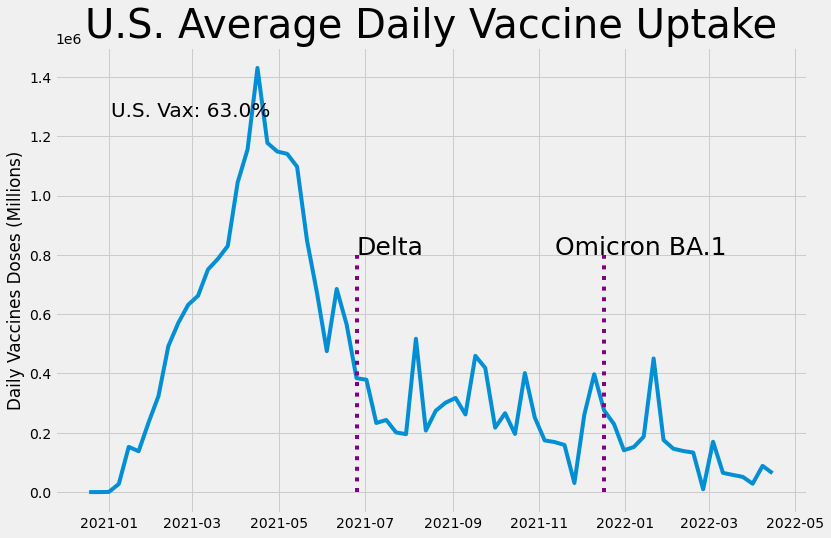

In [25]:
fontsize = 20


if True:
    base_name = "us_new_vax_timeline"
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()

    df['vax_day'] = (((df['vax_ct'].diff().fillna(0)) / 7) ).astype(int)

    df['vax_day'] = df['vax_day'].replace(df['vax_day'].max(),df['vax_day'].mean())

    #display(df[['Date','vax_day','vax_pct']])
    plt.figure(figsize=(12, 8))
    plt.plot(df['Date'],df['vax_day'])
    plt.title(f"U.S. Average Daily Vaccine Uptake",fontsize=fontsize*2)
    plt.ylabel('Daily Vaccines Doses (Millions)')
    
    x_col = "Date"
    y_col = "vax_day"
    vax_pct = "vax_pct"
    for i in range(2,(len(df[y_col]))):
        filename=f"{str(i).zfill(3)}_{base_name}_{df['Date'].iloc[i].date()}.png"
        clear_output(wait=True)
        print("Rendering:",filename)
        plt.figure(figsize=(12, 8))
        plt.title(f"U.S. Average Daily Vaccine Uptake",fontsize=fontsize*2)
        plt.ylabel('Daily Vaccines Doses (Millions)')
        plt.plot(df[x_col].iloc[:i],df[y_col].iloc[:i])
        plt.annotate(f"U.S. Vax: {str(round(df[vax_pct].iloc[i],2)*100)[:4]}%",(0.075,.85),xycoords='axes fraction',fontsize=fontsize)

        if pd.to_datetime('2021-07-02') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-07-02',ymax=800000,offset=1,text="Delta",col=vax_pct,fontsize=fontsize*1.25)
            
        if pd.to_datetime('2021-12-24') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-12-24',ymax=800000,offset=6,text="Omicron BA.1",col=vax_pct,fontsize=fontsize*1.25)

            #plt.vlines(x = df[df['Date'] == '2021-07-02']['Date'], ymin=0, ymax=800000, color='purple', linestyle="dotted")
            #plt.text(df[df['Date'] == '2021-07-02']['Date']- pd.Timedelta(3, unit='W'),800000,"Delta")
        
        plt.savefig(project_dir.joinpath(filename))
        plt.show()

        plt.close()



Rendering: 0070_us_new_cases_timeline_2022-04-22.jpg
28   2021-07-02
Name: Date, dtype: datetime64[ns]
53   2021-12-24
Name: Date, dtype: datetime64[ns]


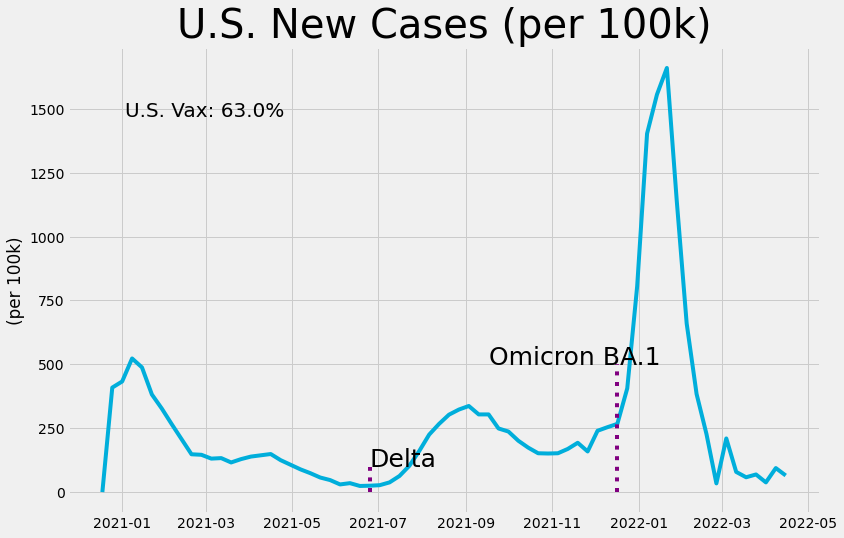

In [26]:
if True:

    base_name = "us_new_cases_timeline"
    y_col = 'New_Confirm_100k'
    ylabel_text = "(per 100k)"
    title = "U.S. New Cases (per 100k)"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)

    for i in range(2,(len(df[y_col]))):
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        clear_output(wait=True)
        print("Rendering:",filename)
        plt.figure(figsize=(12, 8))
        plt.title(title,fontsize=fontsize*2)
        plt.ylabel(ylabel_text)
        plt.plot(df[x_col].iloc[:i],df[y_col].iloc[:i],color=color_dict['c'])
        plt.annotate(f"U.S. Vax: {str(round(df[vax_pct].iloc[i],2)*100)[:4]}%",(0.075,.85),xycoords='axes fraction',fontsize=fontsize)

        if pd.to_datetime('2021-07-02') <=  df[x_col].iloc[:i].max():
            plot_add_date_markers(df,date='2021-07-02',ymax=100,offset=1,text="Delta",col=vax_pct,fontsize=fontsize*1.25)

        if pd.to_datetime('2021-12-24') <=  df[x_col].iloc[:i].max():
            plot_add_date_markers(df,date='2021-12-24',ymax=500,offset=14,text="Omicron BA.1",col=vax_pct,fontsize=fontsize*1.25)

            #plt.vlines(x = df[df['Date'] == '2021-07-02']['Date'], ymin=0, ymax=800000, color='purple', linestyle="dotted")
            #plt.text(df[df['Date'] == '2021-07-02']['Date']- pd.Timedelta(3, unit='W'),800000,"Delta")

        plt.savefig(project_dir.joinpath(filename))
        plt.show()




Rendering: 0070_us_new_hosp_timeline_2022-04-22.jpg
28   2021-07-02
Name: Date, dtype: datetime64[ns]
53   2021-12-24
Name: Date, dtype: datetime64[ns]


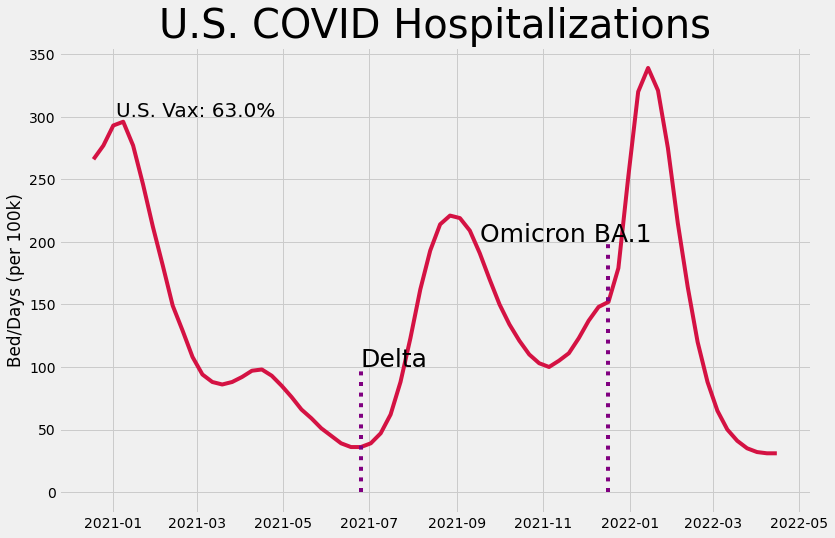

In [27]:
if True:

    base_name = "us_new_hosp_timeline"
    y_col = 'beds_covid_100k'
    ylabel_text = "Bed/Days (per 100k)"
    title = "U.S. COVID Hospitalizations"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)

    for i in range(2,(len(df[y_col]))):
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        clear_output(wait=True)
        print("Rendering:",filename)
        plt.figure(figsize=(12, 8))
        plt.title(title,fontsize=fontsize*2)
        plt.ylabel(ylabel_text)
        plt.plot(df[x_col].iloc[:i],df[y_col].iloc[:i],color=color_dict['h'])
        plt.annotate(f"U.S. Vax: {str(round(df[vax_pct].iloc[i],2)*100)[:4]}%",(0.075,.85),xycoords='axes fraction',fontsize=fontsize)

        if pd.to_datetime('2021-07-02') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-07-02',ymax=100,offset=1,text="Delta",col=vax_pct,fontsize=fontsize*1.25)

        if pd.to_datetime('2021-12-24') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-12-24',ymax=200,offset=14,text="Omicron BA.1",col=vax_pct,fontsize=fontsize*1.25)

            #plt.vlines(x = df[df['Date'] == '2021-07-02']['Date'], ymin=0, ymax=800000, color='purple', linestyle="dotted")
            #plt.text(df[df['Date'] == '2021-07-02']['Date']- pd.Timedelta(3, unit='W'),800000,"Delta")

        plt.savefig(project_dir.joinpath(filename))
        plt.show()




Rendering: 0070_us_new_icu_timeline_2022-04-22.jpg
28   2021-07-02
Name: Date, dtype: datetime64[ns]
53   2021-12-24
Name: Date, dtype: datetime64[ns]


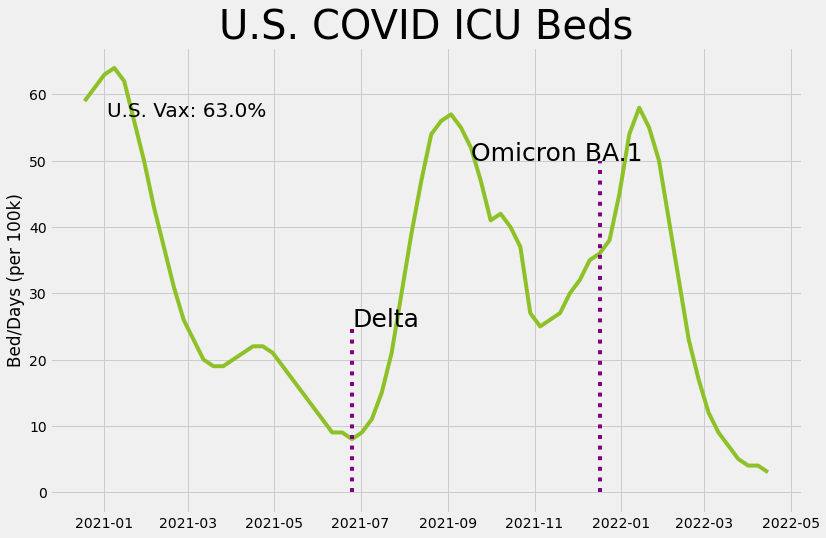

In [28]:

if True:

    base_name = "us_new_icu_timeline"
    y_col = 'icu_covid_100k'
    ylabel_text = "Bed/Days (per 100k)"
    title = "U.S. COVID ICU Beds"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)

    for i in range(2,(len(df[y_col]))):
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        clear_output(wait=True)
        print("Rendering:",filename)
        plt.figure(figsize=(12, 8))
        plt.title(title,fontsize=fontsize*2)
        plt.ylabel(ylabel_text)
        plt.plot(df[x_col].iloc[:i],df[y_col].iloc[:i],color=color_dict['i'])
        plt.annotate(f"U.S. Vax: {str(round(df[vax_pct].iloc[i],2)*100)[:4]}%",(0.075,.85),xycoords='axes fraction',fontsize=fontsize)

        if pd.to_datetime('2021-07-02') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-07-02',ymax=25,offset=1,text="Delta",col=vax_pct,fontsize=fontsize*1.25)

        if pd.to_datetime('2021-12-24') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-12-24',ymax=50,offset=14,text="Omicron BA.1",col=vax_pct,fontsize=fontsize*1.25)

            #plt.vlines(x = df[df['Date'] == '2021-07-02']['Date'], ymin=0, ymax=800000, color='purple', linestyle="dotted")
            #plt.text(df[df['Date'] == '2021-07-02']['Date']- pd.Timedelta(3, unit='W'),800000,"Delta")

        plt.savefig(project_dir.joinpath(filename))
        plt.show()
        



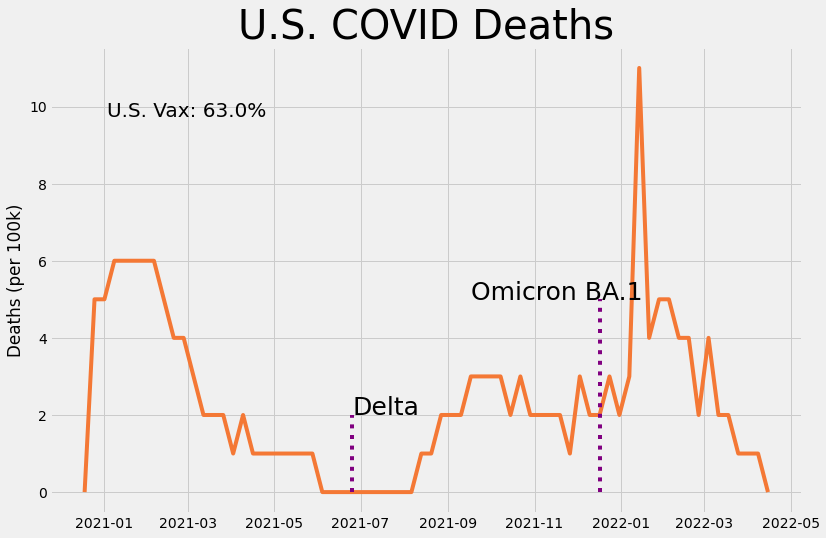

In [29]:

if True:

    base_name = "us_new_death_timeline"
    y_col = 'New_Deaths_100k'
    ylabel_text = "Deaths (per 100k)"
    title = "U.S. COVID Deaths"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)

    for i in range(2,(len(df[y_col]))):
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        
        print("Rendering:",filename)
        plt.figure(figsize=(12, 8))
        plt.title(title,fontsize=fontsize*2)
        plt.ylabel(ylabel_text)
        plt.plot(df[x_col].iloc[:i],df[y_col].iloc[:i],color=color_dict['d'])
        plt.annotate(f"U.S. Vax: {str(round(df[vax_pct].iloc[i],2)*100)[:4]}%",(0.075,.85),xycoords='axes fraction',fontsize=fontsize)

        if pd.to_datetime('2021-07-02') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-07-02',ymax=2,offset=1,text="Delta",col=vax_pct,fontsize=fontsize*1.25)

        if pd.to_datetime('2021-12-24') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-12-24',ymax=5,offset=14,text="Omicron BA.1",col=vax_pct,fontsize=fontsize*1.25)

            #plt.vlines(x = df[df['Date'] == '2021-07-02']['Date'], ymin=0, ymax=800000, color='purple', linestyle="dotted")
            #plt.text(df[df['Date'] == '2021-07-02']['Date']- pd.Timedelta(3, unit='W'),800000,"Delta")

        clear_output(wait=True)
        plt.savefig(project_dir.joinpath(filename))
        plt.show()




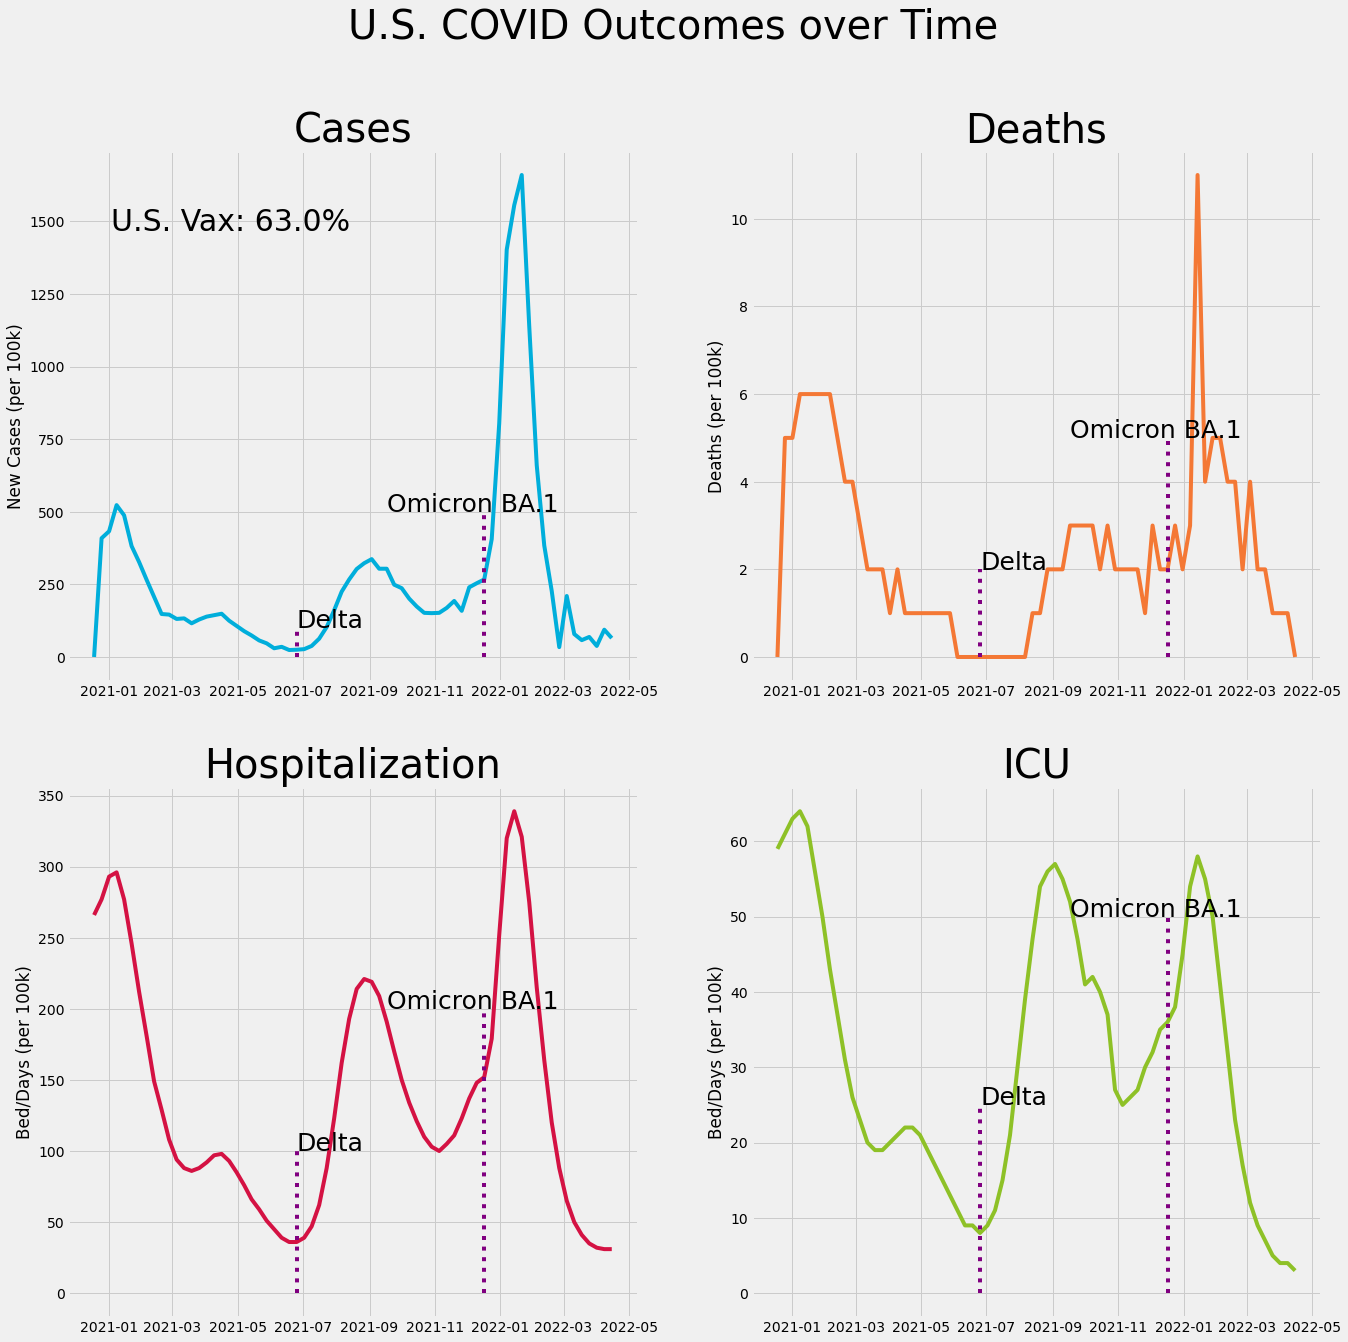

In [30]:
from PIL import Image

if True:
    base_name = "us_new_quad_timeline"
        

    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)
    gif_files = []
    first = True
    for i in range(2,(len(df))):
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        
        print("Rendering:",filename)
        plt.figure(figsize=(20, 20))
        plt.suptitle("U.S. COVID Outcomes over Time",fontsize=fontsize*2)
        
        plt.subplot(2,2,1)
        y_col = 'New_Confirm_100k'
        ylabel_text = "New Cases (per 100k)"
        title = "Cases"
        
        
        plt.title(title,fontsize=fontsize*2)
        plt.ylabel(ylabel_text)
        plt.plot(df[x_col].iloc[:i],df[y_col].iloc[:i],color=color_dict['c'])
        plt.annotate(f"U.S. Vax: {str(round(df[vax_pct].iloc[i],2)*100)[:4]}%",(0.075,.85),xycoords='axes fraction',fontsize=fontsize*1.5)

        if pd.to_datetime('2021-07-02') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-07-02',ymax=100,offset=1,text="Delta",col=vax_pct,fontsize=fontsize*1.25)

        if pd.to_datetime('2021-12-24') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-12-24',ymax=500,offset=14,text="Omicron BA.1",col=vax_pct,fontsize=fontsize*1.25)



        plt.subplot(2,2,2)
        y_col = 'New_Deaths_100k'
        ylabel_text = "Deaths (per 100k)"
        title = "Deaths"
        
        
        plt.title(title,fontsize=fontsize*2)
        plt.ylabel(ylabel_text)
        plt.plot(df[x_col].iloc[:i],df[y_col].iloc[:i],color=color_dict['d'])
        #plt.annotate(f"U.S. Vax: {str(round(df[vax_pct].iloc[i],2)*100)[:4]}%",(0.075,.85),xycoords='axes fraction',fontsize=fontsize)

        if pd.to_datetime('2021-07-02') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-07-02',ymax=2,offset=1,text="Delta",col=vax_pct,fontsize=fontsize*1.25)

        if pd.to_datetime('2021-12-24') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-12-24',ymax=5,offset=14,text="Omicron BA.1",col=vax_pct,fontsize=fontsize*1.25)

            #plt.vlines(x = df[df['Date'] == '2021-07-02']['Date'], ymin=0, ymax=800000, color='purple', linestyle="dotted")
            #plt.text(df[df['Date'] == '2021-07-02']['Date']- pd.Timedelta(3, unit='W'),800000,"Delta")

        plt.subplot(2,2,3)
        y_col = 'beds_covid_100k'
        ylabel_text = "Bed/Days (per 100k)"
        title = "Hospitalization"
        
        
        plt.title(title,fontsize=fontsize*2)
        plt.ylabel(ylabel_text)
        plt.plot(df[x_col].iloc[:i],df[y_col].iloc[:i],color=color_dict['h'])
        #plt.annotate(f"U.S. Vax: {str(round(df[vax_pct].iloc[i],2)*100)[:4]}%",(0.075,.85),xycoords='axes fraction',fontsize=fontsize)

        if pd.to_datetime('2021-07-02') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-07-02',ymax=100,offset=1,text="Delta",col=vax_pct,fontsize=fontsize*1.25)

        if pd.to_datetime('2021-12-24') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-12-24',ymax=200,offset=14,text="Omicron BA.1",col=vax_pct,fontsize=fontsize*1.25)

            #plt.vlines(x = df[df['Date'] == '2021-07-02']['Date'], ymin=0, ymax=800000, color='purple', linestyle="dotted")
            #plt.text(df[df['Date'] == '2021-07-02']['Date']- pd.Timedelta(3, unit='W'),800000,"Delta")
        plt.subplot(2,2,4)
        y_col = 'icu_covid_100k'
        ylabel_text = "Bed/Days (per 100k)"
        title = "ICU"
        
        
        plt.title(title,fontsize=fontsize*2)
        plt.ylabel(ylabel_text)
        plt.plot(df[x_col].iloc[:i],df[y_col].iloc[:i],color=color_dict['i'])
        #plt.annotate(f"U.S. Vax: {str(round(df[vax_pct].iloc[i],2)*100)[:4]}%",(0.075,.85),xycoords='axes fraction',fontsize=fontsize)

        if pd.to_datetime('2021-07-02') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-07-02',ymax=25,offset=1,text="Delta",col=vax_pct,fontsize=fontsize*1.25)

        if pd.to_datetime('2021-12-24') <=  df[x_col].iloc[i]:
            plot_add_date_markers(df,date='2021-12-24',ymax=50,offset=14,text="Omicron BA.1",col=vax_pct,fontsize=fontsize*1.25)

            #plt.vlines(x = df[df['Date'] == '2021-07-02']['Date'], ymin=0, ymax=800000, color='purple', linestyle="dotted")
            #plt.text(df[df['Date'] == '2021-07-02']['Date']- pd.Timedelta(3, unit='W'),800000,"Delta")
        
        
        plt.savefig(project_dir.joinpath(filename))
        
        #//*** Read Files and Prepare Animated GID
        #if first == True:
        #    first=False
        #    first_img = Image.open(project_dir.joinpath(filename))
        #else:
        #    gif_files.append(Image.open(project_dir.joinpath(filename)) )
        
        clear_output(wait=True)
        plt.show()
        plt.close()
    

    #print("Building GIF...")

    #//*** Build and Save Animated GIF
    #gif_filename = f"{base_name}.gif"
    #first_img.save(gif_filename, save_all=True, optimize=False, append_images=gif_files, duration=150, loop=1)
    #del first
    #del gif files


# Matplotlib Color Maps #
https://matplotlib.org/stable/tutorials/colors/colormapnorms.html

In [31]:
cd.get('us_cdvh_df').columns

Index(['Date', 'state', 'pop', 'vax_ct', 'tot_confirm', 'tot_deaths',
       'beds_covid', 'icu_covid', 'beds_used', 'all_icu', 'vax_pct',
       'New_Confirm', 'New_Deaths', 'pv_New_Confirm_tot', 'pv_New_Deaths_tot',
       'beds_covid_tot', 'icu_covid_tot', 'beds_tot', 'beds_used_tot',
       'all_icu_tot', 'icu_used_tot', 'pv_beds_covid_tot', 'pv_icu_covid_tot',
       'pv_beds_tot', 'pv_beds_used_tot', 'pv_all_icu_tot', 'pv_icu_used_tot',
       'tot_confirm_100k', 'tot_deaths_100k', 'New_Confirm_100k',
       'New_Deaths_100k', 'pv_New_Confirm_tot_100k', 'pv_New_Deaths_tot_100k',
       'beds_covid_100k', 'icu_covid_100k', 'beds_covid_tot_100k',
       'icu_covid_tot_100k', 'pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',
       'vax_ct_100k', 'pv_beds_tot_100k', 'pv_beds_used_tot_100k',
       'pv_all_icu_tot_100k', 'pv_icu_used_tot_100k', 'all_bed_util',
       'covid_bed_util', 'icu_util', 'icu_covid_util', 'vcr', 'vdr', 'vbr',
       'vir'],
      dtype='object')

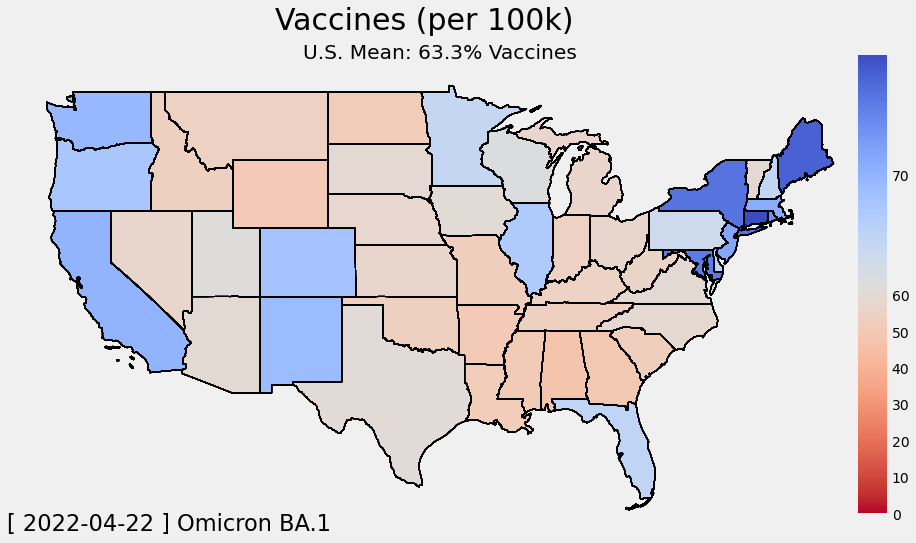

In [32]:
if True:
    reload(process_covid)
    base_name = "state_geo_vax_timeline"
    
    column ='vax_pct'
    title = "Vaccines (per 100k)"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('state_cvdh_df').copy()
    df['vax_pct'] = df['vax_pct'] * 100

    cmap = cm.coolwarm
    geo_df = cd.get("state_geo_df").copy()

    master_geo_df = geo_df.merge(df,left_on="NAME",right_on="state")
    
    for i in range(2,len(df['Date'].unique())):
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        
        center =  round(cd.get('us_cdvh_df')[column].iloc[i],3)*100
        
        date_list = master_geo_df['Date'].iloc[:i+1]

        #//*** Get geo subset of just the current dates
        geo_df = master_geo_df[master_geo_df['Date'].isin(date_list)]

        process_covid.qgeo(geo_df, 
            column=column,
            vcenter=center,
            suptitle=title,
            title=f"U.S. Mean: {str(center)[:4]}% Vaccines",
            cmap='coolwarm',
            figsize=(15,8),
            reverse=True,
            std=3,
            return_ax=True,
            timelapse=True

            )
        plt.savefig(project_dir.joinpath(filename))
        clear_output(wait=True)

        plt.show()
                
        



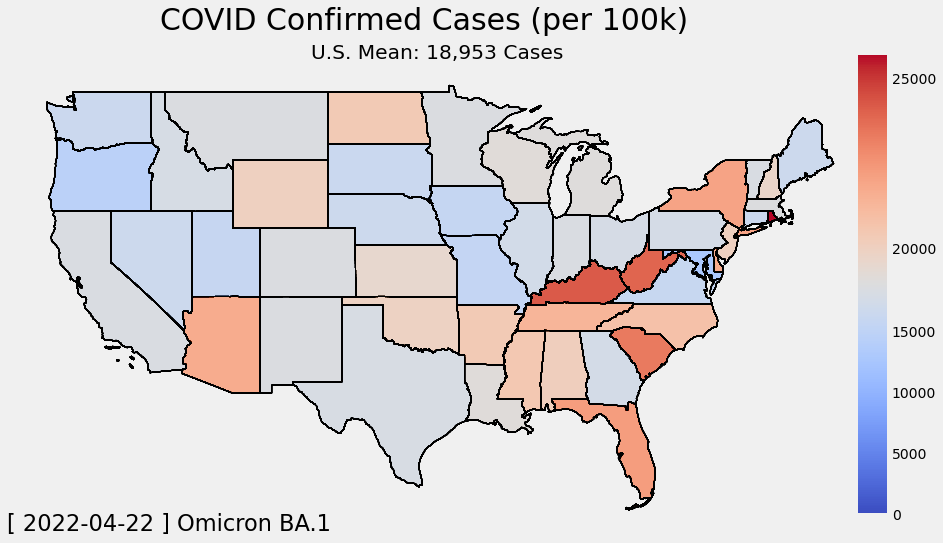

In [33]:

if True:
    reload(process_covid)
    base_name = "state_geo_confirm_timeline"
    
    column ='pv_New_Confirm_tot_100k'
    suptitle="COVID Confirmed Cases (per 100k)"
    
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('state_cvdh_df').copy()
    df['vax_pct'] = df['vax_pct'] * 100

    cmap = cm.coolwarm
    geo_df = cd.get("state_geo_df").copy()

    master_geo_df = geo_df.merge(df,left_on="NAME",right_on="state")
    
    for i in range(2,len(master_geo_df['Date'].unique())):
        filename=f"{str(i).zfill(4)}_{base_name}_{master_geo_df['Date'].iloc[i].date()}.jpg".format(100)
        
        center =  round(cd.get('us_cdvh_df')[column].iloc[i],3)
        
        date_list = master_geo_df['Date'].iloc[:i+1]

        #//*** Get geo subset of just the current dates
        geo_df = master_geo_df[master_geo_df['Date'].isin(date_list)]

        process_covid.qgeo(geo_df, 
            column=column,
            vcenter=center,
            suptitle=suptitle,
            title=f"U.S. Mean: {center:,} Cases ",
            cmap='coolwarm',
            figsize=(15,8),
            reverse=False,
            std=3.5,
            return_ax=True,
            timelapse=True

            )
        plt.savefig(project_dir.joinpath(filename))
        clear_output(wait=True)

        plt.show()
                
        



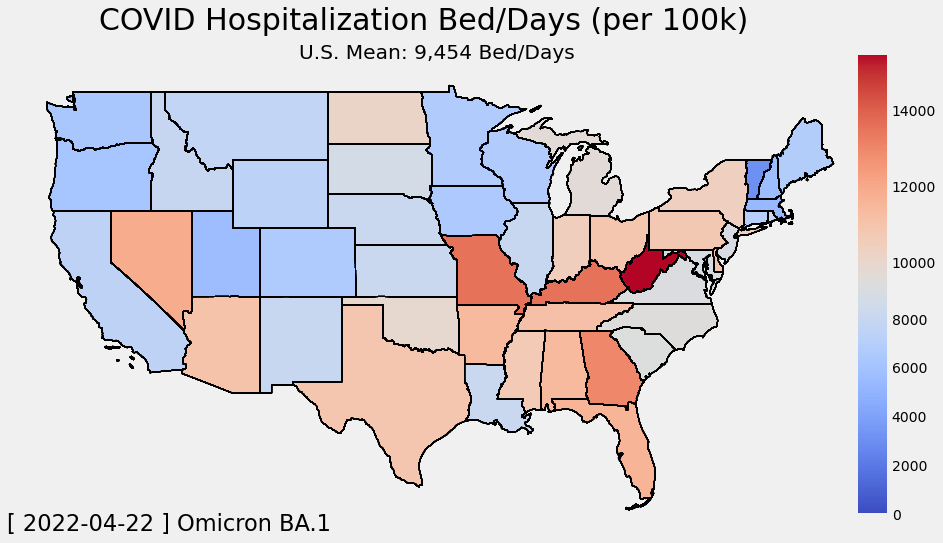

In [34]:
   
if True:
    reload(process_covid)
    base_name = "state_geo_hosp_timeline"
    
    column ='pv_beds_covid_tot_100k'
    suptitle="COVID Hospitalization Bed/Days (per 100k)"
    
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('state_cvdh_df').copy()
    df['vax_pct'] = df['vax_pct'] * 100

    cmap = cm.coolwarm
    geo_df = cd.get("state_geo_df").copy()

    master_geo_df = geo_df.merge(df,left_on="NAME",right_on="state")
    
    for i in range(2,len(master_geo_df['Date'].unique())):
        filename=f"{str(i).zfill(4)}_{base_name}_{master_geo_df['Date'].iloc[i].date()}.jpg".format(100)
        
        center =  round(cd.get('us_cdvh_df')[column].iloc[i],3)
        
        date_list = master_geo_df['Date'].iloc[:i+1]

        #//*** Get geo subset of just the current dates
        geo_df = master_geo_df[master_geo_df['Date'].isin(date_list)]

        process_covid.qgeo(geo_df, 
            column=column,
            vcenter=center,
            suptitle=suptitle,
            title=f"U.S. Mean: {center:,} Bed/Days ",
            cmap='coolwarm',
            figsize=(15,8),
            reverse=False,
            std=3.5,
            return_ax=True,
            timelapse=True

            )
        plt.savefig(project_dir.joinpath(filename))
        clear_output(wait=True)

        plt.show()
                

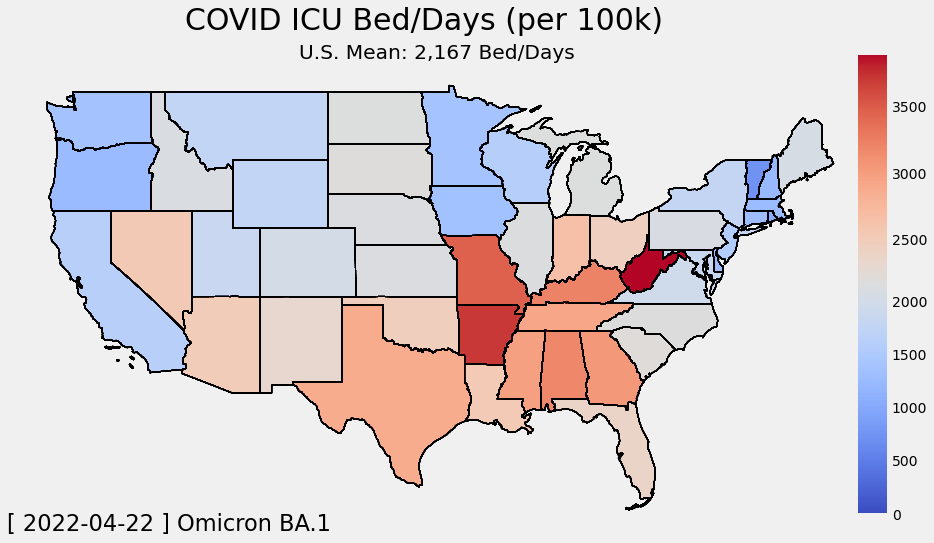

In [35]:
   
if True:
    reload(process_covid)
    base_name = "state_geo_icu_timeline"
    
    column ='pv_icu_covid_tot_100k'
    suptitle="COVID ICU Bed/Days (per 100k)"
    
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('state_cvdh_df').copy()
    df['vax_pct'] = df['vax_pct'] * 100

    cmap = cm.coolwarm
    geo_df = cd.get("state_geo_df").copy()

    master_geo_df = geo_df.merge(df,left_on="NAME",right_on="state")
    
    for i in range(2,len(master_geo_df['Date'].unique())):
        filename=f"{str(i).zfill(4)}_{base_name}_{master_geo_df['Date'].iloc[i].date()}.jpg".format(100)
        
        center =  round(cd.get('us_cdvh_df')[column].iloc[i],3)
        
        date_list = master_geo_df['Date'].iloc[:i+1]

        #//*** Get geo subset of just the current dates
        geo_df = master_geo_df[master_geo_df['Date'].isin(date_list)]

        process_covid.qgeo(geo_df, 
            column=column,
            vcenter=center,
            suptitle=suptitle,
            title=f"U.S. Mean: {center:,} Bed/Days ",
            cmap='coolwarm',
            figsize=(15,8),
            reverse=False,
            std=3.5,
            return_ax=True,
            timelapse=True

            )
        plt.savefig(project_dir.joinpath(filename))
        clear_output(wait=True)

        plt.show()
                

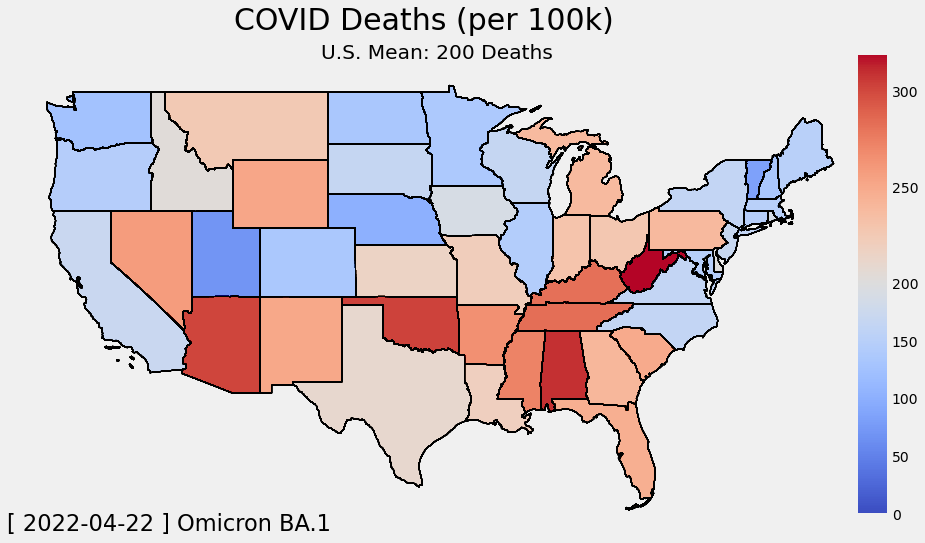

In [36]:
   
if True:
    reload(process_covid)
    base_name = "state_geo_death_timeline"
    
    column ='pv_New_Deaths_tot_100k'
    suptitle="COVID Deaths (per 100k)"
    
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('state_cvdh_df').copy()
    df['vax_pct'] = df['vax_pct'] * 100

    cmap = cm.coolwarm
    geo_df = cd.get("state_geo_df").copy()

    master_geo_df = geo_df.merge(df,left_on="NAME",right_on="state")
    
    for i in range(2,len(master_geo_df['Date'].unique())):
        filename=f"{str(i).zfill(4)}_{base_name}_{master_geo_df['Date'].iloc[i].date()}.jpg".format(100)
        
        center =  round(cd.get('us_cdvh_df')[column].iloc[i],3)
        
        date_list = master_geo_df['Date'].iloc[:i+1]

        #//*** Get geo subset of just the current dates
        geo_df = master_geo_df[master_geo_df['Date'].isin(date_list)]

        process_covid.qgeo(geo_df, 
            column=column,
            vcenter=center,
            suptitle=suptitle,
            title=f"U.S. Mean: {center:,} Deaths ",
            cmap='coolwarm',
            figsize=(15,8),
            reverse=False,
            std=3.5,
            return_ax=True,
            timelapse=True

            )
        plt.savefig(project_dir.joinpath(filename))
        clear_output(wait=True)

        plt.show()
               

-  [Build state_cvdh_df](#build-state_cvdh_df).

In [90]:
df = cd.get('state_cvdh_df').copy()
df['vax_pct'] = df['vax_pct'] * 100

df

Date    state        pop    vax_ct  tot_confirm  tot_deaths  \
0  2020-12-18  Alabama  4789955.0       0.0     308218.0      4163.0   
1  2020-12-25  Alabama  4789955.0       0.0     334449.0      4537.0   
2  2021-01-01  Alabama  4789955.0       0.0     357264.0      4728.0   
3  2021-01-08  Alabama  4789955.0    1375.0     385200.0      5023.0   
4  2021-01-15  Alabama  4789955.0   12302.0     407961.0      5835.0   
..        ...      ...        ...       ...          ...         ...   
66 2022-03-25  Wyoming   568928.0  282903.0     154133.0      1756.0   
67 2022-04-01  Wyoming   568928.0  283356.0     154243.0      1764.0   
68 2022-04-08  Wyoming   568928.0  284325.0     154358.0      1769.0   
69 2022-04-15  Wyoming   568928.0  284784.0     154336.0      1774.0   
70 2022-04-22  Wyoming   568928.0  285539.0     154470.0      1780.0   

    beds_covid  icu_covid     beds  beds_used  all_icu  icu_used    vax_pct  \
0      17882.0     4668.0  98411.0    73083.0  15212.0   13069.0   0.000000   
1      19501.0     5183.0  98370.0    71605.0  15128.0   13005.0   0.000000   
2      21504.0     5712.0  97836.0    75318.0  15199.0   13516.0   0.000000   
3      21581.0     5953.0  98002.0    76925.0  15073.0   13578.0   0.028706   
4      19488.0     5717.0  97283.0    75924.0  14850.0   13301.0   0.256829   
..         ...        ...      ...        ...      ...       ...        ...   
66        43.0        2.0   8997.0     3489.0    776.0     284.0  49.725624   
67        72.0        1.0   9409.0     3681.0    815.0     278.0  49.805248   
68        28.0        1.0   9733.0     3786.0    835.0     251.0  49.975568   
69        48.0        0.0   9623.0     3671.0    824.0     257.0  50.056246   
70        42.0        0.0   9659.0     3926.0    827.0     267.0  50.188952   

    New_Confirm  New_Deaths  pv_New_Confirm_tot  pv_New_Deaths_tot  \
0           0.0         0.0                 0.0                0.0   
1       26231.0       374.0             26231.0              374.0   
2       22815.0       191.0             49046.0              565.0   
3       27936.0       295.0             76982.0              860.0   
4       22761.0       812.0             99743.0             1672.0   
..          ...         ...                 ...                ...   
66        149.0        14.0            113336.0             1410.0   
67        110.0         8.0            113446.0             1418.0   
68        115.0         5.0            113561.0             1423.0   
69        -22.0         5.0            113539.0             1428.0   
70        134.0         6.0            113673.0             1434.0   

    beds_covid_tot  icu_covid_tot  beds_tot  beds_used_tot  all_icu_tot  \
0          17882.0         4668.0   98411.0        73083.0      15212.0   
1          37383.0         9851.0  196781.0       144688.0      30340.0   
2          58887.0        15563.0  294617.0       220006.0      45539.0   
3          80468.0        21516.0  392619.0       296931.0      60612.0   
4          99956.0        27233.0  489902.0       372855.0      75462.0   
..             ...            ...       ...            ...          ...   
66         42527.0        10286.0  649829.0       272241.0      58819.0   
67         42599.0        10287.0  659238.0       275922.0      59634.0   
68         42627.0        10288.0  668971.0       279708.0      60469.0   
69         42675.0        10288.0  678594.0       283379.0      61293.0   
70         42717.0        10288.0  688253.0       287305.0      62120.0   

    icu_used_tot  pv_beds_covid_tot  pv_icu_covid_tot  pv_beds_tot  \
0        13069.0                0.0               0.0          0.0   
1        26074.0            19501.0            5183.0      98370.0   
2        39590.0            41005.0           10895.0     196206.0   
3        53168.0            62586.0           16848.0     294208.0   
4        66469.0            82074.0           22565.0     391491.0   
..           ...                .

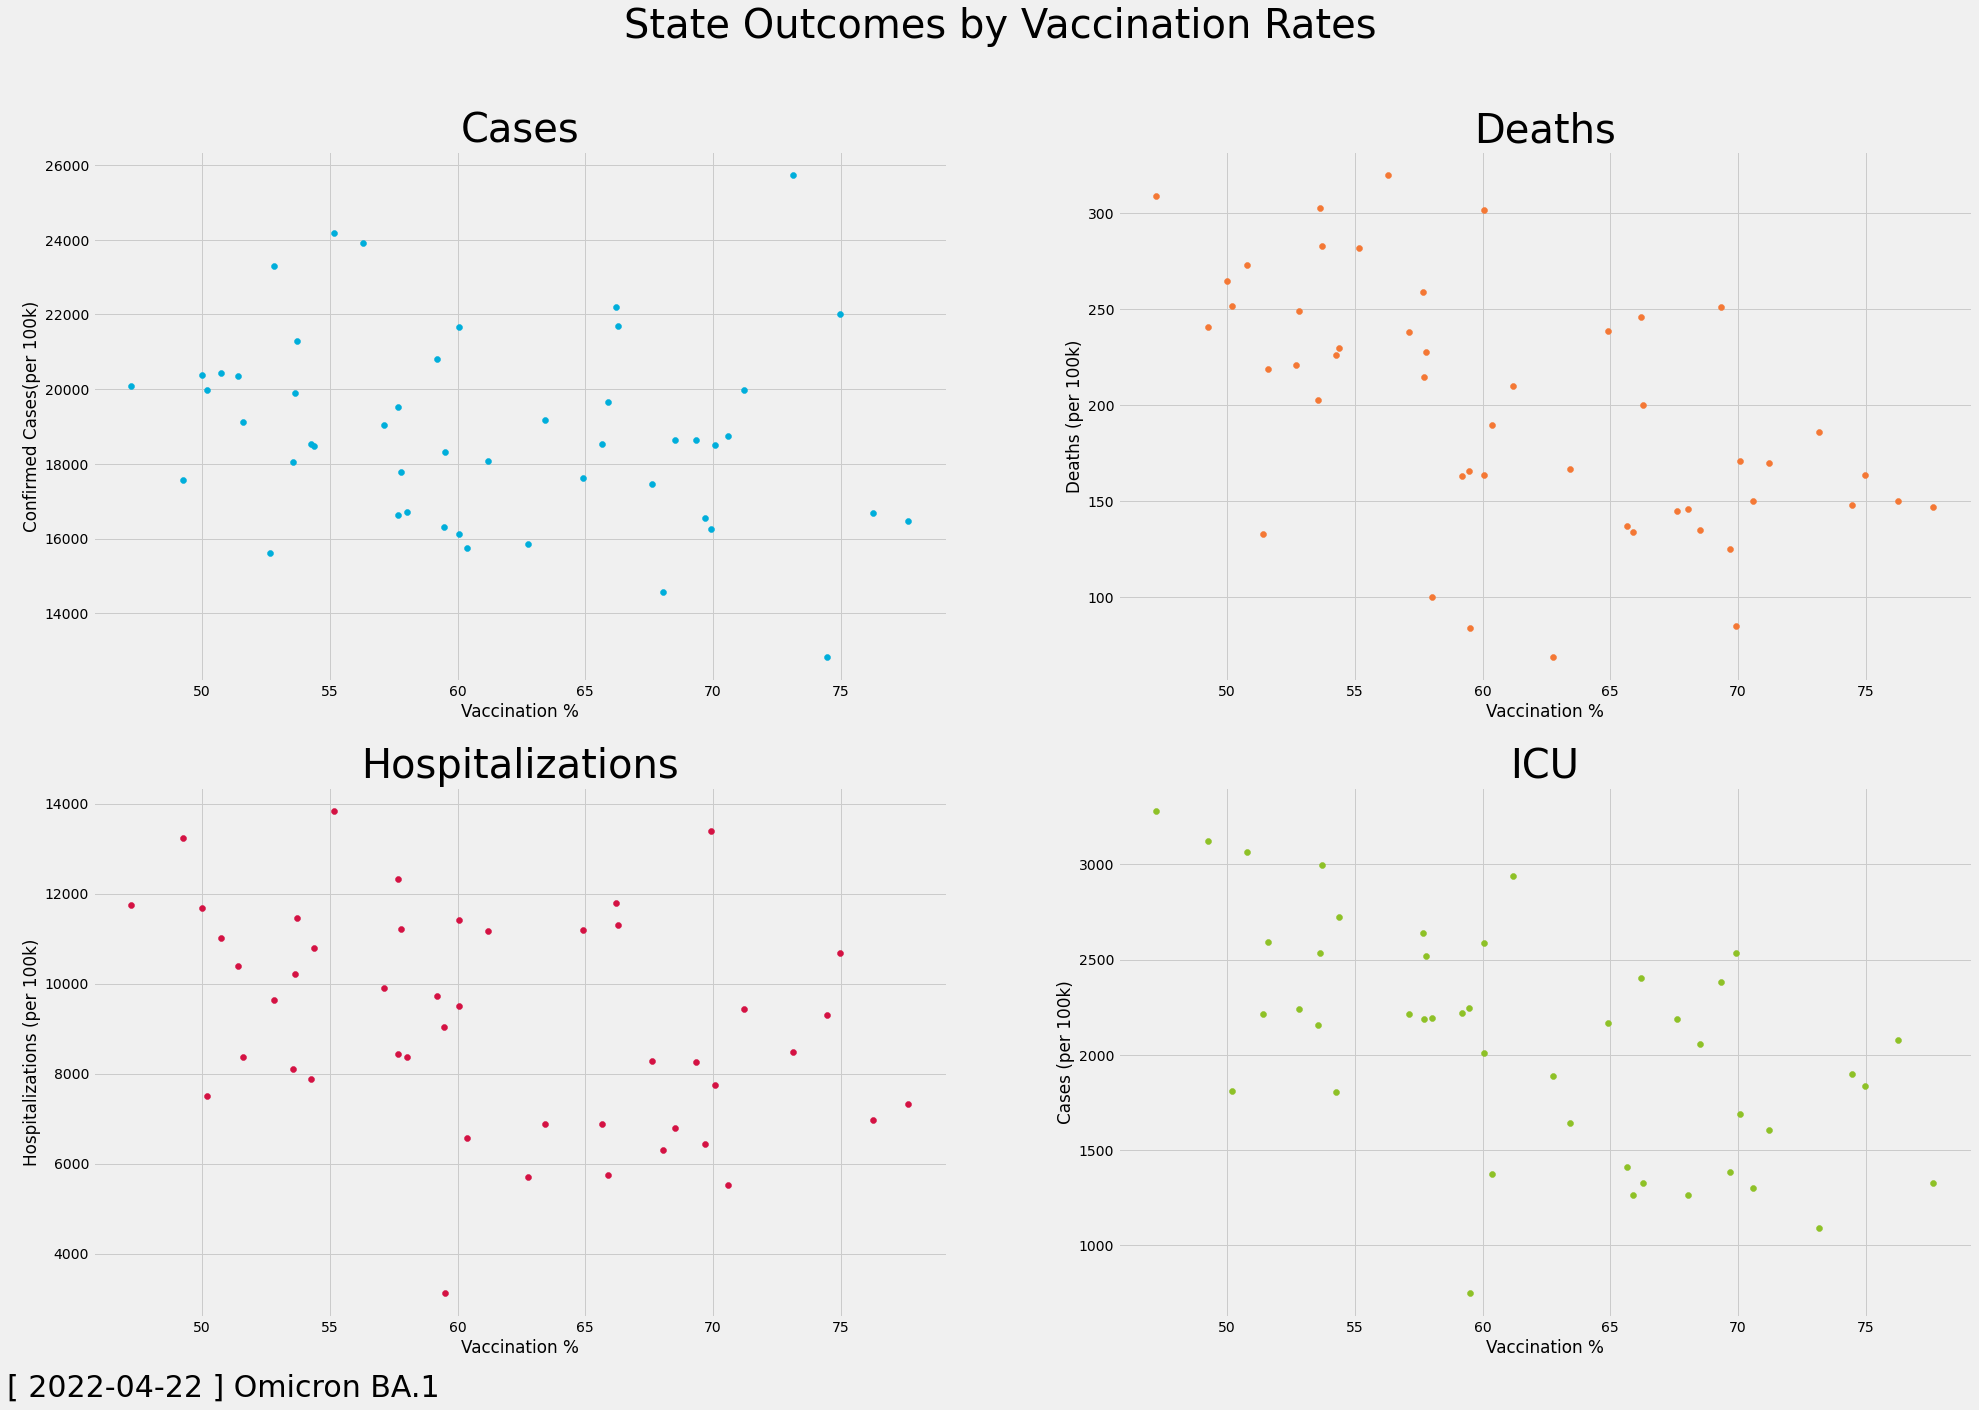

In [25]:
fontsize=20
if True:
    reload(process_covid)
    base_name = "state_date_vax_quad_timeline"
    
    column ='icu_covid_tot_100k'
    title = "ICU by County Vaccination Rate"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)
    
    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass

    df = cd.get('week_cdvh_df').copy()
    


    
    for i in range(2,len(df['Date'].unique())):
        
        #df = cd.get('week_cdvh_df').copy()
        df = cd.get('state_cvdh_df').copy()
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        
        
        
        #//*** Get Current Day
        df= df[df['Date'] == df['Date'].iloc[i]]
        df['vax_pct'] = df['vax_ct'] / df['pop']
        df['vax_pct'] = df['vax_pct'] * 100
        
        
        plt.figure(figsize=(30, 20))
        plt.suptitle("State Outcomes by Vaccination Rates",fontsize=fontsize*2)

        plt.subplot(2, 2, 1)#//*** Left Boxx


        column = 'pv_New_Confirm_tot_100k'


        plt.scatter(df['vax_pct'],df[column],color=color_dict['c'])
        plt.title("Cases",fontsize=fontsize*2)
        plt.xlabel("Vaccination %")
        plt.ylabel("Confirmed Cases(per 100k)")


        




        column = 'pv_New_Deaths_tot_100k'
        df.loc[(df[column] < 0), column] = 0

        plt.subplot(2, 2, 2)#//*** Left Boxx
        plt.scatter(df['vax_pct'],df[column],color=color_dict['d'])
        plt.title("Deaths",fontsize=fontsize*2)
        plt.xlabel("Vaccination %")
        plt.ylabel("Deaths (per 100k)")


        column = 'beds_covid_tot_100k'
        #//*** Remove top two highest values as outliers
        df = df[df[column] < df[column].max()]
        df = df[df[column] < df[column].max()]


        plt.subplot(2, 2, 3)#//*** Left Boxx
        plt.scatter(df['vax_pct'],df[column],color=color_dict['h'])
        plt.title("Hospitalizations",fontsize=fontsize*2)
        plt.xlabel("Vaccination %")
        plt.ylabel("Hospitalizations (per 100k)")

        column = 'icu_covid_tot_100k'
        #//*** Remove top two highest values as outliers
        df = df[df[column] < df[column].max()]
        df = df[df[column] < df[column].max()]

        plt.subplot(2, 2, 4)#//*** Left Boxx
        plt.scatter(df['vax_pct'],df[column],color=color_dict['i'])
        plt.title("ICU",fontsize=fontsize*2)
        plt.xlabel("Vaccination %")
        plt.ylabel("Cases (per 100k)")
        
        coords=(-1.3,-.15)
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",coords,xycoords='axes fraction',fontsize=fontsize*1.5)

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

        clear_output(wait=True)
        plt.show()
        

Rendered 0070_county_geo_vax_timeline_2022-04-22.jpg


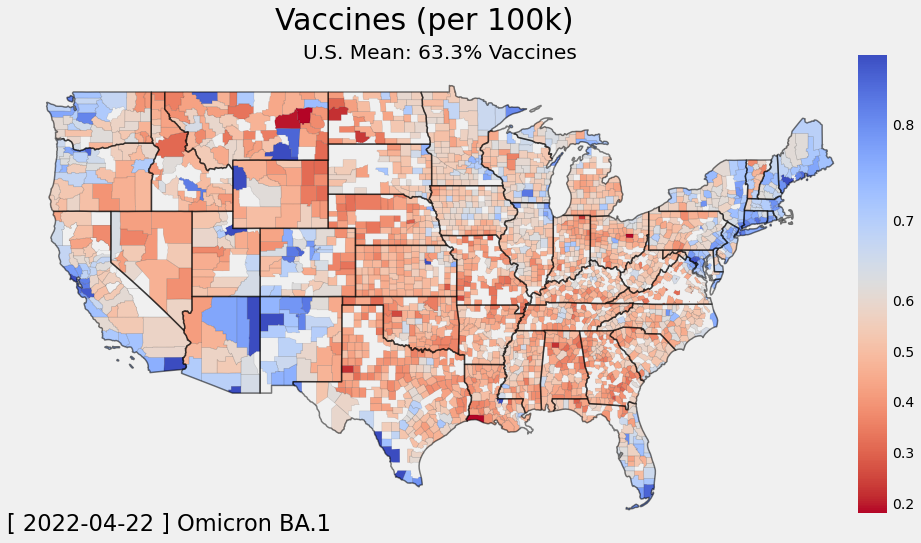

In [38]:
if True:
    reload(process_covid)
    base_name = "county_geo_vax_timeline"
    
    column ='vax_pct'
    suptitle = "Vaccines (per 100k)"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass

    df = cd.get('week_cdvh_df').copy()
    df['vax_pct'] = df['vax_pct'] * 100

    cmap = cm.coolwarm
    
    geo_df = cd.get("county_geo_df").copy()
    master_geo_df = geo_df.merge(df,left_on="GEOID",right_on="FIPS")
    
    for i in range(2,len(df['Date'].unique())):
        
        #reload(process_covid)
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        
        center =  round(cd.get('us_cdvh_df')[column].iloc[i],3)

        

        #//*** Get geo subset of just the current dates
        #geo_df = master_geo_df[master_geo_df['Date'].isin(date_list)].copy()
        geo_df = master_geo_df[master_geo_df['Date'] ==  master_geo_df['Date'].iloc[i]].copy()
        geo_df.loc[(geo_df[column] < 0), column] = 0
        
        geo_df['vax_pct'] = (geo_df['vax_ct'] / geo_df['pop'])
        #print(column,center,df[column].mean(),len(geo_df))
        #print(geo_df[column].describe())
        #display(geo_df[['Date','GEOID','pop','vax_ct','vax_pct']])
        
        process_covid.qgeo(geo_df, 
            column=column,
            vcenter=center,
            suptitle=suptitle,
            title=f"U.S. Mean: {str(center*100)[:4]}% Vaccines",
            cmap='coolwarm',
            figsize=(15,8),
            reverse=True,
            std=3,
            return_ax=True,
            timelapse=True,
            state_geo = cd.get('state_geo_df'),

            )
        plt.savefig(project_dir.joinpath(filename))
        clear_output(wait=True)
        print(f"Rendered {filename}")
        plt.show()
      
        
          
        



Rendered 0070_county_geo_confirm_timeline_2022-04-22.jpg


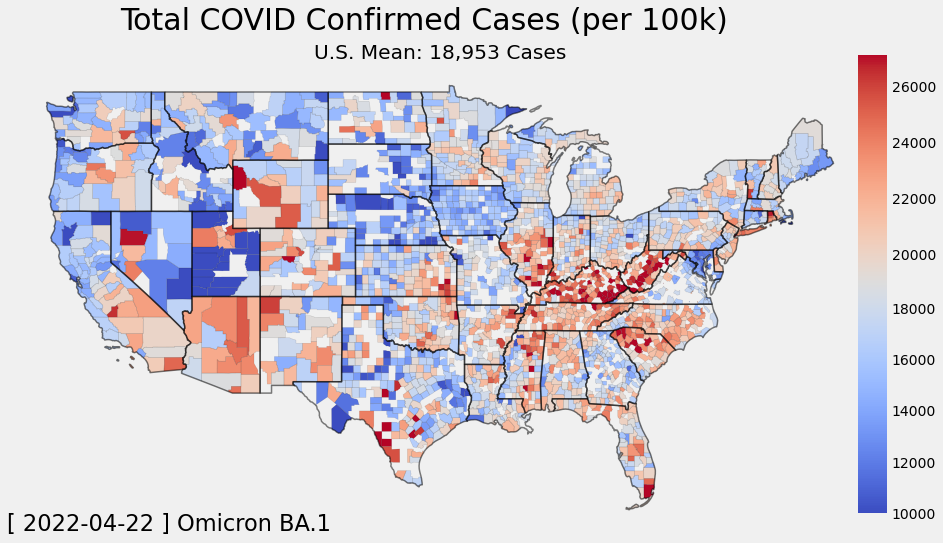

In [39]:
if True:
    reload(process_covid)
    base_name = "county_geo_confirm_timeline"
    
    column ='pv_New_Confirm_tot_100k'
    suptitle = "Total COVID Confirmed Cases (per 100k)"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass

    df = cd.get('week_cdvh_df').copy()
    #df['vax_pct'] = df['vax_pct'] * 100

    cmap = cm.coolwarm
    
    geo_df = cd.get("county_geo_df").copy()
    master_geo_df = geo_df.merge(df,left_on="GEOID",right_on="FIPS")
    
    for i in range(2,len(df['Date'].unique())):
        
        #reload(process_covid)
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        
        center =  round(cd.get('us_cdvh_df')[column].iloc[i],3)
        
        date_list = master_geo_df['Date'].iloc[:i+1]

        #//*** Get geo subset of just the current dates
        #geo_df = master_geo_df[master_geo_df['Date'].isin(date_list)].copy()
        geo_df = master_geo_df[master_geo_df['Date'] ==  master_geo_df['Date'].iloc[i]].copy()
        
        geo_df.loc[(geo_df[column] < 0), column] = 0
        process_covid.qgeo(geo_df, 
            column=column,
            vcenter=center,
            suptitle=suptitle,
            title=f"U.S. Mean: {center:,} Cases",
            cmap='coolwarm',
            figsize=(15,8),
            reverse=False,
            std=2,
            return_ax=True,
            timelapse=True,
            state_geo = cd.get('state_geo_df'),

            )
        plt.savefig(project_dir.joinpath(filename))
        clear_output(wait=True)
        print(f"Rendered {filename}")
        plt.show()
      
        



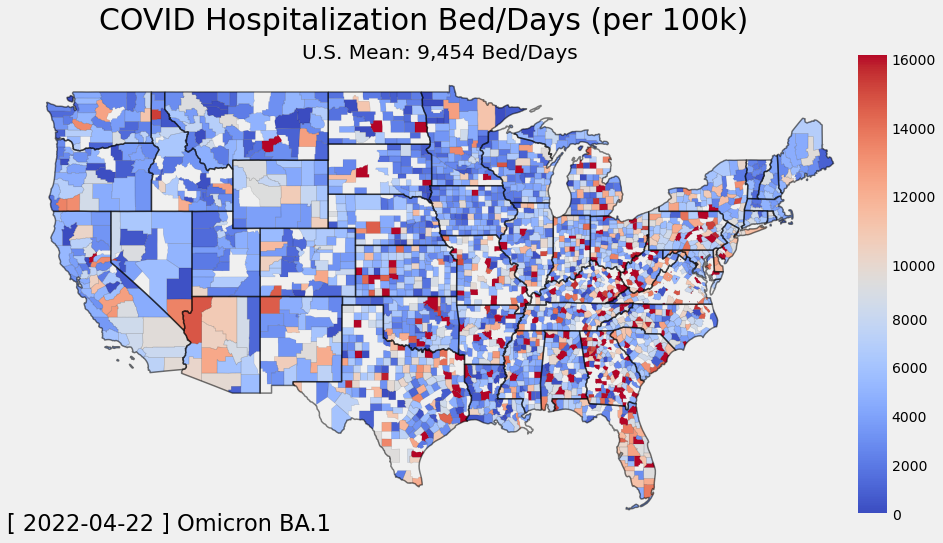

In [40]:
if True:
    reload(process_covid)
    base_name = "county_geo_hosp_timeline"
    
    column ='pv_beds_covid_tot_100k'
    suptitle = "COVID Hospitalization Bed/Days (per 100k)"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('week_cdvh_df').copy()
    #df['vax_pct'] = df['vax_pct'] * 100

    cmap = cm.coolwarm
    
    geo_df = cd.get("county_geo_df").copy()
    master_geo_df = geo_df.merge(df,left_on="GEOID",right_on="FIPS")
    
    for i in range(2,len(df['Date'].unique())):
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        
        center =  round(cd.get('us_cdvh_df')[column].iloc[i],3)
        
        #date_list = master_geo_df['Date'].iloc[:i+1]

        #//*** Get geo subset of just the current dates
        #geo_df = master_geo_df[master_geo_df['Date'].isin(date_list)].copy()
        
        geo_df = master_geo_df[master_geo_df['Date'] ==  master_geo_df['Date'].iloc[i]].copy()
        
        geo_df.loc[(geo_df[column] < 0), column] = 0
        process_covid.qgeo(geo_df, 
            column=column,
            vcenter=center,
            suptitle=suptitle,
            title=f"U.S. Mean: {center:,} Bed/Days",
            cmap='coolwarm',
            figsize=(15,8),
            reverse=False,
            std=1,
            return_ax=True,
            timelapse=True,
            state_geo = cd.get('state_geo_df'),

            )
        plt.savefig(project_dir.joinpath(filename))
        clear_output(wait=True)

        plt.show()
               
        





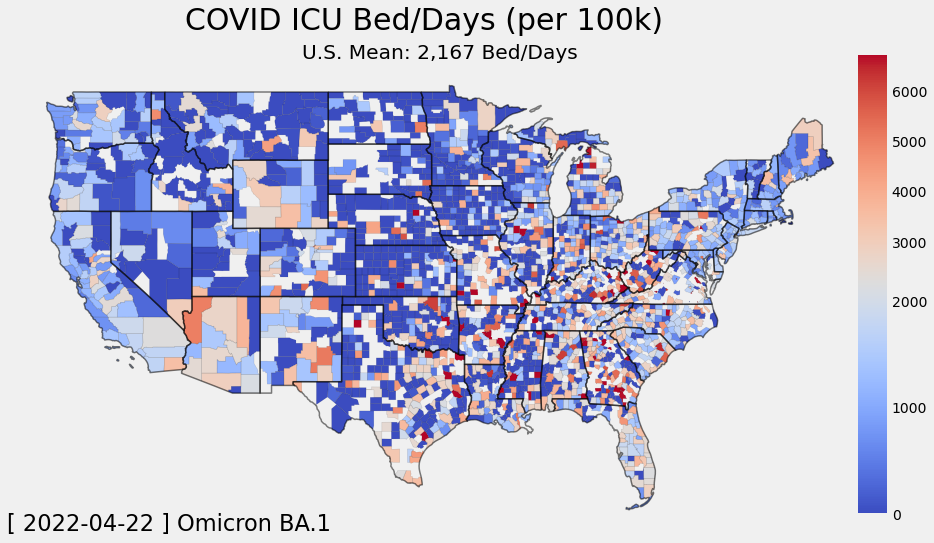

In [41]:

    
if True:
    reload(process_covid)
    base_name = "county_geo_icu_timeline"
    
    column ='pv_icu_covid_tot_100k'
    suptitle = "COVID ICU Bed/Days (per 100k)"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('week_cdvh_df').copy()
    #df['vax_pct'] = df['vax_pct'] * 100

    cmap = cm.coolwarm
    
    geo_df = cd.get("county_geo_df").copy()
    master_geo_df = geo_df.merge(df,left_on="GEOID",right_on="FIPS")
    
    for i in range(2,len(df['Date'].unique())):
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        
        center =  round(cd.get('us_cdvh_df')[column].iloc[i],3)
        
        date_list = master_geo_df['Date'].iloc[:i+1]

        #//*** Get geo subset of just the current dates
        #geo_df = master_geo_df[master_geo_df['Date'].isin(date_list)].copy()
        geo_df = master_geo_df[master_geo_df['Date'] ==  master_geo_df['Date'].iloc[i]].copy()

        geo_df.loc[(geo_df[column] < 0), column] = 0
        process_covid.qgeo(geo_df, 
            column=column,
            vcenter=center,
            suptitle=suptitle,
            title=f"U.S. Mean: {center:,} Bed/Days",
            cmap='coolwarm',
            figsize=(15,8),
            reverse=False,
            std=2,
            return_ax=True,
            timelapse=True,
            state_geo = cd.get('state_geo_df'),

            )
        plt.savefig(project_dir.joinpath(filename))
        clear_output(wait=True)

        plt.show()
               
        





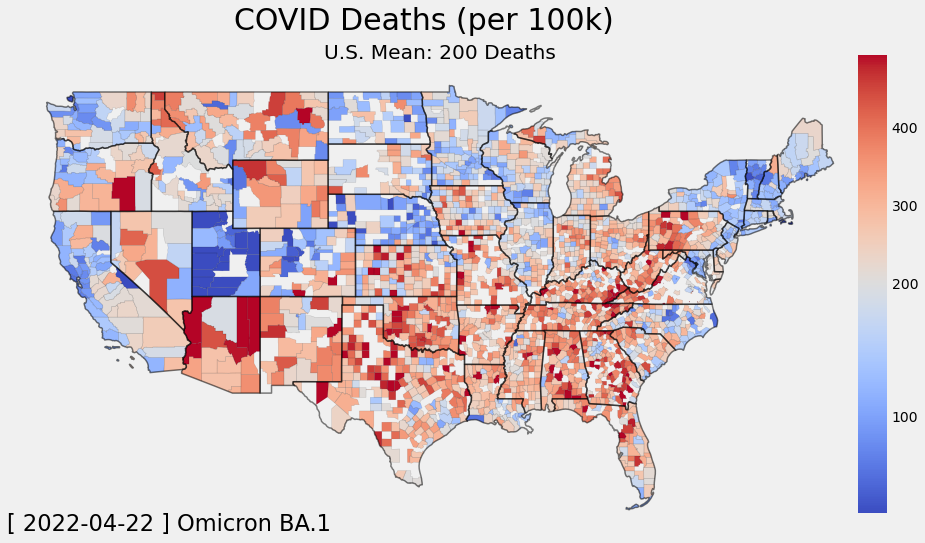

In [66]:
   
if True:
    reload(process_covid)
    base_name = "county_geo_death_timeline"
    
    column ='pv_New_Deaths_tot_100k'
    suptitle = "COVID Deaths (per 100k)"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('week_cdvh_df').copy()
    #df['vax_pct'] = df['vax_pct'] * 100

    cmap = cm.coolwarm
    
    geo_df = cd.get("county_geo_df").copy()
    master_geo_df = geo_df.merge(df,left_on="GEOID",right_on="FIPS")
    
    for i in range(2,len(df['Date'].unique())):
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        
        center =  round(cd.get('us_cdvh_df')[column].iloc[i],3)
        
        date_list = master_geo_df['Date'].iloc[:i+1]

        #//*** Get geo subset of just the current dates
        #geo_df = master_geo_df[master_geo_df['Date'].isin(date_list)].copy()
        geo_df = master_geo_df[master_geo_df['Date'] ==  master_geo_df['Date'].iloc[i]].copy()

        geo_df.loc[(geo_df[column] < 0), column] = 0
        process_covid.qgeo(geo_df, 
            column=column,
            vcenter=center,
            suptitle=suptitle,
            title=f"U.S. Mean: {center:,} Deaths",
            cmap='coolwarm',
            figsize=(15,8),
            reverse=False,
            std=2,
            return_ax=True,
            timelapse=True,
            state_geo = cd.get('state_geo_df'),

            )
        plt.savefig(project_dir.joinpath(filename))
        clear_output(wait=True)

        plt.show()
                   


Index(['Date', 'FIPS', 'Recip_State', 'vax_pct', 'vax_ct', 'cty',
       'Combined_Key', 'pop', 'tot_confirm', 'tot_deaths', 'New_Confirm',
       'New_Deaths', 'state', 'beds', 'beds_used', 'beds_covid', 'all_icu',
       'icu_used', 'icu_covid', 'pv_New_Confirm_tot', 'pv_New_Deaths_tot',
       'beds_covid_tot', 'icu_covid_tot', 'beds_tot', 'beds_used_tot',
       'all_icu_tot', 'icu_used_tot', 'pv_beds_covid_tot', 'pv_icu_covid_tot',
       'pv_beds_tot', 'pv_beds_used_tot', 'pv_all_icu_tot', 'pv_icu_used_tot',
       'tot_confirm_100k', 'tot_deaths_100k', 'New_Confirm_100k',
       'New_Deaths_100k', 'pv_New_Confirm_tot_100k', 'pv_New_Deaths_tot_100k',
       'beds_covid_100k', 'icu_covid_100k', 'beds_covid_tot_100k',
       'icu_covid_tot_100k', 'pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',
       'vax_ct_100k', 'pv_beds_tot_100k', 'pv_beds_used_tot_100k',
       'pv_all_icu_tot_100k', 'pv_icu_used_tot_100k', 'all_bed_util',
       'covid_bed_util', 'icu_util', 'icu_covid_uti

count      2425.000000
mean       7135.269278
std        9057.976661
min           0.000000
25%        2870.000000
50%        5302.000000
75%        9400.000000
max      312413.000000
Name: pv_beds_covid_tot_100k, dtype: float64

<AxesSubplot:>

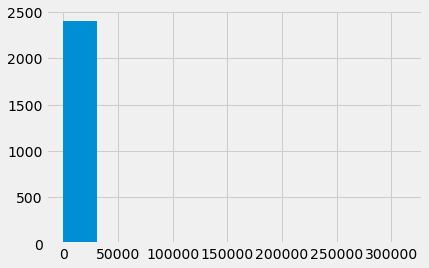

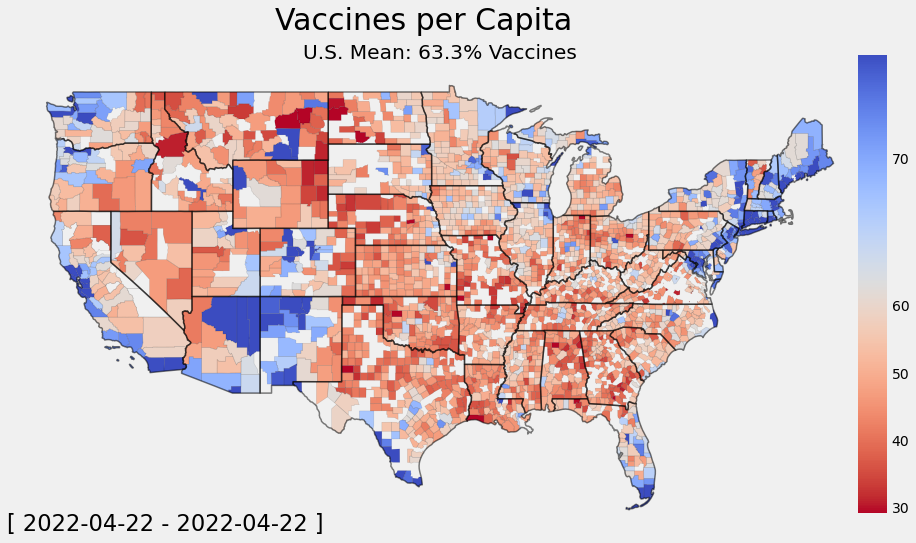

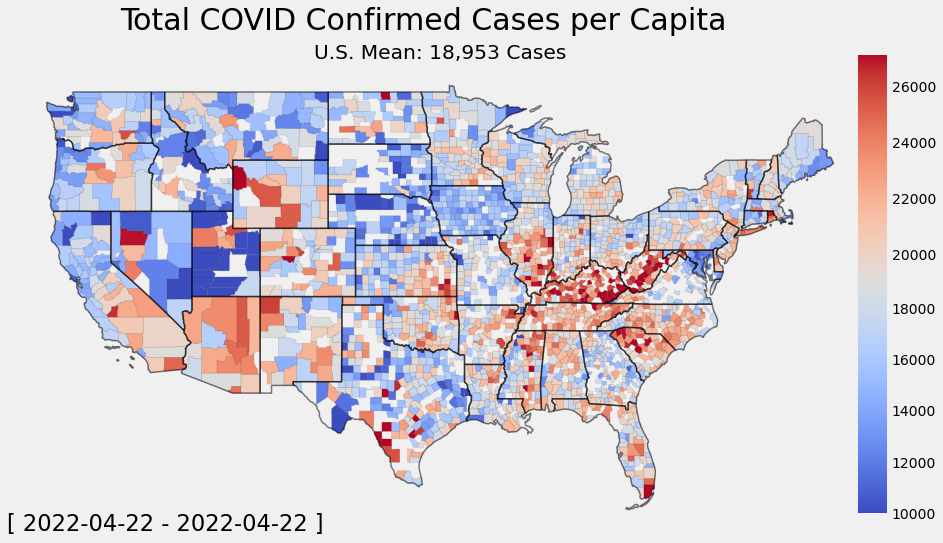

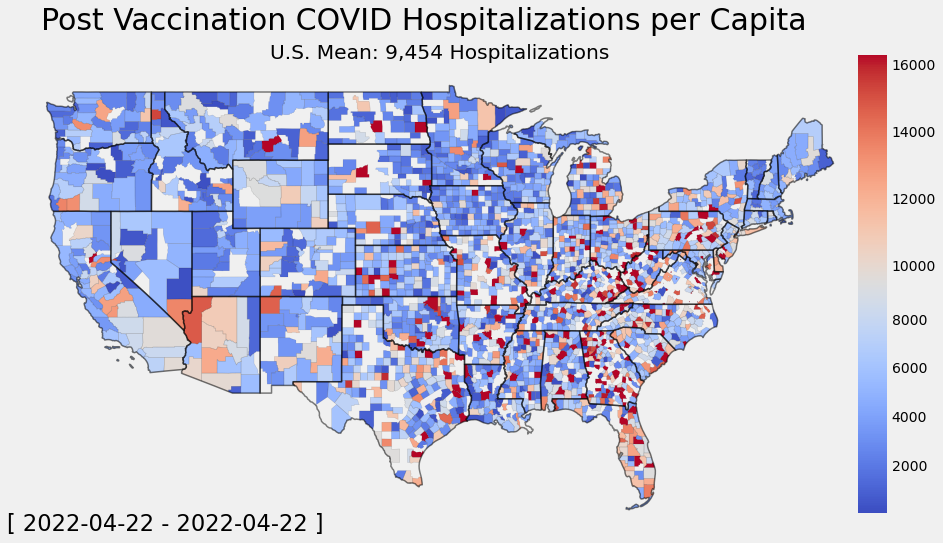

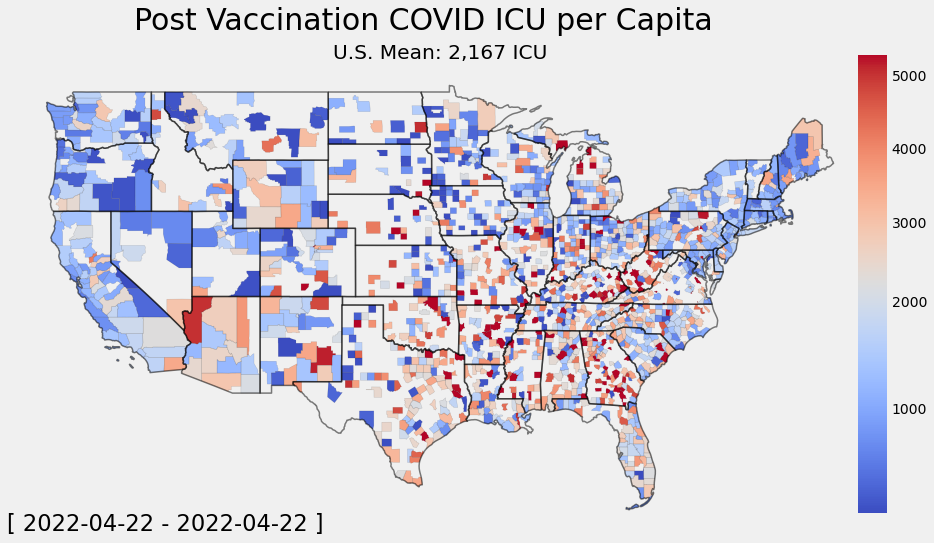

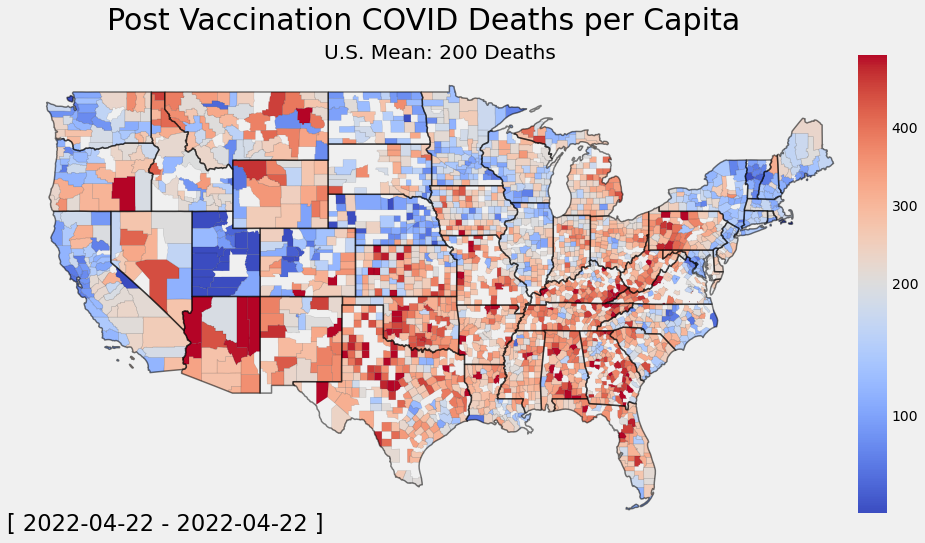

In [67]:
#cd.l()
df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]


display(df.columns)
cmap = cm.coolwarm
geo_df = cd.get("county_geo_df").copy()
geo_df = geo_df.merge(df,left_on="GEOID",right_on="FIPS")
display(df['pv_beds_covid_tot_100k'].describe())
display(df['pv_beds_covid_tot_100k'].hist())
column = 'vax_pct'
center = round(cd.get('us_cdvh_df')[column].iloc[-1],3)*100
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Vaccines per Capita",
    title=f"U.S. Mean: {center:,}% Vaccines",
    cmap='coolwarm',
    reverse=True,
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmax=90000
    )

column = 'pv_New_Confirm_tot_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Total COVID Confirmed Cases per Capita",
    title=f"U.S. Mean: {center:,} Cases",
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmin=5000,
    #vmax = 44157,
    )


column = 'pv_beds_covid_tot_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df[geo_df[column] > 10], 
    column=column,
    vcenter=center,
    suptitle="Post Vaccination COVID Hospitalizations per Capita",
    title=f"U.S. Mean: {center:,} Hospitalizations",
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    std=1
    #vmax=13908,
    
    )


column = 'pv_icu_covid_tot_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df[geo_df[column] > 10], 
    column=column,
    vcenter=center,
    suptitle="Post Vaccination COVID ICU per Capita",
    title=f"U.S. Mean: {center:,} ICU",
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    std=1
     #vmax=us_total_icu_mean*2,
    #vmin=int(us_total_icu_mean/2)

    )


column = 'pv_New_Deaths_tot_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Post Vaccination COVID Deaths per Capita",
    title=f"U.S. Mean: {center:,} Deaths",
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmin=100,
    #vmax=1000,
     
    )







In [68]:
"""
df_bv = cd.get('week_cdvh_df').copy()
df_bv = df_bv[df_bv["Date"]== df_bv["Date"].min()]

#display(df_bv.columns)
bv_geo_df = cd.get("county_geo_df").copy().merge(df_bv,left_on="GEOID",right_on="FIPS")

#display(df.columns)

column = 'tot_confirm_100k'
center = cd.get('us_cdvh_df').iloc[0][column]
process_covid.qgeo(bv_geo_df, 
    column=column,
    vcenter=center,
    suptitle="Before Vaccines: Total COVID Confirmed Cases (per 100k)",
    title=f"U.S. Mean: {center} Cases",
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmin=5000,
    #vmax = 44157,
    )

column = 'pv_New_Confirm_tot_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Post Vaccine COVID Confirmed Cases (per 100k)",
    title=f"U.S. Mean: {center} Cases",
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmin=5000,
    #vmax = 44157,
    )


column = 'vax_ct_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Vaccines (per 100k)",
    title=f"U.S. Mean: {center} Vaccines",
    cmap='coolwarm',
    reverse=True,
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmax=90000
    )


column = 'tot_deaths_100k'
center = cd.get('us_cdvh_df').iloc[0][column]
process_covid.qgeo(bv_geo_df, 
    column=column,
    vcenter=center,
    suptitle="Pre-Vaccine COVID Deaths (per 100k)",
    title=f"U.S. Mean: {center} Cases",
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmin=5000,
    #vmax = 44157,
    )

column = 'pv_New_Deaths_tot_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Post Vaccine COVID Deaths (per 100k)",
    title=f"U.S. Mean: {center} Cases",
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmin=5000,
    #vmax = 44157,
    )

"""
print()


Rendered 0070_date_vax_new_cases_timeline_2022-04-22.jpg


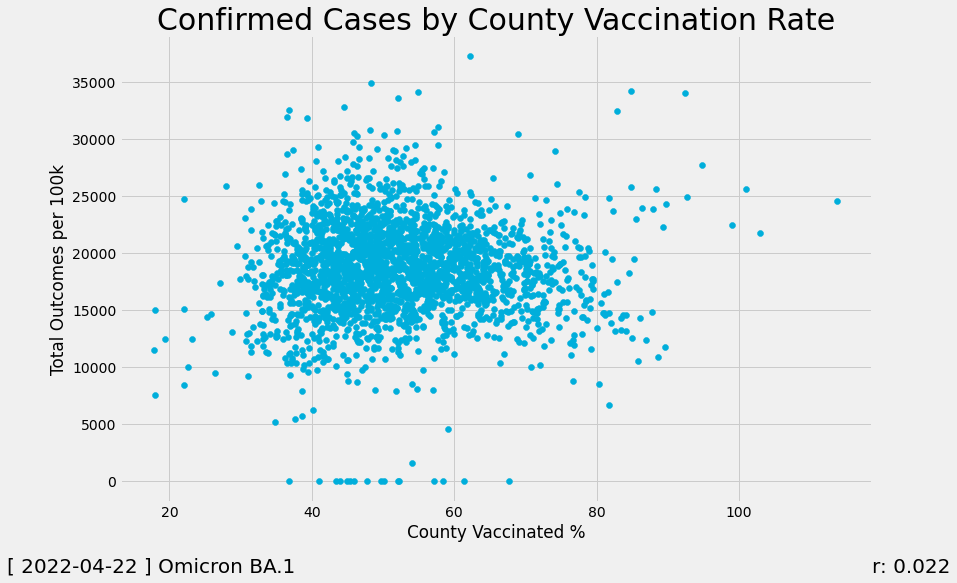

In [69]:
if True:
    reload(process_covid)
    base_name = "date_vax_new_cases_timeline"
    
    column ='pv_New_Confirm_tot_100k'
    title = "Confirmed Cases by County Vaccination Rate"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass

    df = cd.get('week_cdvh_df').copy()
    


    
    for i in range(2,len(df['Date'].unique())):
        
        df = cd.get('week_cdvh_df').copy()
        
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        
        
        
        #//*** Get Current Day
        df= df[df['Date'] == df['Date'].iloc[i]]
        df['vax_pct'] = df['vax_ct'] / df['pop']
        df['vax_pct'] = df['vax_pct'] * 100
        
        df = df[df[column] < df[column].max()]
        
        plt.figure(figsize=(12, 8))
        plt.title(title,fontsize=fontsize*1.5)
        plt.scatter(df['vax_pct'],df[column],color=color_dict['c'])
        plt.xlabel("County Vaccinated %")
        plt.ylabel("Total Outcomes per 100k")
        
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)

        plt.annotate(f"r: {round(df[['vax_pct',column]].corr().iloc[-1]['vax_pct'],3)}",(1,-.15),xycoords='axes fraction',fontsize=fontsize)

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        print(f"Rendered {filename}")
        plt.show()



Rendered 0070_date_vax_deaths_timeline_2022-04-22.jpg


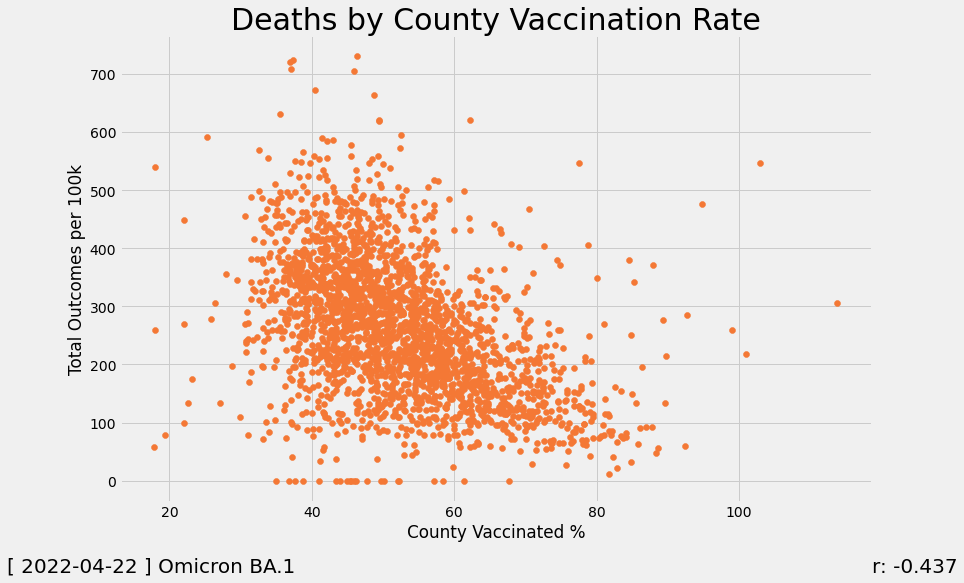

In [70]:
if True:
    reload(process_covid)
    base_name = "date_vax_deaths_timeline"
    
    column ='pv_New_Deaths_tot_100k'
    title = "Deaths by County Vaccination Rate"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass

    df = cd.get('week_cdvh_df').copy()
    


    
    for i in range(2,len(df['Date'].unique())):
        
        df = cd.get('week_cdvh_df').copy()
        
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        
        
        
        #//*** Get Current Day
        df= df[df['Date'] == df['Date'].iloc[i]]
        df['vax_pct'] = df['vax_ct'] / df['pop']
        df['vax_pct'] = df['vax_pct'] * 100
        
        df = df[df[column] < df[column].max()]
        df.loc[(df[column] < 0), column] = 0
        plt.figure(figsize=(12, 8))
        plt.title(title,fontsize=fontsize*1.5)
        plt.scatter(df['vax_pct'],df[column],color=color_dict['d'])
        plt.xlabel("County Vaccinated %")
        plt.ylabel("Total Outcomes per 100k")
        
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        
        plt.annotate(f"r: {round(df[['vax_pct',column]].corr().iloc[-1]['vax_pct'],3)}",(1,-.15),xycoords='axes fraction',fontsize=fontsize)
        
        
        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        print(f"Rendered {filename}")
        plt.show()
        display()
        
        
          
        



Rendered 0070_date_vax_hosp_timeline_2022-04-22.jpg


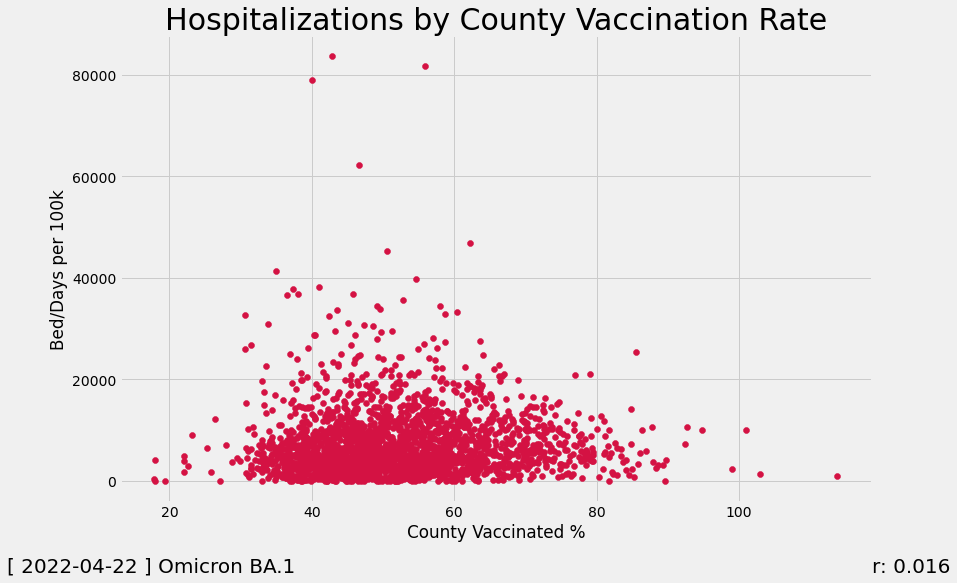

In [71]:
if True:
    reload(process_covid)
    base_name = "date_vax_hosp_timeline"
    
    column ='beds_covid_tot_100k'
    title = "Hospitalizations by County Vaccination Rate"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass

    df = cd.get('week_cdvh_df').copy()
    


    
    for i in range(2,len(df['Date'].unique())):
        
        df = cd.get('week_cdvh_df').copy()
        
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        
        
        
        #//*** Get Current Day
        df= df[df['Date'] == df['Date'].iloc[i]]
        df['vax_pct'] = df['vax_ct'] / df['pop']
        df['vax_pct'] = df['vax_pct'] * 100
        
        #//*** Remove top two highest values as outliers
        df = df[df[column] < df[column].max()]
        df = df[df[column] < df[column].max()]

        df.loc[(df[column] < 0), column] = 0
        plt.figure(figsize=(12, 8))
        plt.title(title,fontsize=fontsize*1.5)
        plt.scatter(df['vax_pct'],df[column],color=color_dict['h'])
        plt.xlabel("County Vaccinated %")
        plt.ylabel("Bed/Days per 100k")
        
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        
        plt.annotate(f"r: {round(df[['vax_pct',column]].corr().iloc[-1]['vax_pct'],3)}",(1,-.15),xycoords='axes fraction',fontsize=fontsize)
        
        
        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        print(f"Rendered {filename}")
        plt.show()
        display()
        
        
          
        



Rendered 0070_date_vax_icu_timeline_2022-04-22.jpg


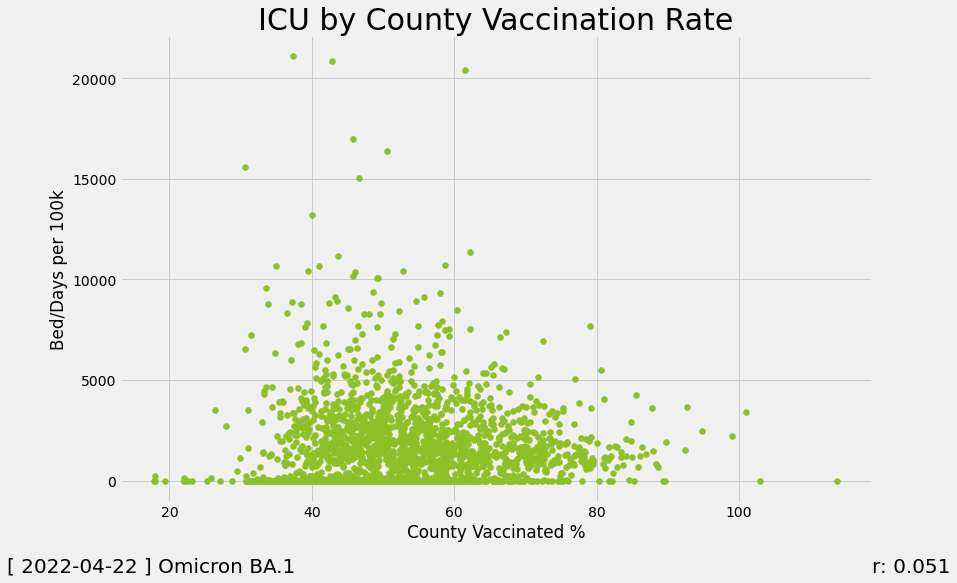

In [72]:
if True:
    reload(process_covid)
    base_name = "date_vax_icu_timeline"
    
    column ='icu_covid_tot_100k'
    title = "ICU by County Vaccination Rate"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass

    df = cd.get('week_cdvh_df').copy()
    


    
    for i in range(2,len(df['Date'].unique())):
        
        df = cd.get('week_cdvh_df').copy()
        
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        
        
        
        #//*** Get Current Day
        df= df[df['Date'] == df['Date'].iloc[i]]
        df['vax_pct'] = df['vax_ct'] / df['pop']
        df['vax_pct'] = df['vax_pct'] * 100
        
        #//*** Remove top two highest values as outliers
        df = df[df[column] < df[column].max()]
        df = df[df[column] < df[column].max()]

        df.loc[(df[column] < 0), column] = 0
        plt.figure(figsize=(12, 8))
        plt.title(title,fontsize=fontsize*1.5)
        plt.scatter(df['vax_pct'],df[column],color=color_dict['i'])
        plt.xlabel("County Vaccinated %")
        plt.ylabel("Bed/Days per 100k")
        
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",(-.15,-.15),xycoords='axes fraction',fontsize=fontsize)
        
        plt.annotate(f"r: {round(df[['vax_pct',column]].corr().iloc[-1]['vax_pct'],3)}",(1,-.15),xycoords='axes fraction',fontsize=fontsize)
        
        
        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        print(f"Rendered {filename}")
        plt.show()
        display()
        
        
          
        



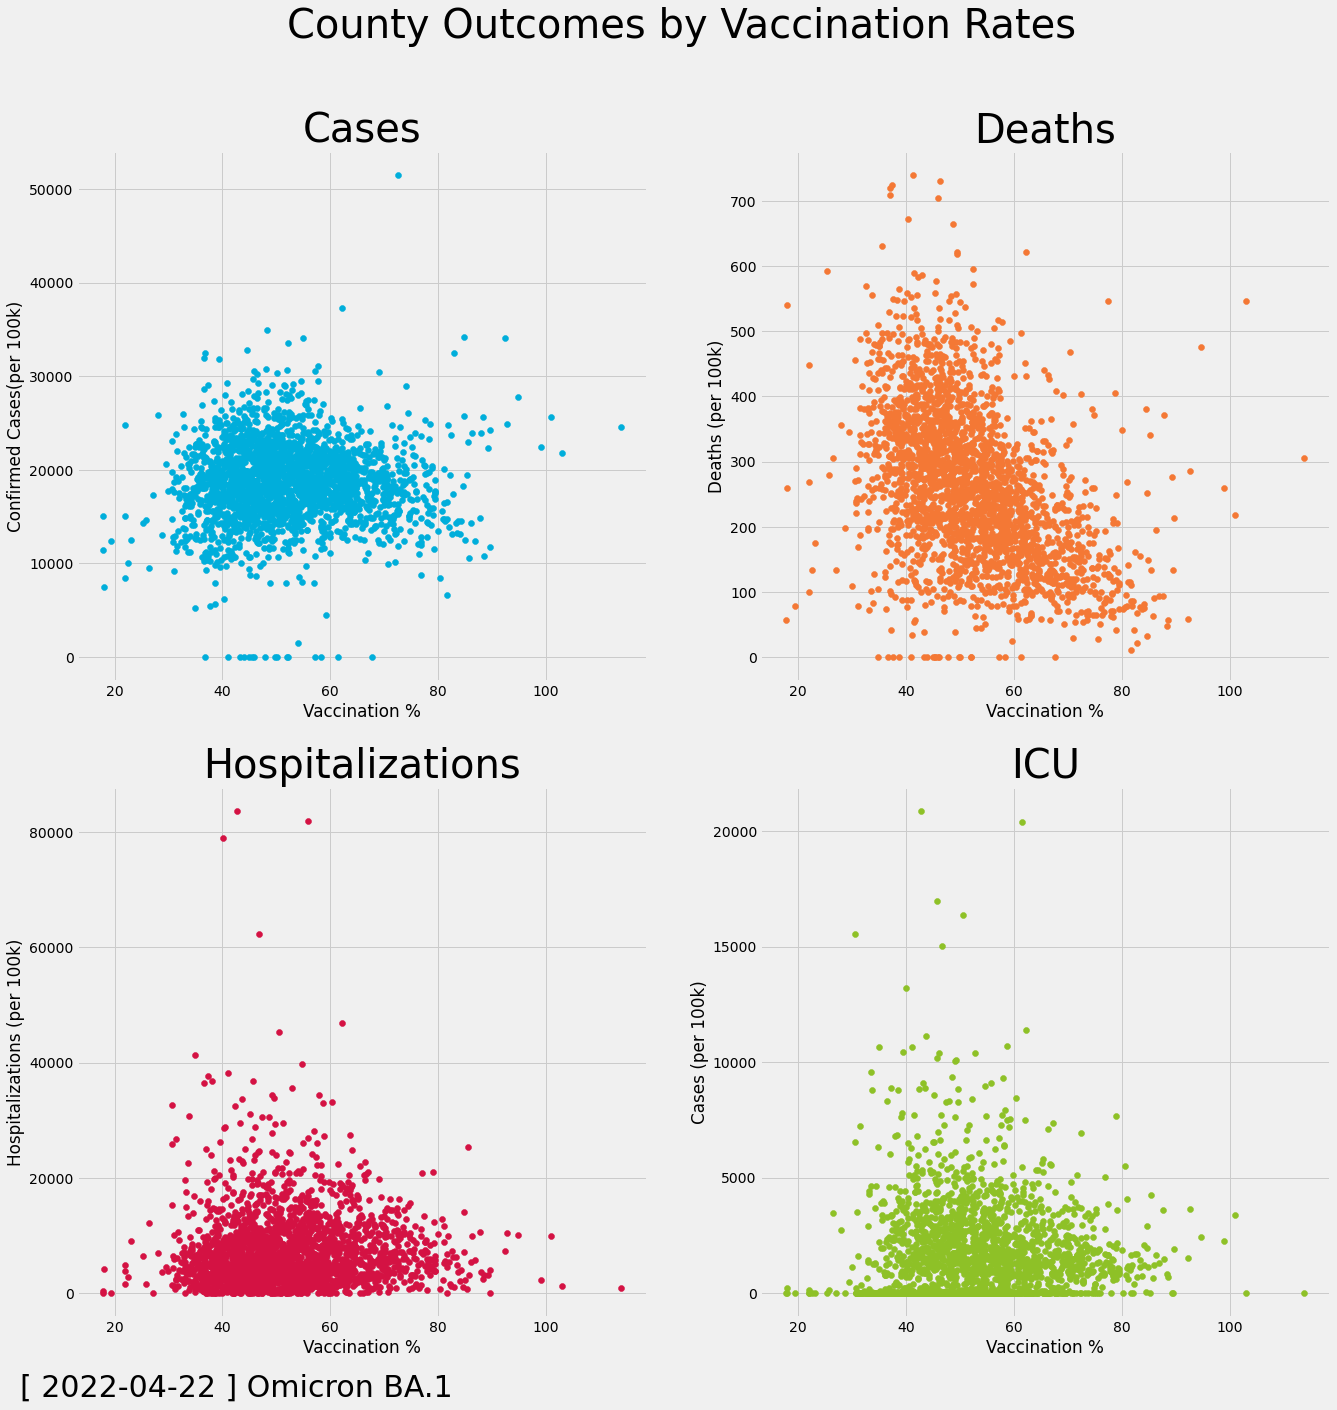

In [73]:
if True:
    reload(process_covid)
    base_name = "date_vax_quad_timeline"
    
    column ='icu_covid_tot_100k'
    title = "ICU by County Vaccination Rate"
        
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)
    
    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass

    df = cd.get('week_cdvh_df').copy()
    


    
    for i in range(2,len(df['Date'].unique())):
        
        df = cd.get('week_cdvh_df').copy()
        
        filename=f"{str(i).zfill(4)}_{base_name}_{df['Date'].iloc[i].date()}.jpg".format(100)
        
        
        
        #//*** Get Current Day
        df= df[df['Date'] == df['Date'].iloc[i]]
        df['vax_pct'] = df['vax_ct'] / df['pop']
        df['vax_pct'] = df['vax_pct'] * 100
        
        
        plt.figure(figsize=(20, 20))
        plt.suptitle("County Outcomes by Vaccination Rates",fontsize=fontsize*2)

        plt.subplot(2, 2, 1)#//*** Left Boxx


        column = 'pv_New_Confirm_tot_100k'


        plt.scatter(df['vax_pct'],df[column],color=color_dict['c'])
        plt.title("Cases",fontsize=fontsize*2)
        plt.xlabel("Vaccination %")
        plt.ylabel("Confirmed Cases(per 100k)")


        




        column = 'pv_New_Deaths_tot_100k'
        df.loc[(df[column] < 0), column] = 0

        plt.subplot(2, 2, 2)#//*** Left Boxx
        plt.scatter(df['vax_pct'],df[column],color=color_dict['d'])
        plt.title("Deaths",fontsize=fontsize*2)
        plt.xlabel("Vaccination %")
        plt.ylabel("Deaths (per 100k)")


        column = 'beds_covid_tot_100k'
        #//*** Remove top two highest values as outliers
        df = df[df[column] < df[column].max()]
        df = df[df[column] < df[column].max()]


        plt.subplot(2, 2, 3)#//*** Left Boxx
        plt.scatter(df['vax_pct'],df[column],color=color_dict['h'])
        plt.title("Hospitalizations",fontsize=fontsize*2)
        plt.xlabel("Vaccination %")
        plt.ylabel("Hospitalizations (per 100k)")

        column = 'icu_covid_tot_100k'
        #//*** Remove top two highest values as outliers
        df = df[df[column] < df[column].max()]
        df = df[df[column] < df[column].max()]

        plt.subplot(2, 2, 4)#//*** Left Boxx
        plt.scatter(df['vax_pct'],df[column],color=color_dict['i'])
        plt.title("ICU",fontsize=fontsize*2)
        plt.xlabel("Vaccination %")
        plt.ylabel("Cases (per 100k)")
        
        coords=(-1.3,-.15)
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",coords,xycoords='axes fraction',fontsize=fontsize*1.5)

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

        clear_output(wait=True)
        plt.show()


# Working #

<a id="working"></a> 

[Top](#top)

# People Get vaccinated because of outcomes. In the highest vax Counties. That doesn't hold if Vax Rate is constant #

# Build IQR Vax Collection #

In [74]:

reload(process_covid)
vax_collection_IQR = process_covid.collect_dataframes()

df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]

q1 = 50
q3 = 80
q1 = np.nanquantile(df['vax_pct'].sort_values(),.25)
q3 = np.nanquantile(df['vax_pct'].sort_values(),.75)

agg_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid', 'icu_covid']
agg_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid','beds','beds_used','all_icu','icu_used']
dfs = []
df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]
display(df['vax_pct'].describe())

#display(df['vax_pct'].hist())
#gp = df.boxplot(column='vax_pct')
#gp.plot()
#display(plt.show())

display(df.columns)
counter = 0
vax_FIPS = {}
#//*** Aggregate and collect High Med Low Vax Counties
for df in [df[df["vax_pct"] < q1],df[(df["vax_pct"] >= q1) & (df["vax_pct"] < q3)],df[df["vax_pct"] >= q3]]:
    #//**** get a FIPS list for the COunties in current vax tier
    vax_cty = list(df['FIPS'].unique())

    print(len(vax_cty))
    loop_df = cd.get('week_cdvh_df').copy()
    loop_df = loop_df[loop_df['FIPS'].isin(vax_cty)]
    print("Counties:",len(vax_cty), "Rows:",len(loop_df),"POP: ",int((loop_df['pop'].unique().sum())/1000000),"Million")
    pop = loop_df['pop'].unique().sum()
    

    #//*** Build Dictionary to aggregate all columns in agg_cols
    agg_dict = {}

    for col in agg_cols:
        agg_dict[col] = ['sum']

    #//*** Nast Tyoe Conversion!
    loop_df = loop_df.groupby('Date').agg(agg_dict)
    loop_df.columns=agg_cols
    #loop_df['pop'] = pop
    
    loop_df['vax_pct'] = loop_df['vax_ct'] / loop_df['pop']
    loop_df['count'] = len(vax_cty)
    #loop_df = process_covid.build_100k(loop_df,cols=agg_cols)
    loop_df = loop_df.reset_index()
    #loop_df = loop_df[loop_df['vax_pct'] > .2]
    loop_df = process_covid.standard_recalc_cols(loop_df)
    
    
    counter += 1
    
    if counter == 1:
        vax_collection_IQR.add(loop_df,'low',f"IQR Low Vaccine Counties  ({q1}% <) ")
        vax_FIPS['low'] = vax_cty
    elif counter == 2:
        vax_collection_IQR.add(loop_df,'med',f"IQR Medium Vaccine Counties, ({q1}% - {q3}%)")
        vax_FIPS['med'] = vax_cty
    elif counter == 3:
        vax_collection_IQR.add(loop_df,'high',f"IQR High Vaccine Counties, ({q3}%) >")
        vax_FIPS['high'] = vax_cty
    
vax_collection_IQR.l()


count    2416.000000
mean       52.346689
std        11.662810
min        17.900000
25%        43.800000
50%        51.050000
75%        59.100000
max        95.000000
Name: vax_pct, dtype: float64

Index(['Date', 'FIPS', 'Recip_State', 'vax_pct', 'vax_ct', 'cty',
       'Combined_Key', 'pop', 'tot_confirm', 'tot_deaths', 'New_Confirm',
       'New_Deaths', 'state', 'beds', 'beds_used', 'beds_covid', 'all_icu',
       'icu_used', 'icu_covid', 'pv_New_Confirm_tot', 'pv_New_Deaths_tot',
       'beds_covid_tot', 'icu_covid_tot', 'beds_tot', 'beds_used_tot',
       'all_icu_tot', 'icu_used_tot', 'pv_beds_covid_tot', 'pv_icu_covid_tot',
       'pv_beds_tot', 'pv_beds_used_tot', 'pv_all_icu_tot', 'pv_icu_used_tot',
       'tot_confirm_100k', 'tot_deaths_100k', 'New_Confirm_100k',
       'New_Deaths_100k', 'pv_New_Confirm_tot_100k', 'pv_New_Deaths_tot_100k',
       'beds_covid_100k', 'icu_covid_100k', 'beds_covid_tot_100k',
       'icu_covid_tot_100k', 'pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',
       'vax_ct_100k', 'pv_beds_tot_100k', 'pv_beds_used_tot_100k',
       'pv_all_icu_tot_100k', 'pv_icu_used_tot_100k', 'all_bed_util',
       'covid_bed_util', 'icu_util', 'icu_covid_uti

602
Counties: 602 Rows: 42720 POP:  18 Million
1209
Counties: 1209 Rows: 85653 POP:  99 Million
605
Counties: 605 Rows: 42948 POP:  195 Million
Collected Dataframe Count:  3
[low] Desc: IQR Low Vaccine Counties  (43.8% <) 
[med] Desc: IQR Medium Vaccine Counties, (43.8% - 59.1%)
[high] Desc: IQR High Vaccine Counties, (59.1%) >


In [75]:
"""
reload(process_covid)
vax_collection_STD = process_covid.collect_dataframes()

df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]

q1 = 50
q3 = 80
display(df['vax_pct'].mean() - df['vax_pct'].std(),df['vax_pct'].mean(),df['vax_pct'].mean() + df['vax_pct'].std())
q1 = np.nanquantile(df['vax_pct'].sort_values(),.25)
q3 = np.nanquantile(df['vax_pct'].sort_values(),.75)

#//*** Mean minus std Dev
q1 = df['vax_pct'].mean() - df['vax_pct'].std()

#//*** Mean plus std Dev
q3 = df['vax_pct'].mean() + df['vax_pct'].std()

agg_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid', 'icu_covid']
agg_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid','beds','beds_used','all_icu','icu_used']
dfs = []
df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]
display(df['vax_pct'].describe())

#display(df['vax_pct'].hist())
gp = df.boxplot(column='vax_pct')
gp.plot()
display(plt.show())

display(df.columns)
counter = 0
vax_FIPS = {}
#//*** Aggregate and collect High Med Low Vax Counties
for df in [df[df["vax_pct"] < q1],df[(df["vax_pct"] >= q1) & (df["vax_pct"] < q3)],df[df["vax_pct"] >= q3]]:
    #//**** get a FIPS list for the COunties in current vax tier
    vax_cty = list(df['FIPS'].unique())

    print(len(vax_cty))
    loop_df = cd.get('week_cdvh_df').copy()
    loop_df = loop_df[loop_df['FIPS'].isin(vax_cty)]
    print("Counties:",len(vax_cty), "Rows:",len(loop_df),"POP: ",int((loop_df['pop'].unique().sum())/1000000),"Million")
    pop = loop_df['pop'].unique().sum()
    #//*** Build Dictionary to aggregate all columns in agg_cols
    agg_dict = {}

    for col in agg_cols:
        agg_dict[col] = ['sum']

    #//*** Nast Tyoe Conversion!
    loop_df = loop_df.groupby('Date').agg(agg_dict)
    loop_df.columns=agg_cols
    #loop_df['pop'] = pop
    
    loop_df['count'] = len(vax_cty)
    loop_df['vax_pct'] = loop_df['vax_ct'] / loop_df['pop']
    #loop_df = process_covid.build_100k(loop_df,cols=agg_cols)
    loop_df = loop_df.reset_index()
    #loop_df = loop_df[loop_df['vax_pct'] > .2]
    loop_df = process_covid.standard_recalc_cols(loop_df)
    
    
    counter += 1
    
    if counter == 1:
        vax_collection_STD.add(loop_df,'low',f"STD Low Vaccine Counties  ({q1}% <) ")
        vax_FIPS['low'] = vax_cty
    elif counter == 2:
        vax_collection_STD.add(loop_df,'med',f"STD Medium Vaccine Counties, ({q1}% - {q3}%)")
        vax_FIPS['med'] = vax_cty
    elif counter == 3:
        vax_collection_STD.add(loop_df,'high',f"STD High Vaccine Counties, ({q3}%) >")
        vax_FIPS['high'] = vax_cty
    
vax_collection_STD.l()

"""
pass

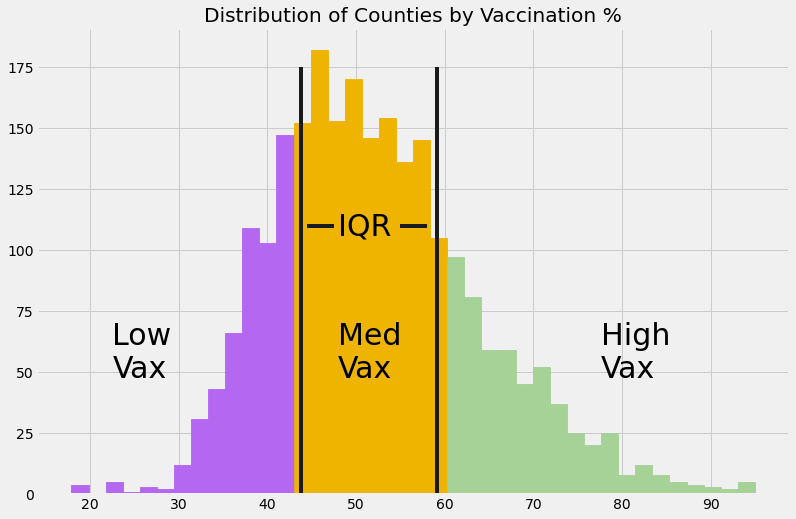

In [76]:
if True:
    base_name = "distrib_vax"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)
    
    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass


    df = cd.get('week_cdvh_df').copy()
    df = df[df["Date"]== df["Date"].max()]
    iqr_q1 = np.nanquantile(df['vax_pct'].sort_values(),.25)
    iqr_q3 = np.nanquantile(df['vax_pct'].sort_values(),.75)

    
    df['vax_pct'].hist(figsize=[12, 8], bins=40)
    plt.title("Distribution of Counties by Vaccination %")
    #plt.vlines(iqr_q1,ymin=0,ymax=200,color= (.1,.1,.1,1), linestyle="solid")
    #plt.vlines(iqr_q3,ymin=0,ymax=200,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
    #plt.annotate("IQR",(.4,.5),xycoords='axes fraction',fontsize=fontsize*1.5)
    filename=f"0001_{base_name}_.jpg"

    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show()
    
    df['vax_pct'].hist(figsize=[12, 8], bins=40)
    plt.title("Distribution of Counties by Vaccination %")
    plt.vlines(iqr_q1,ymin=0,ymax=175,color= (.1,.1,.1,1), linestyle="solid")
    plt.vlines(iqr_q3,ymin=0,ymax=175,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
    #plt.hlines(110,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
    #plt.annotate("IQR",(.4,.5),xycoords='axes fraction',fontsize=fontsize*1.5)
    filename=f"0002_{base_name}_.jpg"

    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show()

    df['vax_pct'].hist(figsize=[12, 8], bins=40)
    plt.title("Distribution of Counties by Vaccination %")
    plt.vlines(iqr_q1,ymin=0,ymax=175,color= (.1,.1,.1,1), linestyle="solid")
    plt.vlines(iqr_q3,ymin=0,ymax=175,color= (.1,.1,.1,1), linestyle="solid")
    plt.hlines(110,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
    plt.hlines(110,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
    #plt.annotate("IQR",(.4,.5),xycoords='axes fraction',fontsize=fontsize*1.5)
    filename=f"0003_{base_name}_.jpg"

    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show()

    df['vax_pct'].hist(figsize=[12, 8], bins=40)
    plt.title("Distribution of Counties by Vaccination %")
    plt.vlines(iqr_q1,ymin=0,ymax=175,color= (.1,.1,.1,1), linestyle="solid")
    plt.vlines(iqr_q3,ymin=0,ymax=175,color= (.1,.1,.1,1), linestyle="solid")
    plt.hlines(110,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
    plt.hlines(110,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
    plt.annotate("IQR",(.4,.555),xycoords='axes fraction',fontsize=fontsize*1.5)
    filename=f"0004_{base_name}_.jpg"

    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show()

    df['vax_pct'].hist(figsize=[12, 8], bins=40,color=color_dict['c'])
    plt.title("Distribution of Counties by Vaccination %")
    plt.vlines(iqr_q1,ymin=0,ymax=175,color= (.1,.1,.1,1), linestyle="solid")
    plt.vlines(iqr_q3,ymin=0,ymax=175,color= (.1,.1,.1,1), linestyle="solid")
    plt.hlines(110,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
    plt.hlines(110,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
    plt.annotate("IQR",(.4,.555),xycoords='axes fraction',fontsize=fontsize*1.5)
    
    plt.annotate("Low\nVax",(.1,.25),xycoords='axes fraction',fontsize=fontsize*1.5)
    filename=f"0005_{base_name}_.jpg"


    ax = df['vax_pct'].hist(figsize=[12, 8], bins=40)

    for rect in ax.patches:
        if rect.get_x() < iqr_q1-1:
            rect.set_color(color_dict['low'])

    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show()

    df['vax_pct'].hist(figsize=[12, 8], bins=40,color=color_dict['c'])
    plt.title("Distribution of Counties by Vaccination %")
    plt.vlines(iqr_q1,ymin=0,ymax=175,color= (.1,.1,.1,1), linestyle="solid")
    plt.vlines(iqr_q3,ymin=0,ymax=175,color= (.1,.1,.1,1), linestyle="solid")
    plt.hlines(110,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
    plt.hlines(110,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
    plt.annotate("IQR",(.4,.555),xycoords='axes fraction',fontsize=fontsize*1.5)
    
    plt.annotate("Low\nVax",(.1,.25),xycoords='axes fraction',fontsize=fontsize*1.5)
    plt.annotate("Med\nVax",(.4,.25),xycoords='axes fraction',fontsize=fontsize*1.5)
    filename=f"0006_{base_name}_.jpg"


    ax = df['vax_pct'].hist(figsize=[12, 8], bins=40)

    for rect in ax.patches:
        if rect.get_x() < iqr_q1-1:
            rect.set_color(color_dict['low'])
        if (rect.get_x() >= iqr_q1-1) and (rect.get_x() <= iqr_q3):
            rect.set_color(color_dict['med'])
    
    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show()

    df['vax_pct'].hist(figsize=[12, 8], bins=40,color=color_dict['c'])
    plt.title("Distribution of Counties by Vaccination %")
    plt.vlines(iqr_q1,ymin=0,ymax=175,color= (.1,.1,.1,1), linestyle="solid")
    plt.vlines(iqr_q3,ymin=0,ymax=175,color= (.1,.1,.1,1), linestyle="solid")
    plt.hlines(110,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
    plt.hlines(110,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
    plt.annotate("IQR",(.4,.555),xycoords='axes fraction',fontsize=fontsize*1.5)
    
    plt.annotate("Low\nVax",(.1,.25),xycoords='axes fraction',fontsize=fontsize*1.5)
    plt.annotate("Med\nVax",(.4,.25),xycoords='axes fraction',fontsize=fontsize*1.5)
    plt.annotate("High\nVax",(.75,.25),xycoords='axes fraction',fontsize=fontsize*1.5)
    filename=f"0007_{base_name}_.jpg"


    ax = df['vax_pct'].hist(figsize=[12, 8], bins=40)

    for rect in ax.patches:
        if rect.get_x() < iqr_q1-1:
            rect.set_color(color_dict['low'])
        if (rect.get_x() >= iqr_q1-1) and (rect.get_x() <= iqr_q3):
            rect.set_color(color_dict['med'])
        if rect.get_x() > iqr_q3:
            rect.set_color(color_dict['high'])
    
    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show()


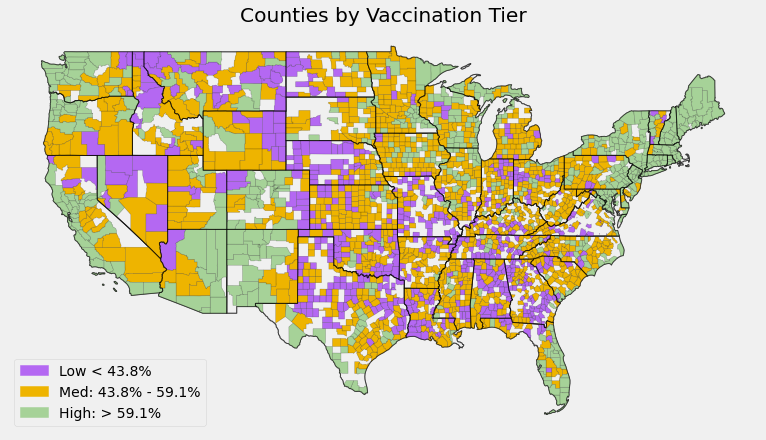

In [77]:
import matplotlib.patches as mpatches
if True:
    base_name = "tier_vax_counties"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)
    
    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    if True:
        #//*** Delete and files in folder 
        for file in os.listdir(project_dir):

            try:
                os.remove(project_dir.joinpath(file)) 
            except:
                pass
    df = cd.get('week_cdvh_df').copy()
    df = df[df["Date"]== df["Date"].max()]

    #vax_collection_iqr = 
    iqr_q1 = np.nanquantile(df['vax_pct'].sort_values(),.25)
    iqr_q3 = np.nanquantile(df['vax_pct'].sort_values(),.75)
    #//*** Mean minus std Dev
    std_q1 = df['vax_pct'].mean() - df['vax_pct'].std()

    #//*** Mean plus std Dev
    std_q3 = df['vax_pct'].mean() + df['vax_pct'].std()

    #//*** IQR Counties
    q1 = iqr_q1
    q3 = iqr_q3


    df=cd.get('week_cdvh_df').copy()
    all_geo_df = cd.get("county_geo_df").copy()
    all_geo_df = all_geo_df[all_geo_df["GEOID"].isin(df["FIPS"].unique() )]


    df = cd.get('week_cdvh_df').copy()
    df = df[df["Date"]== df["Date"].max()]
    df = df[df["vax_pct"] >= q3]
    high_vax_cty = list(df['FIPS'].unique())
    dfs=[]
    df['type'] = "high"
    dfs.append(df)

    df = cd.get('week_cdvh_df').copy()
    df = df[df["Date"]== df["Date"].max()]

    df = df[(df["vax_pct"] >= q1) & (df["vax_pct"] < q3)]
    high_vax_cty = list(df['FIPS'].unique())
    df['type'] = "med"
    dfs.append(df)

    df = cd.get('week_cdvh_df').copy()
    df = df[df["Date"]== df["Date"].max()]

    df = df[(df["vax_pct"] < q1)]
    high_vax_cty = list(df['FIPS'].unique())
    df['type'] = "low"
    dfs.append(df)

    df = pd.concat(dfs)

    geo_df = cd.get("county_geo_df").copy()
    geo_df = geo_df.merge(df[['FIPS','type']],left_on="GEOID",right_on="FIPS")

    state_geo_df = cd.get('state_geo_df').copy()

    #ax = df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.15),color=(1,1,1,0),ax=ax)

    keep_state = geo_df['STATEFP'].unique()
    all_state = state_geo_df['STATEFP'].unique()

    for state in all_state:
        if state not in keep_state:
            state_geo_df = state_geo_df[state_geo_df['STATEFP'] != state]

    ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0))
    #ax = geo_df[geo_df['type'] == "low"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['low'])
    #ax = geo_df[geo_df['type'] == "med"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['med'])
    #ax = geo_df[geo_df['type'] == "high"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['high'])
    ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0),ax=ax)

    ax.grid(False)
    ax.axis('off')
    fonstize=20
    #plt.suptitle(suptitle,fontsize=fontsize)
    plt.title("Counties by Vaccination Tier")
    #text = ""

    #for col in ['low','med','high']:
    #    text += f"{col.title()}: {len(df[df['type'] == col]['FIPS'].unique())} Counties Pop: {int(df[df['type'] == col]['pop'].sum()/1000000)} Million"
    #    text+="\n"
    #plt.annotate(text,(0,-.1),xycoords='axes fraction',fontsize=fontsize*1)


    fig = ax.get_figure()
    fig = plt.gcf()
    fig.set_size_inches(12,8)
    low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low < {q1}% ')
    med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}%')
    high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  ')
    plt.legend(handles=[low_patch,med_patch,high_patch],loc="lower left")
    
    filename=f"0001_{base_name}_.jpg"
    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
    clear_output(wait=True)

    plt.show()

    ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0))
    ax = geo_df[geo_df['type'] == "low"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['low'])
    #ax = geo_df[geo_df['type'] == "med"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['med'])
    #ax = geo_df[geo_df['type'] == "high"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['high'])
    ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0),ax=ax)

    ax.grid(False)
    ax.axis('off')
    fonstize=20
    #plt.suptitle(suptitle,fontsize=fontsize)
    plt.title("Counties by Vaccination Tier")
    #text = ""

    #for col in ['low','med','high']:
    #    text += f"{col.title()}: {len(df[df['type'] == col]['FIPS'].unique())} Counties Pop: {int(df[df['type'] == col]['pop'].sum()/1000000)} Million"
    #    text+="\n"
    #plt.annotate(text,(0,-.1),xycoords='axes fraction',fontsize=fontsize*1)


    fig = ax.get_figure()
    fig = plt.gcf()
    fig.set_size_inches(12,8)
    low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low < {q1}% ')
    med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}%')
    high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  ')
    plt.legend(handles=[low_patch,med_patch,high_patch],loc="lower left")
    
    filename=f"0002_{base_name}_.jpg"
    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')

    clear_output(wait=True)
    plt.show()

    ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0))
    ax = geo_df[geo_df['type'] == "low"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['low'])
    ax = geo_df[geo_df['type'] == "med"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['med'])
    #ax = geo_df[geo_df['type'] == "high"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['high'])
    ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0),ax=ax)

    ax.grid(False)
    ax.axis('off')
    fonstize=20
    #plt.suptitle(suptitle,fontsize=fontsize)
    plt.title("Counties by Vaccination Tier")
    #text = ""

    #for col in ['low','med','high']:
    #    text += f"{col.title()}: {len(df[df['type'] == col]['FIPS'].unique())} Counties Pop: {int(df[df['type'] == col]['pop'].sum()/1000000)} Million"
    #    text+="\n"
    #plt.annotate(text,(0,-.1),xycoords='axes fraction',fontsize=fontsize*1)


    fig = ax.get_figure()
    fig = plt.gcf()
    fig.set_size_inches(12,8)
    low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low < {q1}% ')
    med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}%')
    high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  ')
    plt.legend(handles=[low_patch,med_patch,high_patch],loc="lower left")
    
    filename=f"0003_{base_name}_.jpg"
    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
    clear_output(wait=True)
    plt.show()

    ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0))
    ax = geo_df[geo_df['type'] == "low"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['low'])
    ax = geo_df[geo_df['type'] == "med"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['med'])
    ax = geo_df[geo_df['type'] == "high"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['high'])
    ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0),ax=ax)

    ax.grid(False)
    ax.axis('off')
    fonstize=20
    #plt.suptitle(suptitle,fontsize=fontsize)
    plt.title("Counties by Vaccination Tier")
    #text = ""

    #for col in ['low','med','high']:
    #    text += f"{col.title()}: {len(df[df['type'] == col]['FIPS'].unique())} Counties Pop: {int(df[df['type'] == col]['pop'].sum()/1000000)} Million"
    #    text+="\n"
    #plt.annotate(text,(0,-.1),xycoords='axes fraction',fontsize=fontsize*1)


    fig = ax.get_figure()
    fig = plt.gcf()
    fig.set_size_inches(12,8)
    low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low < {q1}% ')
    med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}%')
    high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  ')
    plt.legend(handles=[low_patch,med_patch,high_patch],loc="lower left")

    filename=f"0004_{base_name}_.jpg"
    plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
    clear_output(wait=True)
    plt.show()
    

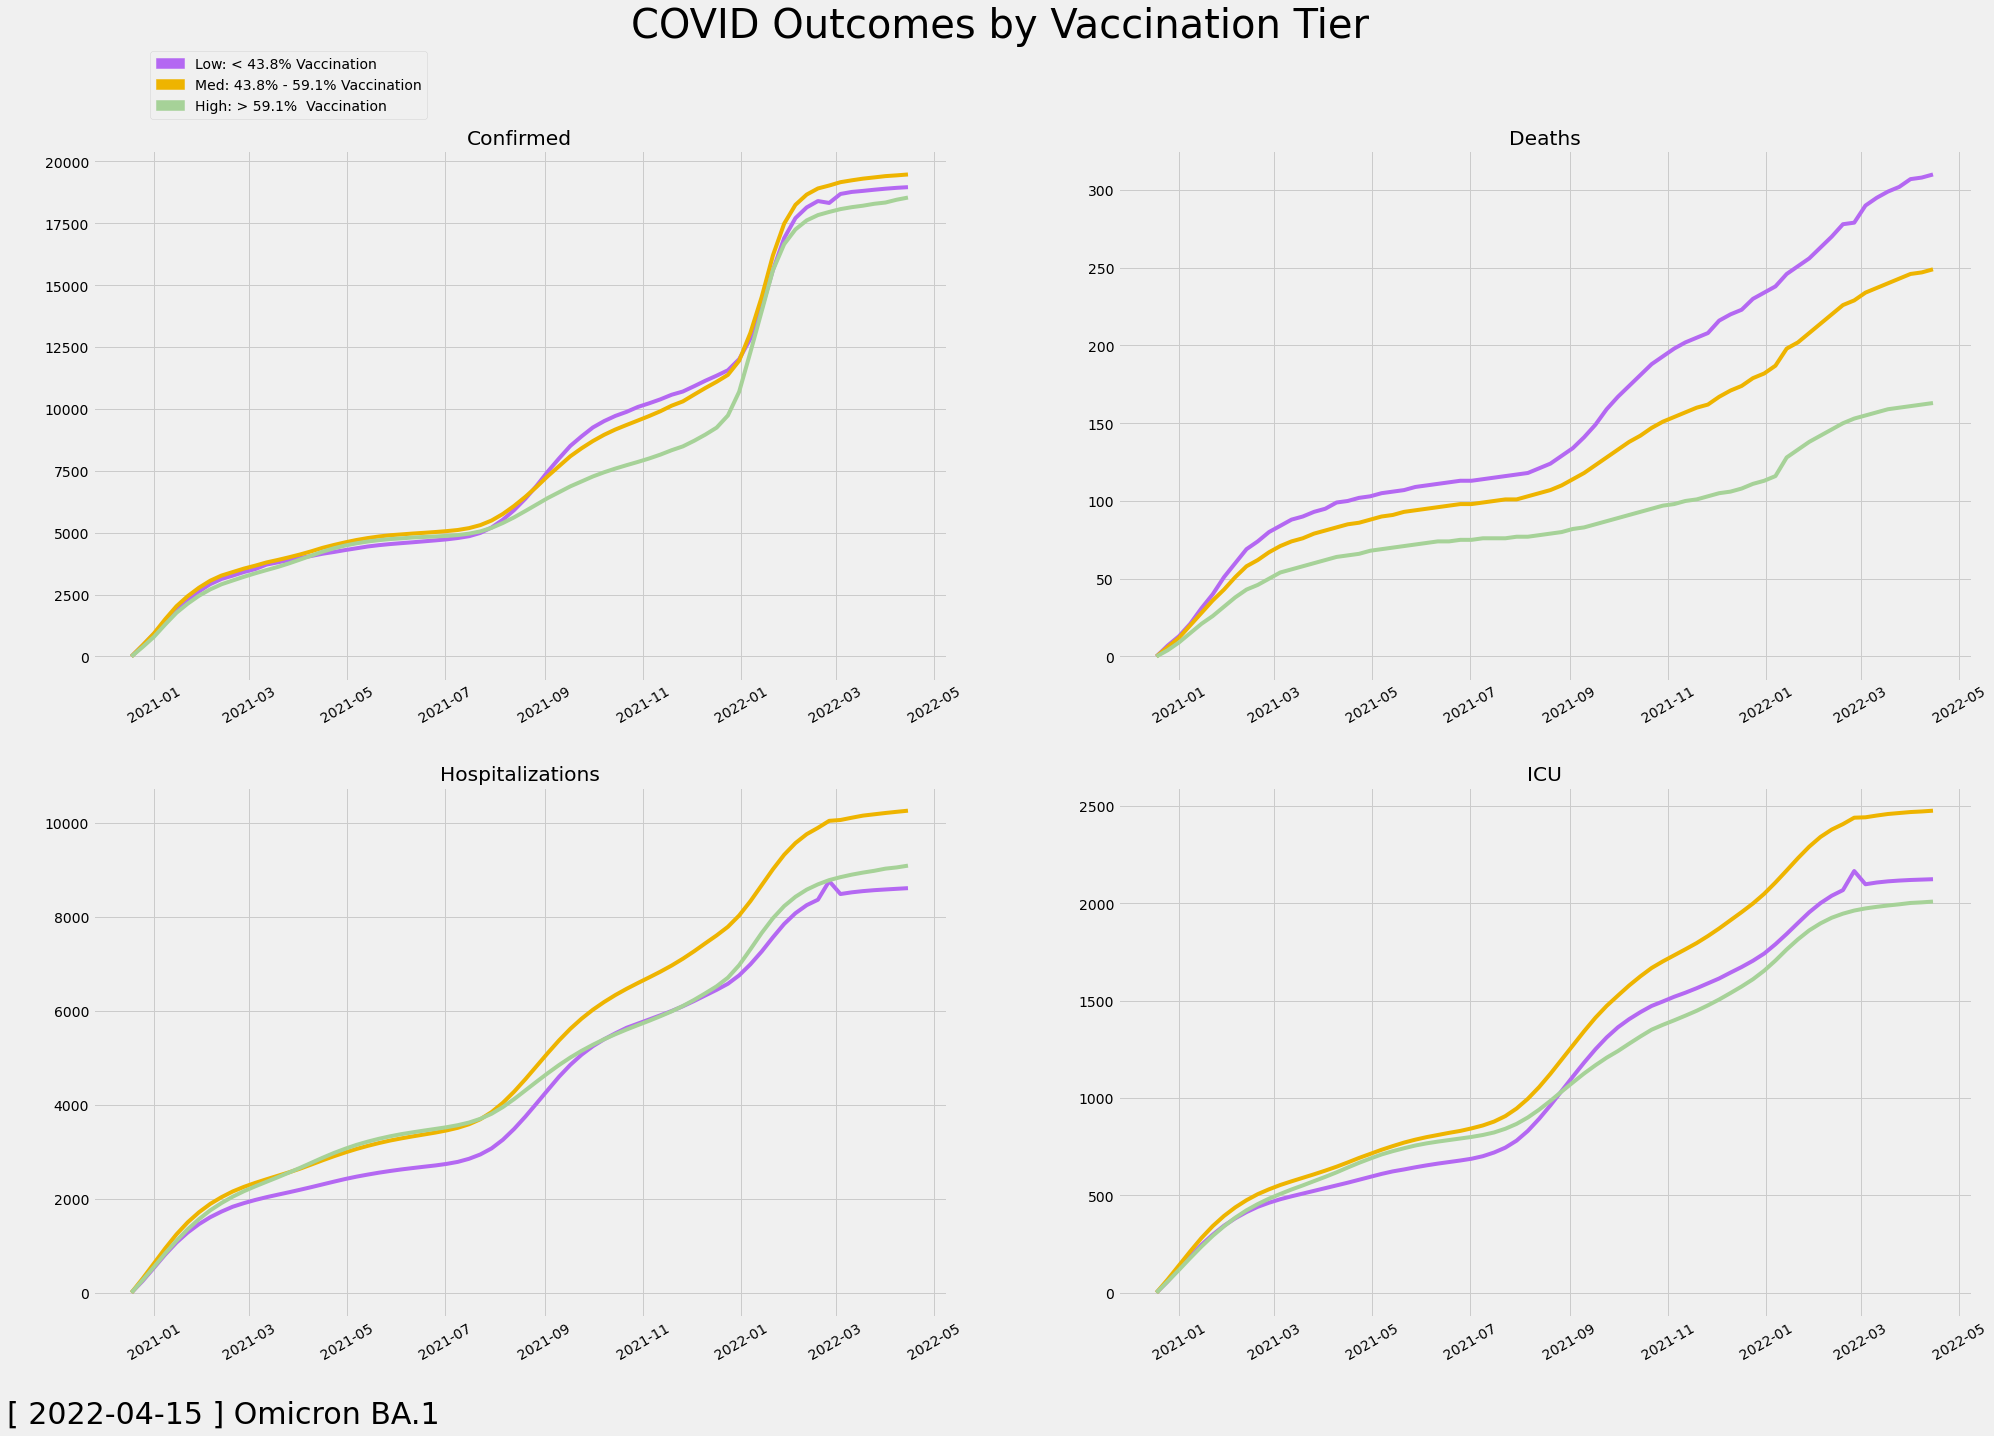

In [78]:

if True:

    base_name = "tier_vax_quad_timeline"
    #y_col = 'New_Deaths_100k'
    #ylabel_text = "Deaths (per 100k)"
    #title = "U.S. COVID Deaths"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)
    
    date_list = df['Date'].unique()
    
    
    
    for i in range(2,(len(date_list))):
        filename=f"{str(i).zfill(4)}_{base_name}_{(pd.to_datetime(date_list[i])).date()}.jpg".format(100)
        
        counter = 1
        plt.figure(figsize=(30, 20))
        plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
        for col in ['pv_New_Confirm_tot_100k','pv_New_Deaths_tot_100k','pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',]:


            plt.subplot(2,2,counter)

            for name in ['low','med','high']:


                df = vax_collection_IQR.get(name)
                
                df = df[ df['Date'].isin(date_list[:i]) ]
                

                plt.plot(df['Date'],df[col],label=name, color=color_dict[name])

            counter+=1
            low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
            med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
            high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
            plt.xticks(rotation=30)
            if col == 'pv_New_Confirm_tot_100k':
                plt.title(f"Confirmed")
                plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(.4,1.2,0,0))
            elif col == 'pv_New_Deaths_tot_100k':
                plt.title(f"Deaths")
            elif col == 'pv_beds_covid_tot_100k':
                plt.title(f"Hospitalizations")
            elif col == 'pv_icu_covid_tot_100k':
                plt.title(f"ICU")

            #plt.legend()
        
        coords=(-1.3,-.2)
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",coords,xycoords='axes fraction',fontsize=fontsize*1.5)

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        plt.show()
        

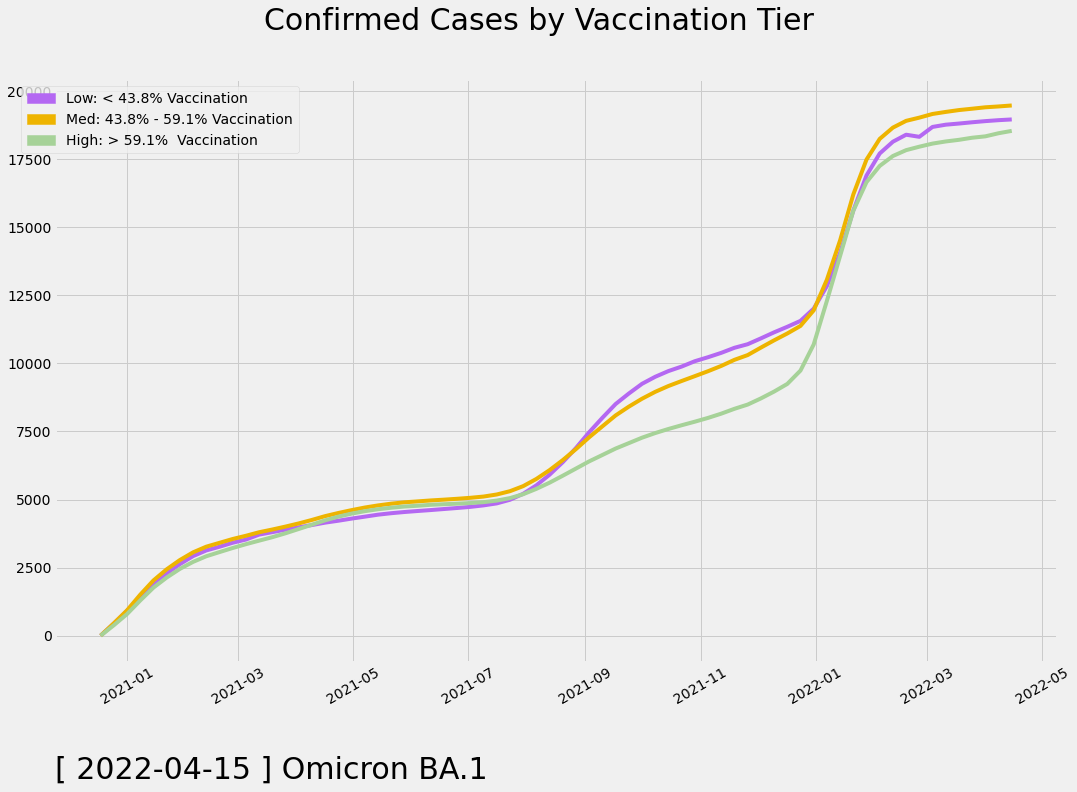

In [79]:

if True:

    base_name = "tier_vax_confirm_timeline"
    #y_col = 'New_Deaths_100k'
    #ylabel_text = "Deaths (per 100k)"
    #title = "U.S. COVID Deaths"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)
    
    date_list = df['Date'].unique()
    
    
    
    for i in range(2,(len(date_list))):
        filename=f"{str(i).zfill(4)}_{base_name}_{(pd.to_datetime(date_list[i])).date()}.jpg".format(100)
        
        counter = 1
        plt.figure(figsize=(16, 10))
        #plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
#        for col in ['pv_New_Confirm_tot_100k','pv_New_Deaths_tot_100k','pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',]:
        for col in ['pv_New_Confirm_tot_100k']:


            for name in ['low','med','high']:


                df = vax_collection_IQR.get(name)
                
                df = df[ df['Date'].isin(date_list[:i]) ]
                

                plt.plot(df['Date'],df[col],label=name, color=color_dict[name])

            counter+=1
            low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
            med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
            high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
            plt.xticks(rotation=30)
            if col == 'pv_New_Confirm_tot_100k':
                plt.suptitle("Confirmed Cases by Vaccination Tier",fontsize=fontsize*1.5)
                plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(0.25,1,0,0))
            elif col == 'pv_New_Deaths_tot_100k':
                plt.suptitle("Deaths by Vaccination Tier",fontsize=fontsize*1.5)
            elif col == 'pv_beds_covid_tot_100k':
                plt.suptitle("Hospitalization by Vaccination Tier",fontsize=fontsize*1.5)
            elif col == 'pv_icu_covid_tot_100k':
                plt.suptitle("ICU by Vaccination Tier",fontsize=fontsize*1.5)

            #plt.legend()
        
        coords=(0,-.2)
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",coords,xycoords='axes fraction',fontsize=fontsize*1.5)

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        plt.show()
        

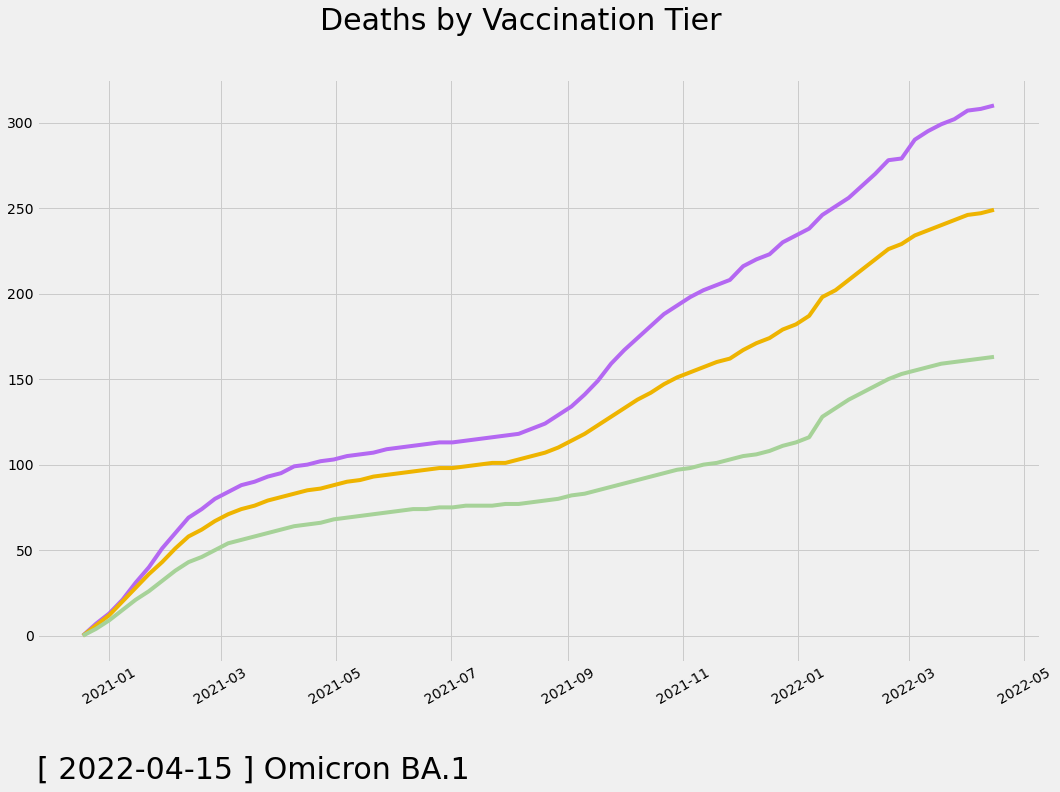

In [80]:

if True:

    base_name = "tier_vax_death_timeline"
    #y_col = 'New_Deaths_100k'
    #ylabel_text = "Deaths (per 100k)"
    #title = "U.S. COVID Deaths"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)
    
    date_list = df['Date'].unique()
    
    
    
    for i in range(2,(len(date_list))):
        filename=f"{str(i).zfill(4)}_{base_name}_{(pd.to_datetime(date_list[i])).date()}.jpg".format(100)
        
        counter = 1
        plt.figure(figsize=(16, 10))
        #plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
#        for col in ['pv_New_Confirm_tot_100k','pv_New_Deaths_tot_100k','pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',]:
        for col in ['pv_New_Deaths_tot_100k']:


            for name in ['low','med','high']:


                df = vax_collection_IQR.get(name)
                
                df = df[ df['Date'].isin(date_list[:i]) ]
                

                plt.plot(df['Date'],df[col],label=name, color=color_dict[name])

            counter+=1
            low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
            med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
            high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
            plt.xticks(rotation=30)
            if col == 'pv_New_Confirm_tot_100k':
                plt.suptitle("Confirmed Cases by Vaccination Tier",fontsize=fontsize*1.5)
                plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(0.25,1,0,0))
            elif col == 'pv_New_Deaths_tot_100k':
                plt.suptitle("Deaths by Vaccination Tier",fontsize=fontsize*1.5)
            elif col == 'pv_beds_covid_tot_100k':
                plt.suptitle("Hospitalization by Vaccination Tier",fontsize=fontsize*1.5)
            elif col == 'pv_icu_covid_tot_100k':
                plt.suptitle("ICU by Vaccination Tier",fontsize=fontsize*1.5)

            #plt.legend()
        
        coords=(0,-.2)
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",coords,xycoords='axes fraction',fontsize=fontsize*1.5)

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        plt.show()
        

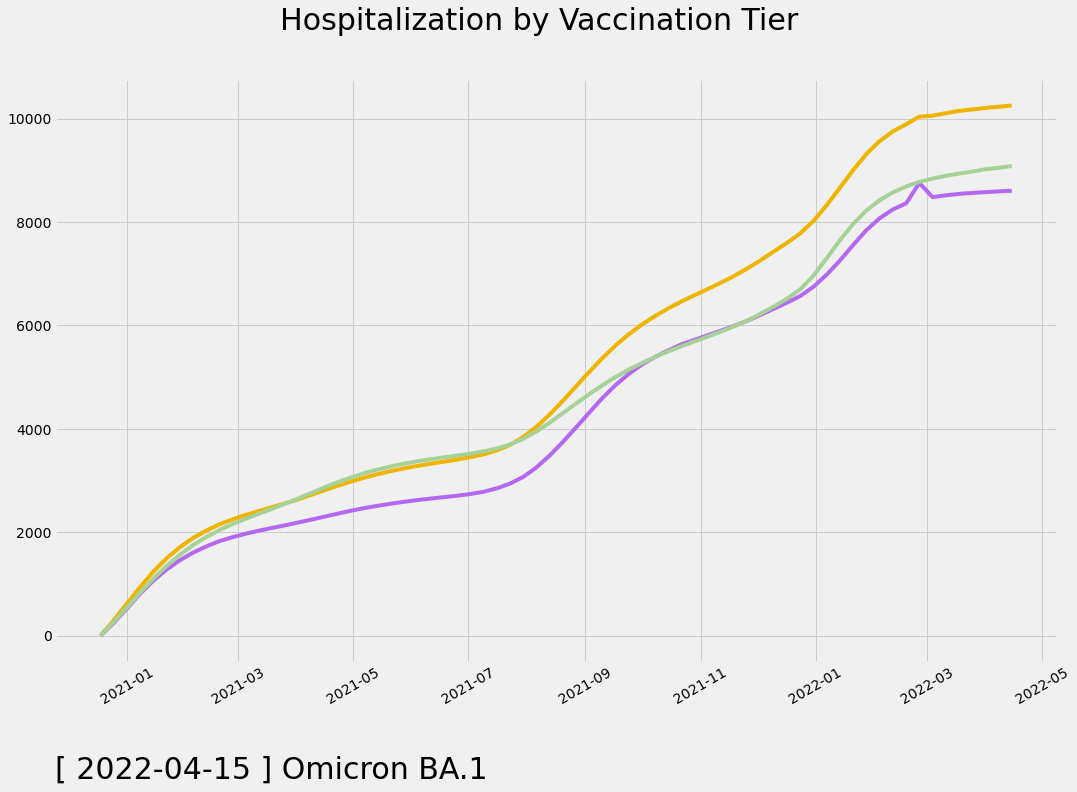

In [81]:

if True:

    base_name = "tier_vax_hosp_timeline"
    #y_col = 'New_Deaths_100k'
    #ylabel_text = "Deaths (per 100k)"
    #title = "U.S. COVID Deaths"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)
    
    date_list = df['Date'].unique()
    
    
    
    for i in range(2,(len(date_list))):
        filename=f"{str(i).zfill(4)}_{base_name}_{(pd.to_datetime(date_list[i])).date()}.jpg".format(100)
        
        counter = 1
        plt.figure(figsize=(16, 10))
        #plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
#        for col in ['pv_New_Confirm_tot_100k','pv_New_Deaths_tot_100k','pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',]:
        for col in ['pv_beds_covid_tot_100k']:


            for name in ['low','med','high']:


                df = vax_collection_IQR.get(name)
                
                df = df[ df['Date'].isin(date_list[:i]) ]
                

                plt.plot(df['Date'],df[col],label=name, color=color_dict[name])

            counter+=1
            low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
            med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
            high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
            plt.xticks(rotation=30)
            if col == 'pv_New_Confirm_tot_100k':
                plt.suptitle("Confirmed Cases by Vaccination Tier",fontsize=fontsize*1.5)
                plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(0.25,1,0,0))
            elif col == 'pv_New_Deaths_tot_100k':
                plt.suptitle("Deaths by Vaccination Tier",fontsize=fontsize*1.5)
            elif col == 'pv_beds_covid_tot_100k':
                plt.suptitle("Hospitalization by Vaccination Tier",fontsize=fontsize*1.5)
            elif col == 'pv_icu_covid_tot_100k':
                plt.suptitle("ICU by Vaccination Tier",fontsize=fontsize*1.5)

            #plt.legend()
        
        coords=(0,-.2)
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",coords,xycoords='axes fraction',fontsize=fontsize*1.5)

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        plt.show()
        

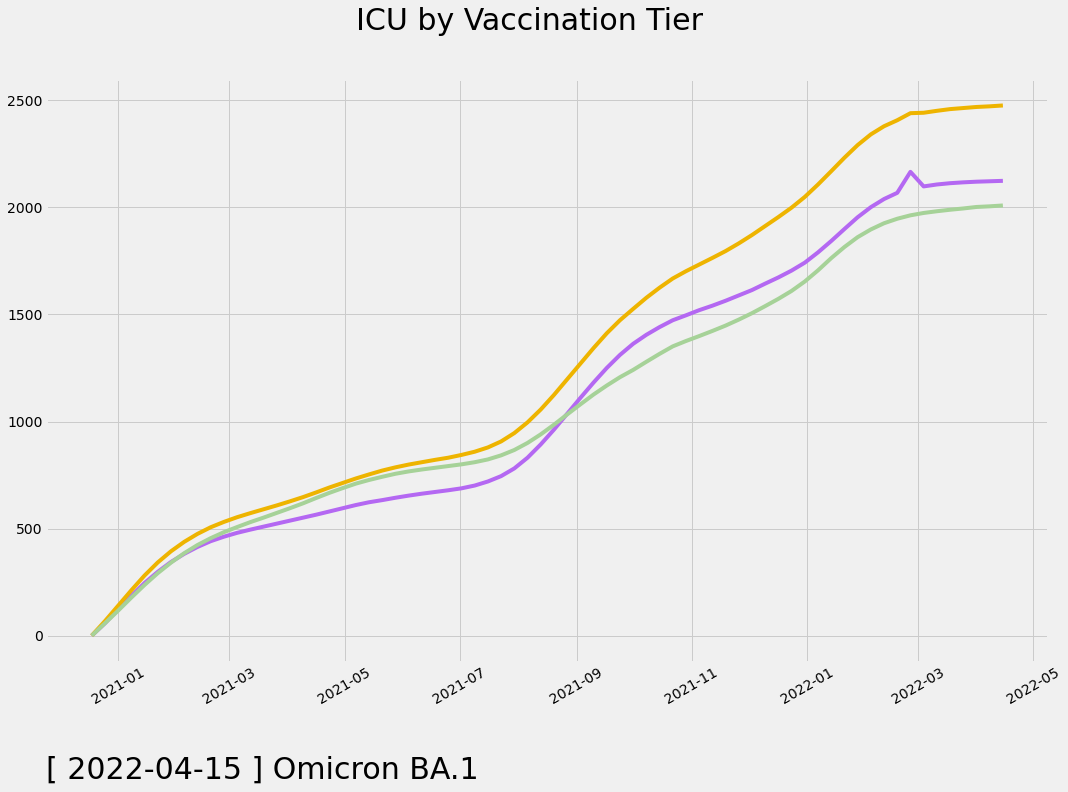

In [82]:

if True:

    base_name = "tier_vax_icu_timeline"
    #y_col = 'New_Deaths_100k'
    #ylabel_text = "Deaths (per 100k)"
    #title = "U.S. COVID Deaths"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)
    
    date_list = df['Date'].unique()
    
    
    
    for i in range(2,(len(date_list))):
        filename=f"{str(i).zfill(4)}_{base_name}_{(pd.to_datetime(date_list[i])).date()}.jpg".format(100)
        
        counter = 1
        plt.figure(figsize=(16, 10))
        #plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
#        for col in ['pv_New_Confirm_tot_100k','pv_New_Deaths_tot_100k','pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',]:
        for col in ['pv_icu_covid_tot_100k']:


            for name in ['low','med','high']:


                df = vax_collection_IQR.get(name)
                
                df = df[ df['Date'].isin(date_list[:i]) ]
                

                plt.plot(df['Date'],df[col],label=name, color=color_dict[name])

            counter+=1
            low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
            med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
            high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
            plt.xticks(rotation=30)
            if col == 'pv_New_Confirm_tot_100k':
                plt.suptitle("Confirmed Cases by Vaccination Tier",fontsize=fontsize*1.5)
                plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(0.25,1,0,0))
            elif col == 'pv_New_Deaths_tot_100k':
                plt.suptitle("Deaths by Vaccination Tier",fontsize=fontsize*1.5)
            elif col == 'pv_beds_covid_tot_100k':
                plt.suptitle("Hospitalization by Vaccination Tier",fontsize=fontsize*1.5)
            elif col == 'pv_icu_covid_tot_100k':
                plt.suptitle("ICU by Vaccination Tier",fontsize=fontsize*1.5)

            #plt.legend()
        
        coords=(0,-.2)
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",coords,xycoords='axes fraction',fontsize=fontsize*1.5)

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        plt.show()
        

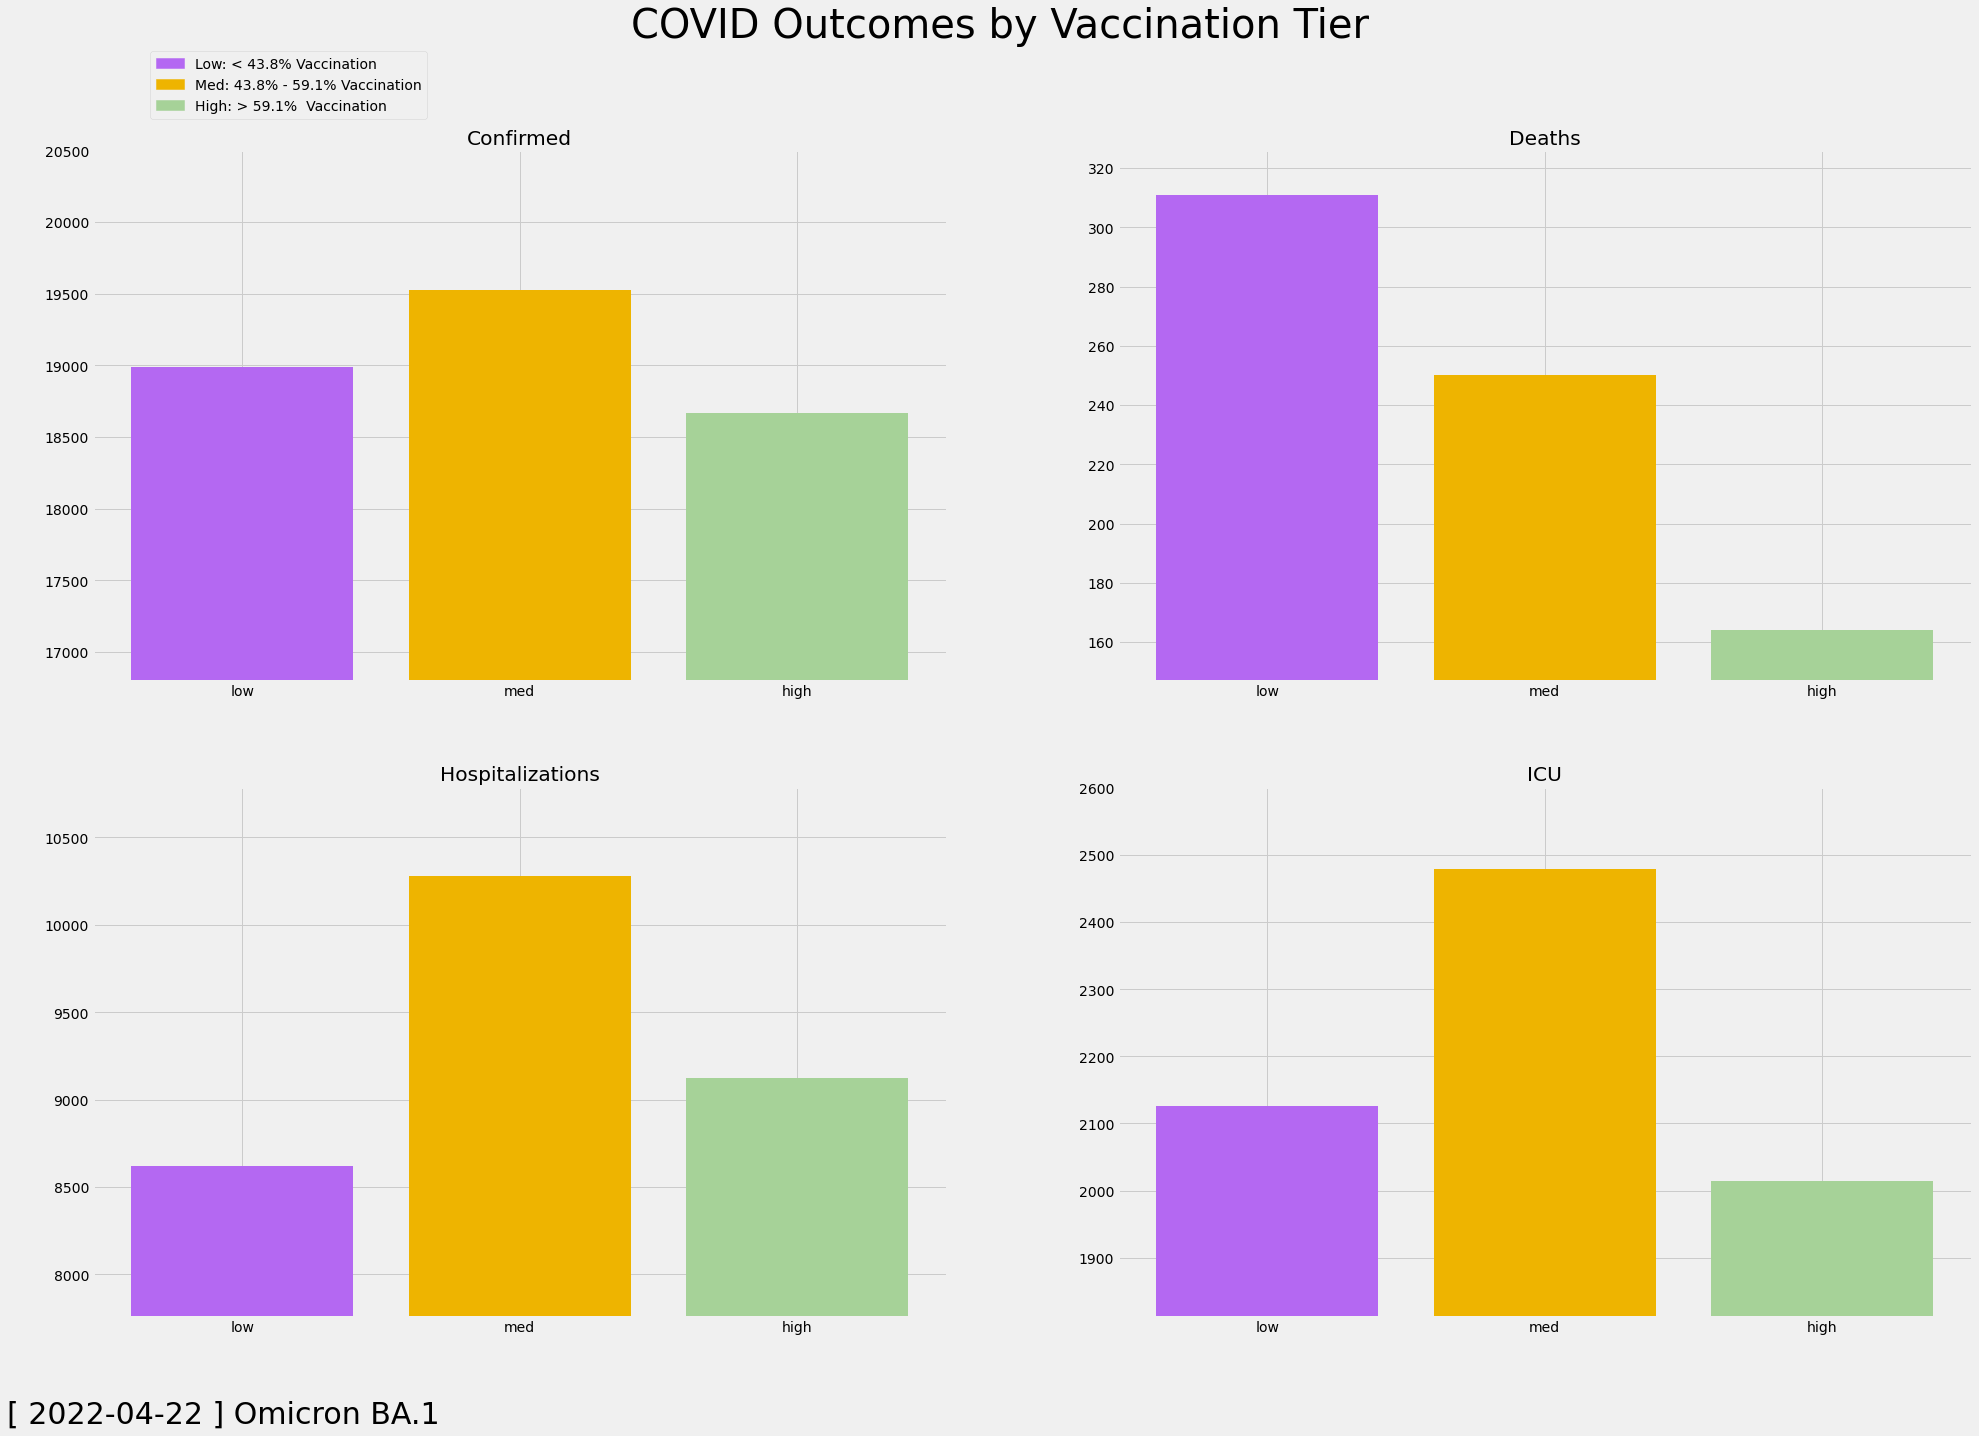

In [83]:

if True:

    base_name = "tier_vax_quad_bar_timeline"
    #y_col = 'New_Deaths_100k'
    #ylabel_text = "Deaths (per 100k)"
    #title = "U.S. COVID Deaths"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)
    
    date_list = df['Date'].unique()
    
    
    
    for i in range(2,(len(date_list))):
        filename=f"{str(i).zfill(4)}_{base_name}_{(pd.to_datetime(date_list[i])).date()}.jpg".format(100)
        
        counter = 1
        plt.figure(figsize=(30, 20))
        plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
        for col in ['pv_New_Confirm_tot_100k','pv_New_Deaths_tot_100k','pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',]:


            plt.subplot(2,2,counter)
            
            min_val = -1
            max_val = -1
            for name in ['low','med','high']:


                df = vax_collection_IQR.get(name)
                
                df = df[ df['Date'] == date_list[i] ]
                
                if min_val == -1:
                    min_val=df[col].values[0]
                
                if max_val == -1:
                    max_val=df[col].values[0]
                
                if df[col].values[0] < min_val:
                      min_val = df[col].values[0]

                if df[col].values[0] > max_val:
                    max_val = df[col].values[0]
                
                plt.bar(name,df[col],label=name, color=color_dict[name],)
            
            plt.ylim([int(min_val*.9),int(max_val*1.05)])
            counter+=1
            low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
            med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
            high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
            #plt.xticks(rotation=30)
            if col == 'pv_New_Confirm_tot_100k':
                plt.title(f"Confirmed")
                plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(.4,1.2,0,0))
            elif col == 'pv_New_Deaths_tot_100k':
                plt.title(f"Deaths")
            elif col == 'pv_beds_covid_tot_100k':
                plt.title(f"Hospitalizations")
            elif col == 'pv_icu_covid_tot_100k':
                plt.title(f"ICU")

            #plt.legend()
        
        coords=(-1.3,-.2)
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",coords,xycoords='axes fraction',fontsize=fontsize*1.5)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",coords,xycoords='axes fraction',fontsize=fontsize*1.5)

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        plt.show()
        

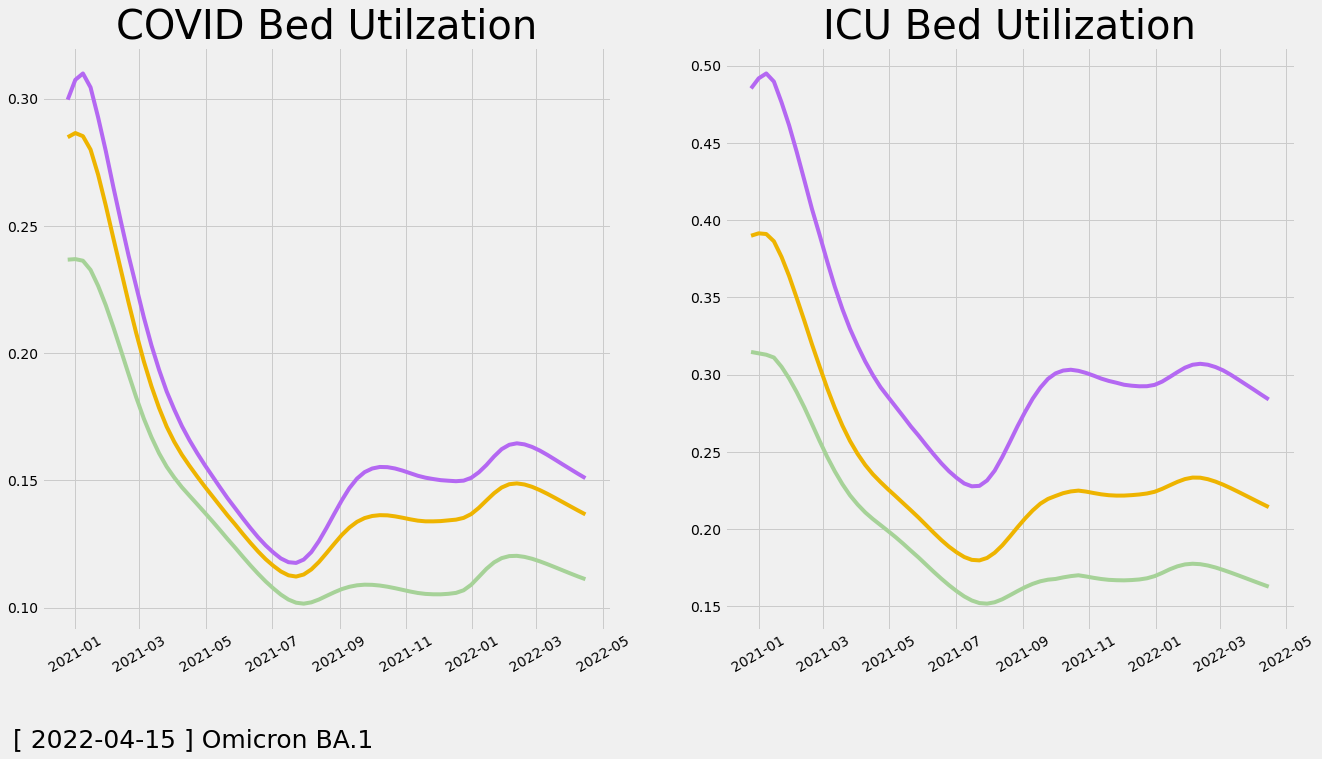

In [84]:

if True:

    base_name = "tier_vax_hosp_util_timeline"
    #y_col = 'New_Deaths_100k'
    #ylabel_text = "Deaths (per 100k)"
    #title = "U.S. COVID Deaths"
    
    project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

    #//*** Build folder if not exist
    try:
        os.mkdir(project_dir)
    except:
        pass

    #//*** Delete and files in folder 
    for file in os.listdir(project_dir):

        try:
            os.remove(project_dir.joinpath(file)) 
        except:
            pass

    df = cd.get('us_cdvh_df').copy()
    display(df.columns)
    
    date_list = df['Date'].unique()
    
    
    
    for i in range(3,(len(date_list))):
        filename=f"{str(i).zfill(4)}_{base_name}_{(pd.to_datetime(date_list[i])).date()}.jpg".format(100)
        
        counter = 1
        plt.figure(figsize=(20, 10))
#        plt.subplots(1,2)
        
        
        #plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
        for col in ['covid_bed_util', 'icu_covid_util',]:


            plt.subplot(1,2,counter)

            for name in ['low','med','high']:


                df = vax_collection_IQR.get(name)
                df = df[ df['Date'].isin(date_list[:i]) ]
                plt.plot(df['Date'],df[col],label=name, color=color_dict[name])


            counter+=1
            low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
            med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
            high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
            plt.xticks(rotation=30)
            #plt.legend(handles=[low_patch,med_patch,high_patch],loc="upper left")
            if col == 'all_bed_util':
                plt.title(f"All Hospital Beds")
                plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(.4,1.2,0,0))

            elif col == 'icu_util':
                plt.title(f"ICU Bed Utilization",fontsize=fontsize*2)
            elif col == 'covid_bed_util':
                plt.title(f"COVID Bed Utilzation",fontsize=fontsize*2)
            elif col == 'icu_covid_util':
                plt.title(f"ICU Bed Utilization",fontsize=fontsize*2)

        coords=(-1.25,-.2)
        if pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-07-02'):
            plt.annotate(f"[ {df['Date'].max().date()} ]",coords,xycoords='axes fraction',fontsize=fontsize*1.25)
        elif (pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-07-02')) and (pd.to_datetime(df['Date'].max().date()) < pd.to_datetime('2021-12-24')):
            plt.annotate(f"[ {df['Date'].max().date()} ] Delta",coords,xycoords='axes fraction',fontsize=fontsize*1.25)
        elif pd.to_datetime(df['Date'].max().date()) >= pd.to_datetime('2021-12-24'):
            plt.annotate(f"[ {df['Date'].max().date()} ] Omicron BA.1",coords,xycoords='axes fraction',fontsize=fontsize*1.25)

        plt.savefig(project_dir.joinpath(filename),bbox_inches='tight')
        clear_output(wait=True)
        plt.show()
        


low 311
med 250
high 164


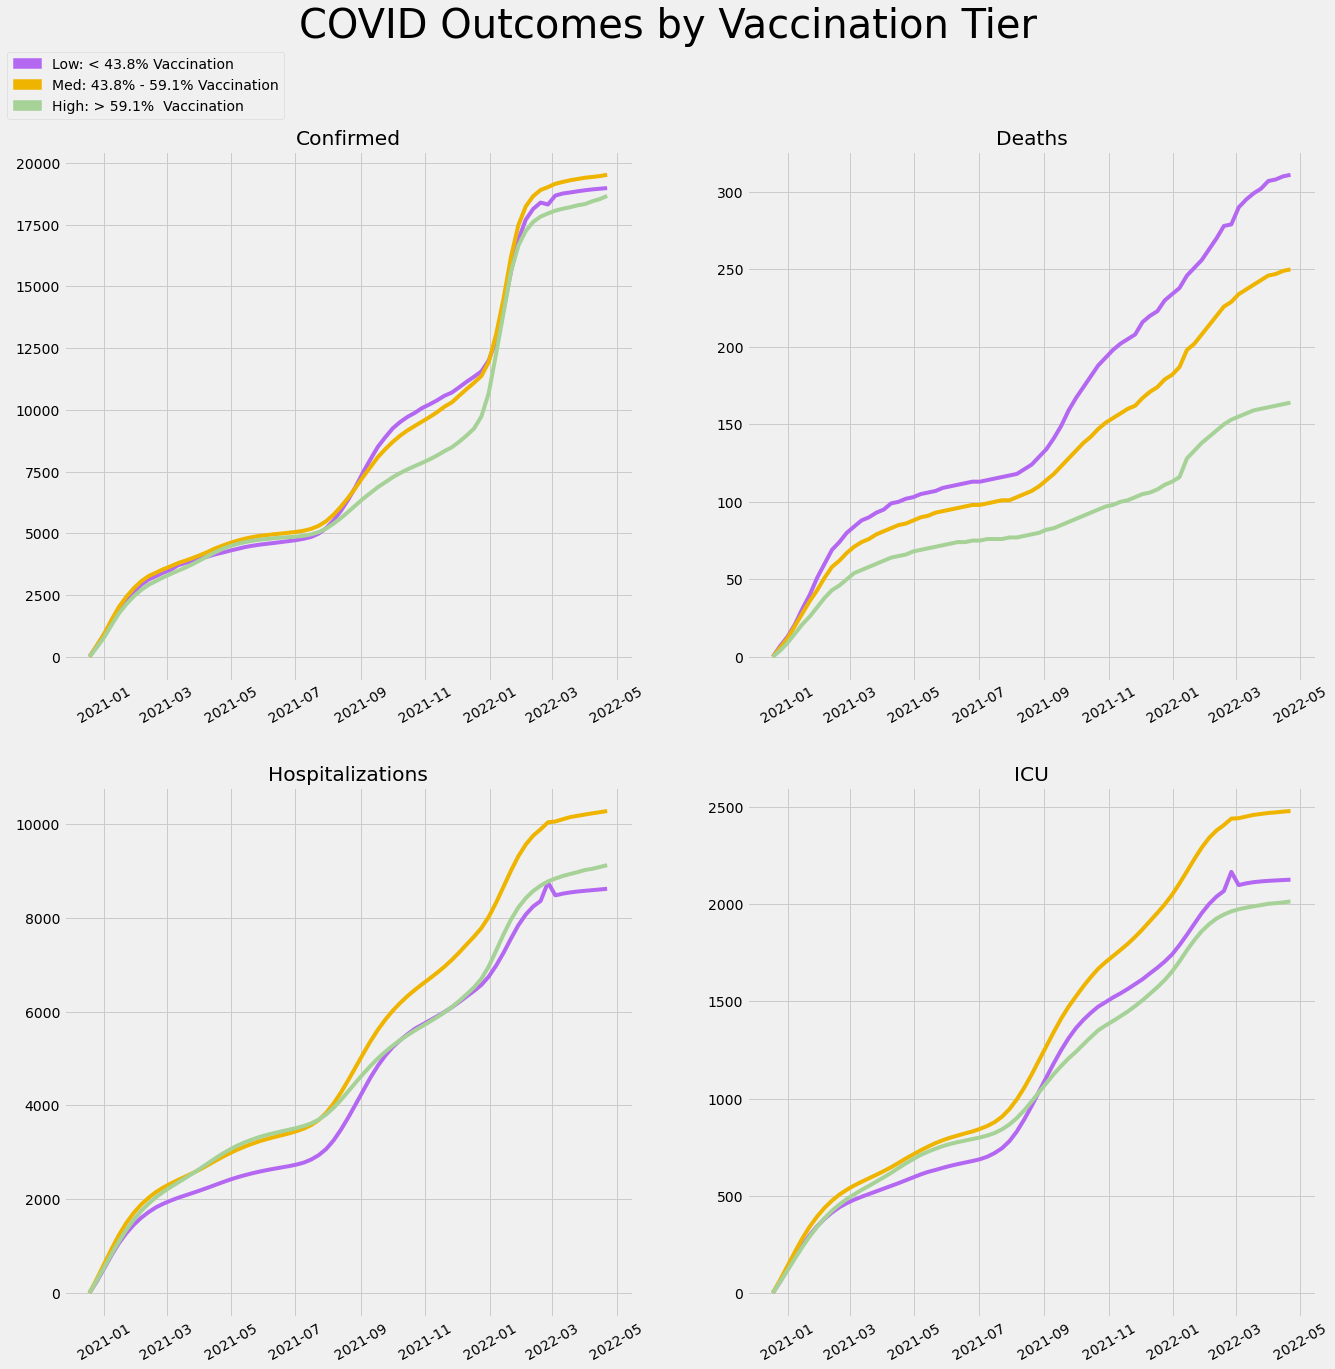

In [85]:


counter = 1
plt.figure(figsize=(20, 20))
plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
for col in ['pv_New_Confirm_tot_100k','pv_New_Deaths_tot_100k','pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',]:

    
    plt.subplot(2,2,counter)
        
    for name in ['low','med','high']:
        

        df = vax_collection_IQR.get(name)
        
        plt.plot(df['Date'],df[col],label=name, color=color_dict[name])

        if col == 'pv_New_Deaths_tot_100k':
            print(name,df[col].max() )
    counter+=1
    low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
    med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
    high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
    plt.xticks(rotation=30)
    if col == 'pv_New_Confirm_tot_100k':
        plt.title(f"Confirmed")
        plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(.4,1.2,0,0))
    elif col == 'pv_New_Deaths_tot_100k':
        plt.title(f"Deaths")
    elif col == 'pv_beds_covid_tot_100k':
        plt.title(f"Hospitalizations")
    elif col == 'pv_icu_covid_tot_100k':
        plt.title(f"ICU")
    
    #plt.legend()
plt.show()



Low 602 19 Million
Med 1209 99 Million
High 605 195 Million
low 311
med 250
high 164


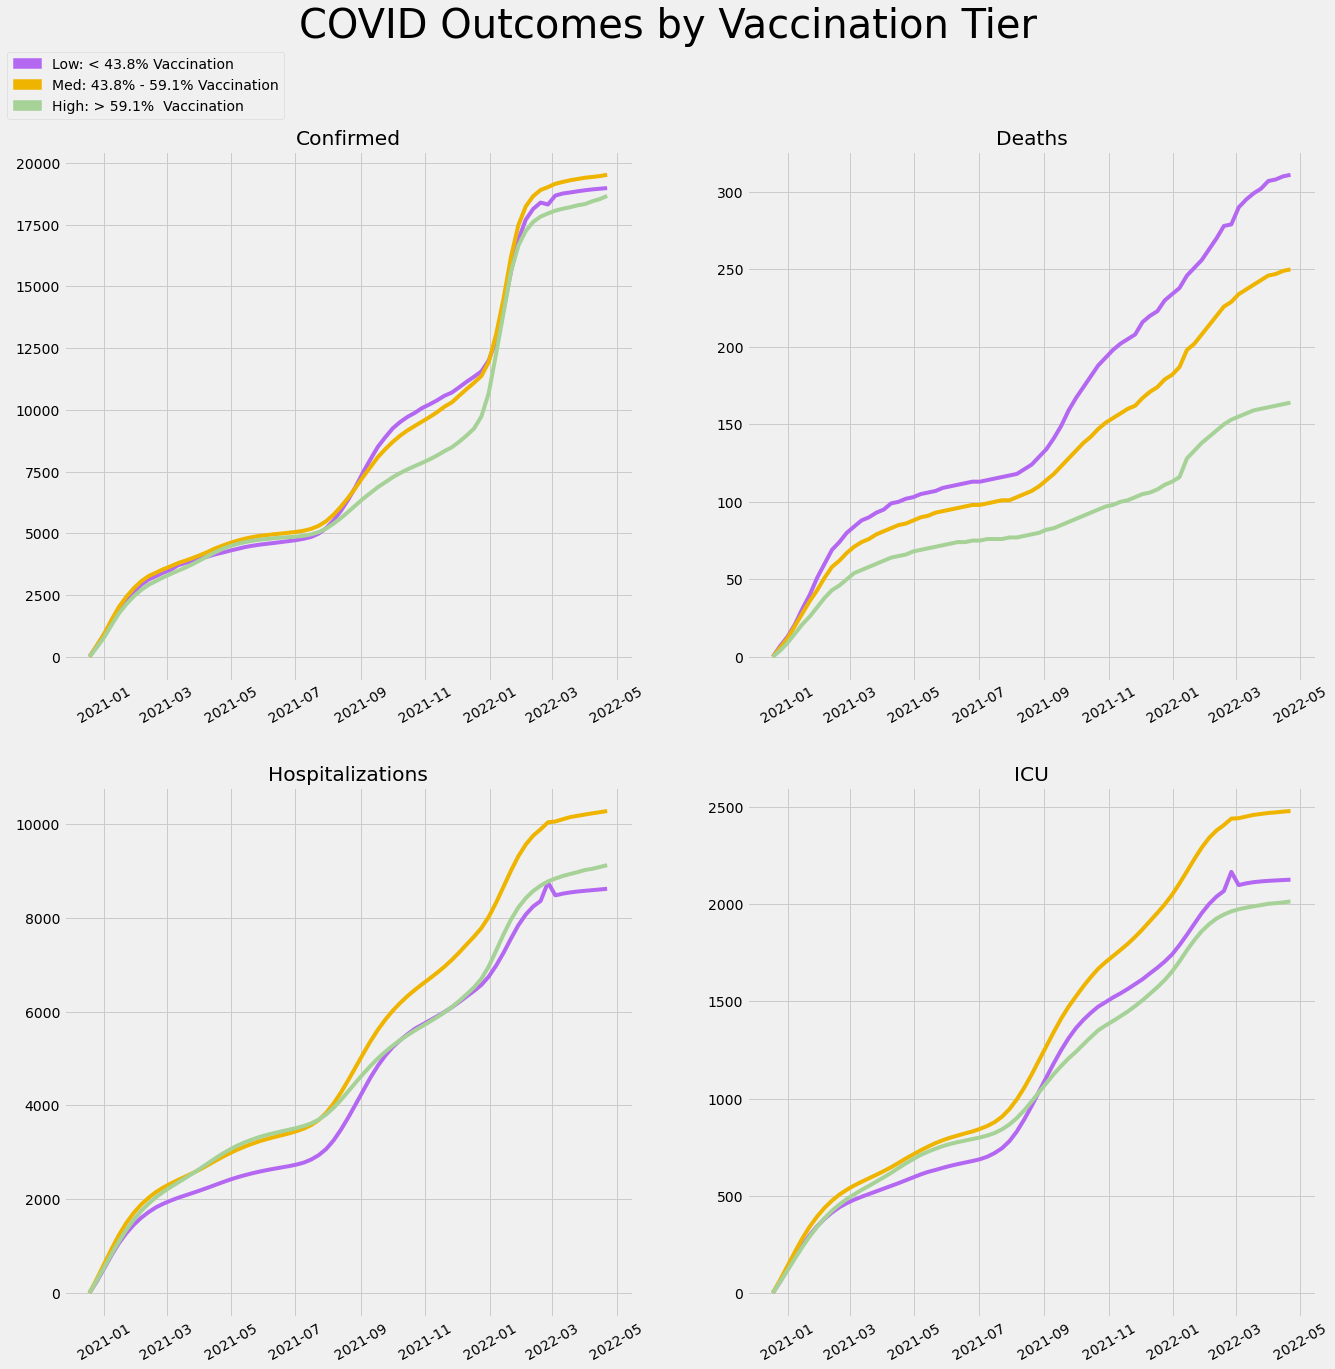

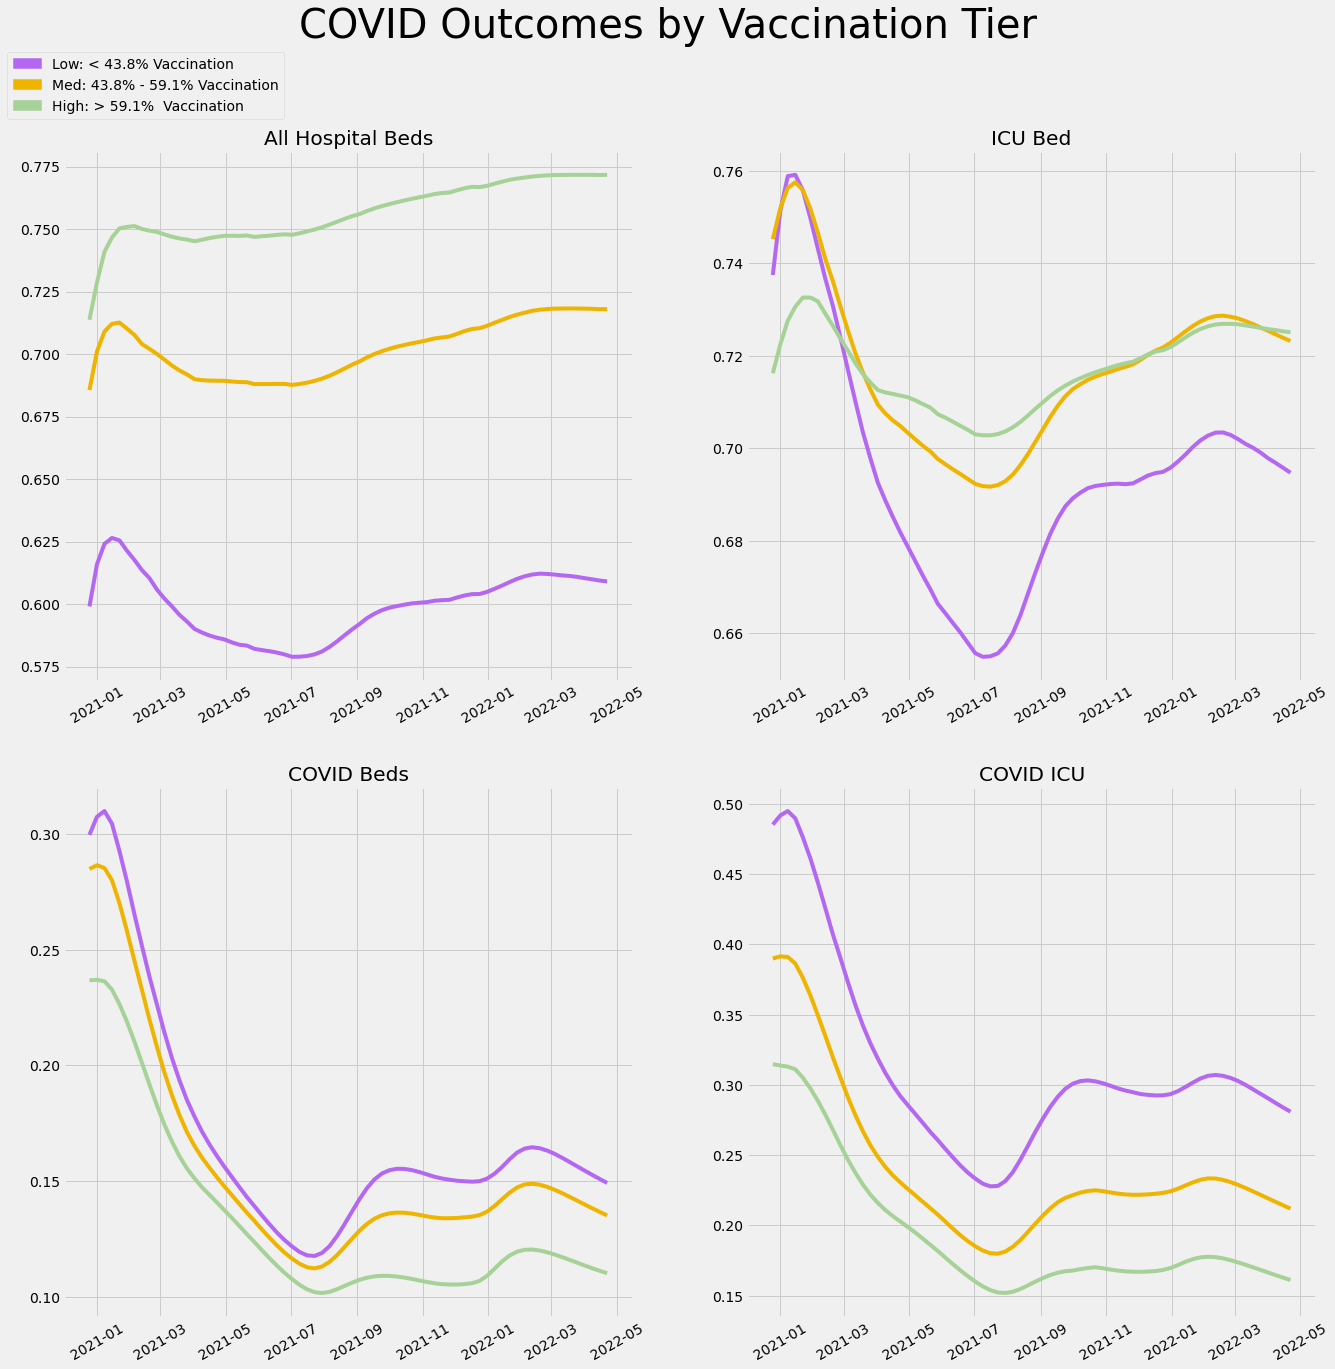

In [86]:
for name in ['low','med','high']:
    
    df = vax_collection_IQR.get(name)
    
    print(f"{name.title()} {df['count'].iloc[0]} {int(df['pop'].iloc[0]/1000000)} Million")

    
#plt.figure(figsize=(12, 8))

#for name in ['low','med','high']:
    
#    df = vax_collection_IQR.get(name)
    
#    plt.plot(df['Date'],df['vax_pct'],label=name, color=color_dict[name])
#plt.title("IQR Vax PCT by Date")

#plt.show()

counter = 1
plt.figure(figsize=(20, 20))
plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
for col in ['pv_New_Confirm_tot_100k','pv_New_Deaths_tot_100k','pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',]:

    
    plt.subplot(2,2,counter)
        
    for name in ['low','med','high']:
        

        df = vax_collection_IQR.get(name)
        
        plt.plot(df['Date'],df[col],label=name, color=color_dict[name])

        if col == 'pv_New_Deaths_tot_100k':
            print(name,df[col].max() )
    counter+=1
    low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
    med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
    high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
    plt.xticks(rotation=30)
    if col == 'pv_New_Confirm_tot_100k':
        plt.title(f"Confirmed")
        plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(.4,1.2,0,0))
    elif col == 'pv_New_Deaths_tot_100k':
        plt.title(f"Deaths")
    elif col == 'pv_beds_covid_tot_100k':
        plt.title(f"Hospitalizations")
    elif col == 'pv_icu_covid_tot_100k':
        plt.title(f"ICU")
    
    #plt.legend()
plt.show()

font = {"size":15}
#,'tot_confirm_100k','tot_deaths_100k','all_bed_util', 'covid_bed_util', 'icu_util', 'icu_covid_util'

counter = 1
plt.figure(figsize=(20, 20))
plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
for col in ['all_bed_util','icu_util','covid_bed_util', 'icu_covid_util',]:

    
    plt.subplot(2,2,counter)
        
    for name in ['low','med','high']:
        

        df = vax_collection_IQR.get(name)
        
        plt.plot(df['Date'],df[col],label=name, color=color_dict[name])

        if col == 'pv_New_Deaths_tot_100k':
            print(name,df[col].max() )
    counter+=1
    low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
    med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
    high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
    plt.xticks(rotation=30)
    #plt.legend(handles=[low_patch,med_patch,high_patch],loc="upper left")
    if col == 'all_bed_util':
        plt.title(f"All Hospital Beds")
        plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(.4,1.2,0,0))
        
    elif col == 'icu_util':
        plt.title(f"ICU Bed")
    elif col == 'covid_bed_util':
        plt.title(f"COVID Beds")
    elif col == 'icu_covid_util':
        plt.title(f"COVID ICU")
    
    #plt.legend()
plt.show()


In [87]:
"""
import matplotlib.patches as mpatches
df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]

#vax_collection_iqr = 
iqr_q1 = np.nanquantile(df['vax_pct'].sort_values(),.25)
iqr_q3 = np.nanquantile(df['vax_pct'].sort_values(),.75)
#//*** Mean minus std Dev
std_q1 = round(df['vax_pct'].mean() - df['vax_pct'].std(),1)

#//*** Mean plus std Dev
std_q3 = round(df['vax_pct'].mean() + df['vax_pct'].std(),1)

#//*** IQR Counties
q1 = std_q1
q3 = std_q3


df=cd.get('week_cdvh_df').copy()
all_geo_df = cd.get("county_geo_df").copy()
all_geo_df = all_geo_df[all_geo_df["GEOID"].isin(df["FIPS"].unique() )]


df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]
df = df[df["vax_pct"] >= q3]
high_vax_cty = list(df['FIPS'].unique())
dfs=[]
df['type'] = "high"
dfs.append(df)

df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]

df = df[(df["vax_pct"] >= q1) & (df["vax_pct"] < q3)]
high_vax_cty = list(df['FIPS'].unique())
df['type'] = "med"
dfs.append(df)

df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]

df = df[(df["vax_pct"] < q1)]
high_vax_cty = list(df['FIPS'].unique())
df['type'] = "low"
dfs.append(df)

df = pd.concat(dfs)

geo_df = cd.get("county_geo_df").copy()
geo_df = geo_df.merge(df[['FIPS','type']],left_on="GEOID",right_on="FIPS")

state_geo_df = cd.get('state_geo_df').copy()

#ax = df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.15),color=(1,1,1,0),ax=ax)

keep_state = geo_df['STATEFP'].unique()
all_state = state_geo_df['STATEFP'].unique()

for state in all_state:
    if state not in keep_state:
        state_geo_df = state_geo_df[state_geo_df['STATEFP'] != state]
        
ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0))
ax = geo_df[geo_df['type'] == "low"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['low'])
ax = geo_df[geo_df['type'] == "med"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['med'])
ax = geo_df[geo_df['type'] == "high"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['high'])
ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0),ax=ax)

ax.grid(False)
ax.axis('off')
fonstize=20
#plt.suptitle(suptitle,fontsize=fontsize)
plt.title("STD Counties by Vaccination Rate")
#text = ""

#for col in ['low','med','high']:
#    text += f"{col.title()}: {len(df[df['type'] == col]['FIPS'].unique())} Counties Pop: {int(df[df['type'] == col]['pop'].sum()/1000000)} Million"
#    text+="\n"
#plt.annotate(text,(0,-.1),xycoords='axes fraction',fontsize=fontsize*1)


fig = ax.get_figure()
fig = plt.gcf()
fig.set_size_inches(12,8)
low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low < {q1}% ')
med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}%')
high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  ')
plt.legend(handles=[low_patch,med_patch,high_patch],loc="lower left")

plt.show()
"""
print("Going with IQR")

Going with IQR


In [88]:
"""
for name in ['low','med','high']:
    
    df = vax_collection_STD.get(name)
    
    print(f"{name.title()} {df['count'].iloc[0]} {int(df['pop'].iloc[0]/1000000)} Million")
cd.l()
display(vax_collection_STD.get('low').columns)
plt.figure(figsize=(12, 8))
for name in ['low','med','high']:
    
    df = vax_collection_STD.get(name)
    
    plt.plot(df['Date'],df['vax_pct'],label=name, color=color_dict[name])
plt.title("STD Vax PCT by Date")

plt.show()
font = {"size":15}

for col in ['pv_New_Confirm_tot_100k','tot_confirm_100k','pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k','pv_New_Deaths_tot_100k','tot_deaths_100k','all_bed_util', 'covid_bed_util', 'icu_util', 'icu_covid_util']:

    plt.figure(figsize=(12, 8))
    plt.title(f"STD {col} by Date")
        
    for name in ['low','med','high']:
        
        df = vax_collection_STD.get(name)
        
        plt.plot(df['Date'],df[col],label=name, color=color_dict[name])
        
    plt.legend()
    plt.show()
"""
print("Going with IQR")

Going with IQR


In [89]:
"""
vax_collection_IQR.l()

print(color_dict)



reload(process_covid)


display()
df=cd.get('week_cdvh_df').copy()
all_geo_df = cd.get("county_geo_df").copy()
all_geo_df = all_geo_df[all_geo_df["GEOID"].isin(df["FIPS"].unique() )]


df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]
df = df[df["vax_pct"] >= q3]
high_vax_cty = list(df['FIPS'].unique())



geo_df = cd.get("county_geo_df").copy()
geo_df = geo_df.merge(df,left_on="GEOID",right_on="FIPS")


process_covid.part_geoplot(geo_df,
    all_geo_df=all_geo_df,
    state_geo_df = cd.get('state_geo_df'),
    figsize=(15,8),
    suptitle=f"High Vaccination >{q3}%  Counties ",
    title=f"Population: {round((df['pop'].sum()) / 1000000,1) } Million - {df['FIPS'].unique()[0]} Counties",
    color=color_dict['high'],
    )    

df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]

df = df[(df["vax_pct"] >= q1) & (df["vax_pct"] < q3)]
high_vax_cty = list(df['FIPS'].unique())

geo_df = cd.get("county_geo_df").copy()
geo_df = geo_df.merge(df,left_on="GEOID",right_on="FIPS")


process_covid.part_geoplot(geo_df,
    all_geo_df=all_geo_df,
    state_geo_df = cd.get('state_geo_df'),
    figsize=(15,8),
    suptitle=f"Medium Vaccination {q1}% - {q3}%  Counties ",
    title=f"Population: {round((df['pop'].sum()) / 1000000,1) } Million - {df['FIPS'].unique()[0]} Counties",
    color=color_dict['med'],
    )    

df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]

df = df[(df["vax_pct"] < q1) ]
high_vax_cty = list(df['FIPS'].unique())

geo_df = cd.get("county_geo_df").copy()
geo_df = geo_df.merge(df,left_on="GEOID",right_on="FIPS")


process_covid.part_geoplot(geo_df,
    all_geo_df=all_geo_df,
    state_geo_df = cd.get('state_geo_df'),
    figsize=(15,8),
    suptitle=f"Low Vaccination {q3}% <  Counties ",
    title=f"Population: {round((df['pop'].sum()) / 1000000,1) } Million - {df['FIPS'].unique()[0]} Counties",
    color=color_dict['low'],
    )    
    
"""
print()